# Week HW 18

Last Audit: HW18

# Import


In [1]:
import gurobipy as gp
from gurobipy import GRB
import gurobipy_pandas as gppd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import min_, max_
from scipy.stats import multivariate_normal, norm
import pickle
import os
import glob
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
import math

params = {
    "WLSACCESSID": "73a6e3bf-2a9d-41e8-85eb-dd9b9eda802b",
    "WLSSECRET": "c394298a-96ea-4c8c-9d5e-ef2bd5032427",
    "LICENSEID": 2563044,
}

env = gp.Env(params=params)
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2563044
Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw


# Settings


In [2]:
#####################

salvage_value = 0
cost = 500
price = 1000
holding_cost = 0

model_prefix = f"linear_constraint_med_with_holding_cost_{holding_cost}"

#####################

data_size = 20
train_size = 0.5
testing_size = 0.5
k_fold = 2

T = 10
service_level = 0.95  # 服務水準
M = 5000000

ASSIGNED_FS = np.arange(0.1, 1.0, 0.1)
ASSIGNED_TS = list(range(2, T))  # 2 到 T-1

np.random.seed(0)

# Gurobi Model Constants
THREADS = 12
TIME_LIMIT = 10000
MIPGAP = 0.5
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))

# Utils


## Models' Parameters

In [3]:
def save_model_parameters(
    name: str,
    alpha_values=None,
    beta_values=None,
    f_values=None,
    tau_values=None,
    data_size=data_size,
    current_timestamp=CURRENT_TIMESTAMP,
):
    os.makedirs("models", exist_ok=True)

    params = {}
    if alpha_values is not None:
        params["alpha"] = alpha_values
    if beta_values is not None:
        params["beta"] = beta_values
    if f_values is not None:
        params["f_values"] = f_values
    if tau_values is not None:
        params["tau_values"] = tau_values

    # 如果有參數才進行保存
    if params:
        with open(f"models/{name}_{data_size}_{current_timestamp}.pkl", "wb") as f:
            pickle.dump(params, f)
        print(
            f"Model parameters saved as models/{name}_{data_size}_{current_timestamp}.pkl"
        )
    else:
        print("No parameters provided to save.")

In [4]:
def delete_model_parameters(name: str, data_size: int):
    # 構建檔案的路徑
    file_path = f"models/{name}_{data_size}_{CURRENT_TIMESTAMP}.pkl"

    # 檢查檔案是否存在
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Model parameters file '{file_path}' has been deleted.")
    else:
        print(f"File '{file_path}' does not exist.")

In [5]:
def show_models(model_prefix):
    file_paths = sorted(glob.glob(f"models/{model_prefix}_*.pkl"))

    # 逐一讀取並打印每個檔案的內容
    for file_path in file_paths:
        with open(file_path, "rb") as f:
            params = pickle.load(f)
            print(f"Contents of {file_path}:")
            print(params)
            print()  # 空行分隔每個檔案的內容

In [6]:
show_models("linear_constraint_med_with_holding_cost")

Contents of models/linear_constraint_med_with_holding_cost_0_s2_100_202411271120.pkl:
{'alpha': array([1.22289394, 0.        , 3.96153466])}

Contents of models/linear_constraint_med_with_holding_cost_0_s2_200_202411271119.pkl:
{'alpha': array([ 69.77926805,   4.29391753, 124.0104279 ])}

Contents of models/linear_constraint_med_with_holding_cost_0_s2_200_202411282051.pkl:
{'alpha': array([ 69.77926805,   4.29391753, 124.0104279 ])}

Contents of models/linear_constraint_med_with_holding_cost_0_s2_20_202411272000.pkl:
{'alpha': array([1.65238988, 0.60126413, 4.06809387])}

Contents of models/linear_constraint_med_with_holding_cost_0_s2_40_202411271120.pkl:
{'alpha': array([0.88382231, 0.        , 9.78531581])}

Contents of models/linear_constraint_med_with_holding_cost_0_s2_40_202411271920.pkl:
{'alpha': array([0.88382231, 0.        , 9.78531581])}

Contents of models/linear_constraint_med_with_holding_cost_0_s2_50_202411271119.pkl:
{'alpha': array([275257.34539944,  29965.43240897, 515

## Visualization 

In [7]:
def plot_strategies_profits_scatter(save_type, dfs):

    if len(dfs) <= 1:
        print("No dataframes to plot.")
        return None

    # 生成所有兩兩配對
    pairs = list(itertools.combinations(range(len(dfs)), 2))
    num_pairs = len(pairs)

    # 計算網格大小
    grid_size = math.ceil(math.sqrt(num_pairs))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig.suptitle("Scatter Plots of Profits (Matrix View)")

    # 繪製每個配對的散佈圖
    for idx, (i, j) in enumerate(pairs):
        row, col = divmod(idx, grid_size)

        if (dfs[i] is None or len(dfs[i]) == 0) or (dfs[j] is None or len(dfs[j]) == 0):
            continue

        profits_i = dfs[i]["profits"]
        profits_j = dfs[j]["profits"]

        if len(profits_i) != len(profits_j):
            continue

        ax = axes[row, col]
        ax.scatter(profits_i, profits_j, alpha=0.6, label=f"Profits {i} vs Profits {j}")
        ax.set_xlabel(f"Profits {i}")
        ax.set_ylabel(f"Profits {j}")

        # 繪製 45 度虛線
        max_val = max(profits_i.max(), profits_j.max())
        min_val = min(profits_i.min(), profits_j.min())
        ax.plot([min_val, max_val], [min_val, max_val], "k--", lw=1)

        ax.legend()
        ax.set_title(f"Profits {i} vs Profits {j}")

    # 隱藏未使用的子圖軸
    for idx in range(num_pairs, grid_size * grid_size):
        row, col = divmod(idx, grid_size)
        fig.delaxes(axes[row, col])

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    name = "plot_strategies_profits_scatter"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [8]:
def plot_relative_profit_deviation(save_type, baseline_profit, max_profits):
    """
    繪製多個策略相對於基準的平均利潤偏差。

    :param baseline_profit: 基準利潤值
    :param max_profits: 各策略的最大利潤列表，包含 None 值或 -1 表示無效數據
    """
    print(f"Baseline is: {baseline_profit}")
    for i, profit in enumerate(max_profits):
        print(f"S{i+1}'s profit: {profit}")

    # 計算相對值
    ratios = {}
    for idx, max_profit in enumerate(max_profits, start=1):
        if max_profit is not None and max_profit != -1:
            ratio = max_profit / baseline_profit
            ratios[f"S{idx}"] = ratio - 1  # 相對偏差

    # 設置 y 軸範圍
    if ratios:
        y_min = min(ratios.values()) - 0.1
        y_max = max(ratios.values()) + 0.1
    else:
        y_min, y_max = -0.1, 0.1

    # 創建圖表顯示結果
    plt.figure(figsize=(12, 8))

    if ratios:
        bars = plt.bar(
            ratios.keys(), ratios.values(), color=plt.cm.tab10(range(len(ratios)))
        )

        # 在每個柱狀圖上標出數值
        for bar in bars:
            yval = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                yval,
                f"{yval:.4f}",
                ha="center",
                va="bottom",
            )

    # 添加基準線，表示基準值（No Opt）
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # 設置圖表標題和軸標籤
    plt.title("Relative Avg Profit Deviation from Baseline (1)")
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline (1)")
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_deviation"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [9]:
def plot_relative_profit_comparison(
    save_type,
    train_baseline_profit,
    test_baseline_profit,
    test_max_profits,
    train_max_profits,
):

    # Calculate relative deviations from baseline for test and train data
    test_ratios, train_ratios = {}, {}
    for idx, (test_profit, train_profit) in enumerate(
        zip(test_max_profits, train_max_profits), start=1
    ):
        if test_profit is not None and test_profit != -1:
            test_ratio = test_profit / test_baseline_profit - 1  # Relative deviation
            test_ratios[f"S{idx}"] = test_ratio
        if train_profit is not None and train_profit != -1:
            train_ratio = train_profit / train_baseline_profit - 1  # Relative deviation
            train_ratios[f"S{idx}"] = train_ratio

    # Define the range of the y-axis
    y_min = (
        min(min(test_ratios.values(), default=0), min(train_ratios.values(), default=0))
        - 0.1
    )
    y_max = (
        max(max(test_ratios.values(), default=0), max(train_ratios.values(), default=0))
        + 0.1
    )

    # Create bar plot for relative profit deviation comparison
    plt.figure(figsize=(14, 8))
    bar_width = 0.35
    indices = np.arange(len(train_ratios))

    # Plot bars for train and test ratios, with train on the left for each pair
    train_bars = plt.bar(
        indices - bar_width / 2,
        train_ratios.values(),
        bar_width,
        label="Train Data",
        color="salmon",
    )
    test_bars = plt.bar(
        indices + bar_width / 2,
        test_ratios.values(),
        bar_width,
        label="Test Data",
        color="skyblue",
    )

    # Add baseline line
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # Add labels for each bar
    for bar in train_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )
    for bar in test_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )

    # Set plot labels and title
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline")
    plt.title("Relative Profit Deviation Comparison between Train and Test Data")
    plt.xticks(indices, train_ratios.keys())
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_comparison"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [10]:
def plot_Q0_Q1_distribution(save_type, stimulation_results_dfs):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is None or len(df) == 0:
            continue

        df["Q0"] = pd.to_numeric(df["Q0"], errors="coerce")
        df["Q1"] = pd.to_numeric(df["Q1"], errors="coerce")
        df.dropna(subset=["Q0", "Q1"], inplace=True)

        plt.figure(figsize=(10, 6))
        plt.hist(df["Q0"], bins=20, alpha=0.6, label="Q0", edgecolor="black")
        plt.hist(df["Q1"], bins=20, alpha=0.6, label="Q1", edgecolor="black")
        plt.title(f"Histogram of Q0 and Q1 for stimulation_results_df_{idx}")
        plt.xlabel("Value")
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True)

        name = "plot_Q0_Q1_distribution"

        os.makedirs("plots", exist_ok=True)
        save_path = (
            f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
        )

        plt.savefig(save_path, format="png", bbox_inches="tight")
        print(f"Plot saved as {save_path}")

        plt.show()

In [11]:
import seaborn as sns


def plot_profits_deviation_box_plot(
    save_type, stimulation_results_dfs, baseline_avg_profits
):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is not None and "profits" in df.columns:
            df["profits"] = pd.to_numeric(df["profits"], errors="coerce")
            df.dropna(subset=["profits"], inplace=True)

            # Calculate deviation
            df["Deviation"] = df["profits"] - baseline_avg_profits

            # Plot deviation as a boxplot
            plt.figure(figsize=(8, 6))
            sns.boxplot(y=df["Deviation"])
            plt.axhline(0, color="red", linestyle="--", label="Baseline")
            plt.title(
                f"Boxplot of Deviation of Profits from Baseline for stimulation_results_df_{idx}"
            )
            plt.ylabel("Deviation")
            plt.legend()
            plt.grid(True, axis="y")

            name = "plot_profits_deviation_box_plot"

            os.makedirs("plots", exist_ok=True)
            save_path = (
                f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
            )

            plt.savefig(save_path, format="png", bbox_inches="tight")
            print(f"Plot saved as {save_path}")

            plt.show()
        else:
            print(f"Skipping stimulation_results_df_{idx}: Missing 'profits' column.")

## Others

In [12]:
def organize_stimulation_result(stimulation_df, Q_star, Qk_hat_df_train):

    # 檢查運算正確
    if stimulation_df is None or len(stimulation_df) == 0:
        return None, None

    Qk_hat_list = []
    for index, row in stimulation_df.iterrows():
        Qk_hat_list.append(Qk_hat_df_train.iloc[index, int(row["R"])])

    stimulation_df["Q_star"] = Q_star
    stimulation_df["Qk_hat"] = Qk_hat_list
    stimulation_df["Qk_hat-Q0"] = stimulation_df["Qk_hat"] - stimulation_df["Q0"]

    stimulation_df_selected = stimulation_df[
        [
            "R",
            "Q_star",
            "F",
            "Q0",
            "demand_up",
            "Sold0s",
            "Left0s",
            "lost0s",
            "Qk_hat",
            "Qk_hat-Q0",
            "Q1",
            "Q1_plus_lefts",
            "demand_down",
            "Sold1s",
            "Left1s",
            "lost1s",
        ]
    ]
    stimulation_df_selected["Q0-Sold0s(left0)"] = (
        stimulation_df_selected["Q0"] - stimulation_df_selected["Sold0s"]
    )
    stimulation_df_selected["demand_up-Q0(lost0)"] = (
        stimulation_df_selected["demand_up"] - stimulation_df_selected["Q0"]
    )
    stimulation_df_selected["Q1_plus_lefts-Sold1s(left1)"] = (
        stimulation_df_selected["Q1_plus_lefts"] - stimulation_df_selected["Sold1s"]
    )

    stimulation_df_selected["demand_down-Q1_plus_lefts(lost1)"] = (
        stimulation_df_selected["demand_down"]
        - stimulation_df_selected["Q1_plus_lefts"]
    )

    stimulation_df_selected["Q0-Sold0s(left0)_clip"] = (
        stimulation_df_selected["Q0"] - stimulation_df_selected["Sold0s"]
    ).clip(lower=0)

    stimulation_df_selected["demand_up-Q0(lost0)_clip"] = (
        stimulation_df_selected["demand_up"] - stimulation_df_selected["Q0"]
    ).clip(lower=0)

    stimulation_df_selected["Q1_plus_lefts-Sold1s(left1)_clip"] = (
        stimulation_df_selected["Q1_plus_lefts"] - stimulation_df_selected["Sold1s"]
    ).clip(lower=0)

    stimulation_df_selected["demand_down-Q1_plus_lefts(lost1)_clip"] = (
        stimulation_df_selected["demand_down"]
        - stimulation_df_selected["Q1_plus_lefts"]
    ).clip(lower=0)

    results = {
        "Metric": [
            "Left0s - Q0-Sold0s(left0)",
            "Lost0s - demand_up-Q0(lost0)",
            "Left1s - Q1_plus_lefts-Sold1s(left1)",
            "Lost1s - demand_down-Q1_plus_lefts(lost1)",
        ],
        "Average Difference": [
            round(
                (
                    stimulation_df_selected["Left0s"]
                    - (stimulation_df_selected["Q0-Sold0s(left0)_clip"])
                ).mean(),
                3,
            ),
            round(
                (
                    stimulation_df_selected["lost0s"]
                    - (stimulation_df_selected["demand_up-Q0(lost0)_clip"])
                ).mean(),
                3,
            ),
            round(
                (
                    stimulation_df_selected["Left1s"]
                    - (stimulation_df_selected["Q1_plus_lefts-Sold1s(left1)_clip"])
                ).mean(),
                3,
            ),
            round(
                (
                    stimulation_df_selected["lost1s"]
                    - (stimulation_df_selected["demand_down-Q1_plus_lefts(lost1)_clip"])
                ).mean(),
                3,
            ),
        ],
    }

    return stimulation_df_selected, pd.DataFrame(results)

In [13]:
# Function to replace negative values with 0
def replace_negative_with_zero(df):
    return df.applymap(lambda x: max(x, 0))

In [14]:
def check_values(
    Q1_vars,
    Q_hat_adjusteds,
    Q0_vars,
    Sold_0s,
    total_demand_up_to_k_minus_1_vars,
    Sold_1s,
    total_demand_from_k_to_T_vars,
    Q1_plus_lefts,
    Left_0s,
    Lost_0s,
    Left_1s,
    Lost_1s,
):

    # 用於存儲每個條件的統計結果
    results = {
        "Condition": [],
        "Average_Error_Percentage": [],
        "Max_Error_Percentage": [],
        "Min_Error_Percentage": [],
        "Max_Error": [],
        "Min_Error": [],
    }

    # 定義存儲每個條件下的誤差和誤差百分比
    conditions_errors = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 存儲每個條件下的誤差百分比
    conditions_error_percentage = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 遍歷每一個變量集合
    for i in range(len(Q1_vars)):
        # 提取變量的值
        Q1 = Q1_vars[i].X
        Q_hat_adjusted = Q_hat_adjusteds[i].X
        Q0 = Q0_vars[i].X
        Sold_0 = Sold_0s[i].X
        total_demand_up_to_k_minus_1 = total_demand_up_to_k_minus_1_vars[i].X
        Sold_1 = Sold_1s[i].X
        total_demand_from_k_to_T = total_demand_from_k_to_T_vars[i].X
        Q1_plus_left = Q1_plus_lefts[i].X
        Left_0 = Left_0s[i].X
        Lost_0 = Lost_0s[i].X
        Left_1 = Left_1s[i].X
        Lost_1 = Lost_1s[i].X

        # 計算理論值
        theoretical_sold_0 = min(total_demand_up_to_k_minus_1, Q0)
        theoretical_left_0 = max(Q0 - theoretical_sold_0, 0)
        theoretical_Q1_plus_left = Q1 + theoretical_left_0  # Q1_plus_left 的理論值
        theoretical_sold_1 = min(total_demand_from_k_to_T, theoretical_Q1_plus_left)
        theoretical_left_1 = max(theoretical_Q1_plus_left - theoretical_sold_1, 0)
        theoretical_lost_0 = max(total_demand_up_to_k_minus_1 - Q0, 0)
        theoretical_lost_1 = max(total_demand_from_k_to_T - theoretical_Q1_plus_left, 0)

        # 檢查條件 2：Sold_0 一定等於理論值
        if not (Sold_0 == theoretical_sold_0):
            error = abs(Sold_0 - theoretical_sold_0)
            conditions_errors["Sold_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_0s"].append(
                (error / theoretical_sold_0) * 100 if theoretical_sold_0 != 0 else 0
            )

        # 檢查條件 3：Sold_1 一定等於理論值
        if not (Sold_1 == theoretical_sold_1):
            error = abs(Sold_1 - theoretical_sold_1)
            conditions_errors["Sold_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_1s"].append(
                (error / theoretical_sold_1) * 100 if theoretical_sold_1 != 0 else 0
            )

        # 檢查條件 4：Left_0 一定等於理論值
        if not (Left_0 == theoretical_left_0):
            error = abs(Left_0 - theoretical_left_0)
            conditions_errors["Left_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_0s"].append(
                (error / theoretical_left_0) * 100 if theoretical_left_0 != 0 else 0
            )

        # 檢查條件 5：Left_1 一定等於理論值
        if not (Left_1 == theoretical_left_1):
            error = abs(Left_1 - theoretical_left_1)
            conditions_errors["Left_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_1s"].append(
                (error / theoretical_left_1) * 100 if theoretical_left_1 != 0 else 0
            )

        # 檢查條件 6：Lost_0 一定等於理論值
        if not (Lost_0 == theoretical_lost_0):
            error = abs(Lost_0 - theoretical_lost_0)
            conditions_errors["Lost_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_0s"].append(
                (error / theoretical_lost_0) * 100 if theoretical_lost_0 != 0 else 0
            )

        # 檢查條件 7：Lost_1 一定等於理論值
        if not (Lost_1 == theoretical_lost_1):
            error = abs(Lost_1 - theoretical_lost_1)
            conditions_errors["Lost_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_1s"].append(
                (error / theoretical_lost_1) * 100 if theoretical_lost_1 != 0 else 0
            )

    # 計算每個條件的統計結果
    for condition, errors in conditions_errors.items():
        error_percentages = conditions_error_percentage[condition]
        if errors:
            # 統計數據，並將所有數值四捨五入至小數點后三位
            avg_error_percentage = (
                round(sum(error_percentages) / len(error_percentages), 3)
                if error_percentages
                else 0.0
            )
            max_error_percentage = (
                round(max(error_percentages), 3) if error_percentages else 0.0
            )
            min_error_percentage = (
                round(min(error_percentages), 3) if error_percentages else 0.0
            )
            max_error = round(max(errors), 3) if errors else 0.0
            min_error = round(min(errors), 3) if errors else 0.0

            # 存儲結果
            results["Condition"].append(condition)
            results["Average_Error_Percentage"].append(avg_error_percentage)
            results["Max_Error_Percentage"].append(max_error_percentage)
            results["Min_Error_Percentage"].append(min_error_percentage)
            results["Max_Error"].append(max_error)
            results["Min_Error"].append(min_error)

    # 轉換為 DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [15]:
# Calculate service level
def calculate_service_level(*, salvage_value, cost, price):

    cu = price - cost
    co = cost - salvage_value
    service_lv = cu / (co + cu)

    return service_lv

In [16]:
def make_s3_related_strtegies_result(
    *,
    all_Rs,
    losses,
    lefts,
    profits,
    operation_profits,
    alpha_values,
    beta_values,
    F_vars,
    Q0_vars,
    Q1_vars,
    f_values,
    tau_values,
    holding_costs_0s,
    holding_costs_1s,
    all_left0s,
    all_left1s,
    all_lost0s,
    all_lost1s,
    all_Qk_hat,
    all_sold0s,
    all_sold1s,
    all_demand_up,
    all_demand_down,
    all_Q1_plus_lefts,
):

    results_dict = {
        "average_profits": [sum(profits) / len(profits) if profits else 0],
        "average_losses": [sum(losses) / len(losses) if losses else 0],
        "average_lefts": [sum(lefts) / len(lefts) if lefts else 0],
        "average_operation_profits": [
            sum(operation_profits) / len(operation_profits) if operation_profits else 0
        ],
        "alpha_values": [alpha_values],
        "beta_values": [beta_values],
        "tau_values": [tau_values],
    }
    stimulations_result = {
        "R(T)": all_Rs,
        "R": [x - 2 for x in all_Rs],
        "F": F_vars,
        "f_values": f_values,
        "profits": profits,
        "losses": losses,
        "lefts": lefts,
        "operation_profits": operation_profits,
        "Q0": Q0_vars,
        "Q1": Q1_vars,
        "hc0": holding_costs_0s,
        "hc1": holding_costs_1s,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "lost0s": all_lost0s,
        "lost1s": all_lost1s,
        "Qk_hat": all_Qk_hat,
        "Sold0s": all_sold0s,
        "Sold1s": all_sold1s,
        "demand_up": all_demand_up,
        "demand_down": all_demand_down,
        "Q1_plus_lefts": all_Q1_plus_lefts,
    }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(stimulations_result)

# Generate Data


## Data1: Training data for LR


### Making full data


In [17]:
np.random.seed(0)

full_df = pd.DataFrame(
    {
        "X1": np.random.uniform(100, 150, data_size),
        "X2": np.random.uniform(-30, -10, data_size),
    }
)

full_df

X1         X2
0   127.440675 -10.427633
1   135.759468 -14.016829
2   130.138169 -20.770413
3   127.244159 -14.389416
4   121.182740 -27.634511
5   132.294706 -17.201580
6   121.879361 -27.132934
7   144.588650 -11.106622
8   148.183138 -19.563034
9   119.172076 -21.706761
10  139.586252 -24.708888
11  126.444746 -14.515326
12  128.402228 -20.876993
13  146.279832 -18.631321
14  103.551803 -29.624204
15  104.356465 -17.647290
16  101.010920 -17.758086
17  141.630992 -17.661320
18  138.907838 -11.125038
19  143.500607 -16.363594

In [18]:
features_num = full_df.shape[1]
features_num

2

### Split training and testing data


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def train_data_split_and_normalize_k_fold(data, train_size=0.8, k_fold=2):
    folds = []
    scalers = []

    for i in range(k_fold):
        # Randomly split the data into train and test sets
        train_data, test_data = train_test_split(
            data, train_size=train_size, random_state=i
        )
        test_data.reset_index(drop=True, inplace=True)
        train_data.reset_index(drop=True, inplace=True)

        # Normalize the train and test data
        scaler = StandardScaler()
        train_data_normalized = scaler.fit_transform(train_data)
        test_data_normalized = scaler.transform(test_data)

        # Convert normalized data back to DataFrame
        train_data_normalized = pd.DataFrame(
            train_data_normalized, columns=data.columns
        )
        test_data_normalized = pd.DataFrame(test_data_normalized, columns=data.columns)

        # Append the fold and scaler
        folds.append((train_data_normalized, test_data_normalized))
        scalers.append(scaler)

    return folds, scalers


training_data_folds, scalers = train_data_split_and_normalize_k_fold(
    full_df, train_size, k_fold=k_fold
)

# Print each fold's train and test sizes and normalized data
for i, (train, test) in enumerate(training_data_folds):
    print(f"Fold {i + 1}:")
    print(f"Train size: {train.shape}, Test size: {test.shape}")
    print("Train (normalized):")
    print(train.head())
    print("Test (normalized):")
    print(test.head())
    print()

Fold 1:
Train size: (10, 2), Test size: (10, 2)
Train (normalized):
         X1        X2
0  0.801348  0.060576
1 -1.322677 -2.263356
2 -0.168380 -0.782220
3  1.709838  1.200776
4 -1.510442 -0.043531
Test (normalized):
         X1        X2
0  1.290041  1.197330
1  1.057385  0.656356
2  1.629435  0.217340
3  1.975462 -0.381187
4  1.340174 -1.343835

Fold 2:
Train size: (10, 2), Test size: (10, 2)
Train (normalized):
         X1        X2
0  1.155422 -0.504766
1 -0.317164  1.763667
2  0.938181  0.122292
3  0.579181  1.570825
4 -0.963489 -1.355168
Test (normalized):
         X1        X2
0 -0.332525  0.668179
1 -2.383078 -0.263304
2 -0.751871 -2.855580
3  0.632210 -2.185297
4 -0.106311 -1.096254



## Data2: demand_df


### mu of each time(t)


In [20]:
# 設定 b0, b1, b2
b0 = 0.3
b1 = 0.17
b2 = 0.2


def cal_mu_matrix_with_random_noise(data_size, T, training_df, sigma_t):
    np.random.seed(0)

    # 初始化 mu_matrix
    mu_matrix = np.zeros((data_size, T))

    # 生成每個 t 的隨機數
    random_noises = np.random.normal(0, sigma_t, T)

    # 計算 mu_matrix
    for t in range(1, T + 1):
        mu_matrix[:, t - 1] = (
            b1 * training_df["X1"] + b2 * training_df["X2"] + b0 * random_noises[t - 1]
        )

    return mu_matrix

In [21]:
# mu_matrix = cal_mu_matrix(data_size, T, full_df)
mu_matrix = cal_mu_matrix_with_random_noise(data_size, T, full_df, sigma_t=1)

print(f"mu_matrix shape: {mu_matrix.shape}")
print(f"mu_matrix[0]: \n{mu_matrix[0]}")

mu_matrix shape: (20, 10)
mu_matrix[0]: 
[20.10860386 19.69943531 19.87300955 20.25165611 20.13965555 19.28620479
 19.86441468 19.53398099 19.5484225  19.7025677 ]


### sigma matrix


In [22]:
X = full_df.values  # 轉換為 NumPy 矩陣
feature_num = X.shape[1]  # 特徵數量

# 生成輸入特徵矩陣 X (shape: feature_num * data_size)
np.random.seed(0)
X = np.random.rand(feature_num, data_size)

# 隨機生成常數項 c 和係數向量 coefficients
c = np.random.uniform(0, 1)
coefficients = np.random.uniform(-1, 1, (feature_num, T))  # shape: (feature_num, T)
print(f"coefficients.shape: {coefficients.shape}")
print(f"coefficients: {coefficients}")

coefficients.shape: (2, 10)
coefficients: [[-0.12593609  0.39526239 -0.87954906  0.33353343  0.34127574 -0.57923488
  -0.7421474  -0.3691433  -0.27257846  0.14039354]
 [-0.12279697  0.97674768 -0.79591038 -0.58224649 -0.67738096  0.30621665
  -0.49341679 -0.06737845 -0.51114882 -0.68206083]]


In [23]:
# 進行矩陣運算
# X.T 的形狀為 (data_size, feature_num)，X.T @ coefficients 的形狀為 (data_size, T)
linear_combination = c + X.T @ coefficients

# 使用 sigmoid 函數將值映射到 [0, 1] 之間
sigma_matrix = 1 / (1 + np.exp(-linear_combination))  # shape: (data_size, T)

# 再將值縮放到 [2, 10] 的範圍
sigma_matrix = 2 + sigma_matrix * 8  # shape: (data_size, T)

# 輸出 sigma_matrix 的形狀和內容
sigma_matrix_shape = sigma_matrix.shape
sigma_matrix_content = sigma_matrix

sigma_matrix_shape, sigma_matrix_content

((20, 10),
 array([[6.33962255, 8.57873649, 4.30896461, 5.94552029, 5.76807482,
         6.67602145, 4.96290496, 6.18183316, 5.42343077, 5.54020243],
        [6.3417756 , 8.44618042, 4.30321694, 6.26509127, 6.12445957,
         6.37878351, 4.89804711, 6.0832969 , 5.51455209, 5.82978508],
        [6.4519222 , 7.92390401, 4.94931996, 6.57960146, 6.50256833,
         6.30277772, 5.37411811, 6.21161838, 5.91865713, 6.25838967],
        [6.38884974, 8.33631163, 4.58232804, 6.17345972, 6.03349463,
         6.56206346, 5.15300694, 6.21135712, 5.62513907, 5.80742419],
        [6.57916252, 7.24252343, 5.78569915, 6.85070621, 6.83547072,
         6.30009478, 5.97347039, 6.38906489, 6.36611822, 6.6702511 ],
        [6.39785249, 8.20429894, 4.62283156, 6.4033117 , 6.2924086 ,
         6.36168537, 5.1423411 , 6.15584812, 5.71320538, 6.02744396],
        [6.56969352, 7.29648329, 5.72151549, 6.83167648, 6.81204214,
         6.29931802, 5.9280493 , 6.37552407, 6.3331389 , 6.64076637],
        [6.26202

### corr matrix


In [24]:
# Generate correlation matrix
np.random.seed(0)

A = np.random.uniform(-1, 1, (T, T))
corr_matrix = np.dot(A, A.T)

D = np.diag(1 / np.sqrt(np.diag(corr_matrix)))
corr_matrix = D @ corr_matrix @ D

print(f"corr_matrix shape: {corr_matrix.shape}")
print(f"corr_matrix: \n{corr_matrix}")

corr_matrix shape: (10, 10)
corr_matrix: 
[[ 1.          0.35424279  0.5557836   0.58741064 -0.38777369 -0.16148427
  -0.0990728  -0.27594366 -0.48889127 -0.02092469]
 [ 0.35424279  1.          0.64567134  0.34424882 -0.53396229 -0.11871438
  -0.3666009   0.07223015  0.10995817 -0.04912633]
 [ 0.5557836   0.64567134  1.          0.259728   -0.42849166 -0.23652044
  -0.55154321  0.01056255 -0.4142461  -0.12870872]
 [ 0.58741064  0.34424882  0.259728    1.         -0.43371556 -0.07896157
   0.16623268 -0.63102156  0.08913915  0.24417687]
 [-0.38777369 -0.53396229 -0.42849166 -0.43371556  1.          0.37139904
   0.30031034  0.29401969 -0.15371929 -0.10854857]
 [-0.16148427 -0.11871438 -0.23652044 -0.07896157  0.37139904  1.
   0.65829169  0.52050763 -0.34173775  0.14741869]
 [-0.0990728  -0.3666009  -0.55154321  0.16623268  0.30031034  0.65829169
   1.          0.03894138 -0.00977194  0.48587032]
 [-0.27594366  0.07223015  0.01056255 -0.63102156  0.29401969  0.52050763
   0.03894138  1.

### cov matrix


In [25]:
# Generate covariance matrices
cov_matrices = []
for i in range(data_size):
    cov_matrix = np.zeros((T, T))  # 每一個模擬都會有 T*T 的共變異矩陣
    for j in range(T):
        for k in range(T):
            cov_matrix[j, k] = (
                corr_matrix[j, k] * sigma_matrix[i, j] * sigma_matrix[i, k]
            )
    cov_matrices.append(cov_matrix)

print(f"cov_matrices shape: {np.array(cov_matrices).shape}")
print(f"cov_matrices: \n{cov_matrices[0]}")

cov_matrices shape: (20, 10, 10)
cov_matrices: 
[[ 40.19081404  19.26583117  15.1824569   22.14089021 -14.1798824
   -6.83457249  -3.11712204 -10.81436697 -16.80930612  -0.73493371]
 [ 19.26583117  73.59471973  23.86754584  17.55842895 -26.42194581
   -6.79898946 -15.6081998    3.83053217   5.11593378  -2.3348731 ]
 [ 15.1824569   23.86754584  18.56717602   6.65398111 -10.64991617
   -6.80392192 -11.79474146   0.28135771  -9.68067088  -3.07260357]
 [ 22.14089021  17.55842895   6.65398111  35.34921148 -14.87393057
   -3.134176     4.90503621 -23.19270162   2.87430238   8.04303616]
 [-14.1798824  -26.42194581 -10.64991617 -14.87393057  33.27068713
   14.30175679   8.59680608  10.4839412   -4.80876272  -3.46881088]
 [ -6.83457249  -6.79898946  -6.80392192  -3.134176    14.30175679
   44.56926245  21.81082318  21.48137613 -12.37327815   5.4525029 ]
 [ -3.11712204 -15.6081998  -11.79474146   4.90503621   8.59680608
   21.81082318  24.63042563   1.19471563  -0.26302138  13.35924634]
 [-10.81

In [26]:
def is_positive_definite(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)


positive_definite_check = all(is_positive_definite(cov) for cov in cov_matrices)
print("All covariance matrices are positive definite:", positive_definite_check)

All covariance matrices are positive definite: True


### MVN stimulation for demand_df


In [27]:
def simulate_demand_data(data_size, T, cov_matrices, mu_matrix):
    np.random.seed(0)

    simulated_data = np.array(
        [
            np.random.multivariate_normal(mu_matrix[i], cov_matrices[i])
            for i in range(data_size)
        ]
    )

    demand_df = pd.DataFrame(
        simulated_data, columns=[f"demand_t{t}" for t in range(1, T + 1)]
    )
    return demand_df


demand_df = simulate_demand_data(data_size, T, cov_matrices, mu_matrix)
demand_df

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0   18.931140   5.655496  17.448441  19.474777  36.115151  31.347239   
1   19.035358  24.938871  24.988579  21.016072  21.913622  29.943983   
2   26.183389  41.405609  27.108087  31.633282   3.037348  20.578618   
3    9.322770  23.793592  20.131964  16.040927  16.910710  18.810361   
4   21.993667   8.729794   9.197501  23.579945   8.661085   1.078679   
5   18.983674  30.433868  22.754177  19.626266  15.445056  14.812940   
6   15.863114  25.747472  13.698376  15.399413   7.411775  11.652727   
7   26.678838  14.281307  19.702800  22.965390  26.224115  28.989238   
8   19.089756  33.186363  16.855376  28.555372   9.163415  21.527857   
9   21.401028  19.942260  22.019712  14.568653  20.305671  14.752316   
10  13.065868   0.323021  10.710451  11.877447  33.968625  13.025650   
11  14.019274   3.287331  17.673212   6.981536  27.955337  24.966401   
12  21.623604   7.968927  15.216684  19.586492  19.929498  15.191836   
13  22.881244  21.479686  23.822757  25.394595  13.556896  15.407605   
14  16.322423  22.452494  19.626252  23.178855  10.412501  13.037681   
15  12.638800  23.636685  22.612225   9.378640  17.200273  19.531196   
16  25.538998  19.581920  20.202805  14.902208   8.698713  18.426185   
17  23.325171  12.895092  18.737905  15.167913  23.272209  25.591009   
18  30.445680  16.691060  20.980915  23.954658  28.161460  10.828601   
19  28.048780  26.724267  26.415836  30.689042  18.046537  15.705210   

    demand_t7  demand_t8  demand_t9  demand_t10  
0   25.494239  18.068743   7.942163   11.095672  
1   22.684565  26.280003  15.311041   20.699825  
2   16.125933  15.086051  17.950771    9.731303  
3   14.524609  26.519531  26.636471   23.458608  
4   11.170736  -2.297169  22.638680   13.578989  
5   14.774223  20.215903  23.568330   20.972546  
6   12.016384  18.596598  25.421089   19.100295  
7   28.705340  20.867050  15.440646   19.501281  
8   23.665532  15.565365  31.889307   22.068575  
9   14.939508  14.518569   6.879041    9.120182  
10  22.503626  14.007169  26.400452   26.715486  
11  17.808979  24.418724   6.029931   10.874532  
12  25.806300  10.739853  14.493788   20.474703  
13  18.927497  16.610302  23.689961   22.323439  
14   4.010334   3.472112   9.372295    0.588769  
15  11.771604  23.059234   9.151156   15.171530  
16  20.560533  20.546294   3.481343   17.767353  
17  25.674339  25.165317  13.698727   22.292403  
18  16.565671  11.084727  16.980317   11.793584  
19  20.005922  13.382938  15.720060   16.762953

### Replace negative values to 0


In [28]:
demand_df = replace_negative_with_zero(demand_df)
demand_df

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/2799096767.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: max(x, 0))


demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0   18.931140   5.655496  17.448441  19.474777  36.115151  31.347239   
1   19.035358  24.938871  24.988579  21.016072  21.913622  29.943983   
2   26.183389  41.405609  27.108087  31.633282   3.037348  20.578618   
3    9.322770  23.793592  20.131964  16.040927  16.910710  18.810361   
4   21.993667   8.729794   9.197501  23.579945   8.661085   1.078679   
5   18.983674  30.433868  22.754177  19.626266  15.445056  14.812940   
6   15.863114  25.747472  13.698376  15.399413   7.411775  11.652727   
7   26.678838  14.281307  19.702800  22.965390  26.224115  28.989238   
8   19.089756  33.186363  16.855376  28.555372   9.163415  21.527857   
9   21.401028  19.942260  22.019712  14.568653  20.305671  14.752316   
10  13.065868   0.323021  10.710451  11.877447  33.968625  13.025650   
11  14.019274   3.287331  17.673212   6.981536  27.955337  24.966401   
12  21.623604   7.968927  15.216684  19.586492  19.929498  15.191836   
13  22.881244  21.479686  23.822757  25.394595  13.556896  15.407605   
14  16.322423  22.452494  19.626252  23.178855  10.412501  13.037681   
15  12.638800  23.636685  22.612225   9.378640  17.200273  19.531196   
16  25.538998  19.581920  20.202805  14.902208   8.698713  18.426185   
17  23.325171  12.895092  18.737905  15.167913  23.272209  25.591009   
18  30.445680  16.691060  20.980915  23.954658  28.161460  10.828601   
19  28.048780  26.724267  26.415836  30.689042  18.046537  15.705210   

    demand_t7  demand_t8  demand_t9  demand_t10  
0   25.494239  18.068743   7.942163   11.095672  
1   22.684565  26.280003  15.311041   20.699825  
2   16.125933  15.086051  17.950771    9.731303  
3   14.524609  26.519531  26.636471   23.458608  
4   11.170736   0.000000  22.638680   13.578989  
5   14.774223  20.215903  23.568330   20.972546  
6   12.016384  18.596598  25.421089   19.100295  
7   28.705340  20.867050  15.440646   19.501281  
8   23.665532  15.565365  31.889307   22.068575  
9   14.939508  14.518569   6.879041    9.120182  
10  22.503626  14.007169  26.400452   26.715486  
11  17.808979  24.418724   6.029931   10.874532  
12  25.806300  10.739853  14.493788   20.474703  
13  18.927497  16.610302  23.689961   22.323439  
14   4.010334   3.472112   9.372295    0.588769  
15  11.771604  23.059234   9.151156   15.171530  
16  20.560533  20.546294   3.481343   17.767353  
17  25.674339  25.165317  13.698727   22.292403  
18  16.565671  11.084727  16.980317   11.793584  
19  20.005922  13.382938  15.720060   16.762953

### Validate the mean and std of total demand


檢查生成的需求數據是否符合上述總需求的特性。例如，從生成的需求 demand_df 中計算總需求
𝐷
D，然後檢查其均值和標準差是否接近理論值（即均值為所有
𝜇
𝑡
μ
t
​
的和，標準差根據共變異數矩陣計算）。


In [29]:
def check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix):
    results = []
    for i in range(len(demand_df)):

        demand_i = demand_df.iloc[i, :]

        # theoretical mean
        theoretical_mean = mu_matrix[i].sum()

        # theoretical std
        variance_sum = np.sum(np.diag(cov_matrices[i]))
        covariance_sum = np.sum(cov_matrices[i]) - variance_sum
        theoretical_variance = variance_sum + covariance_sum
        theoretical_std = np.sqrt(theoretical_variance)

        # empirical mean and std
        empirical_mean = demand_i.sum()
        empirical_std = demand_i.std(ddof=0)  # 指定除以 n 而非 n-1
        std_relative_error = abs(theoretical_std - empirical_std) / empirical_std * 100

        # save the results
        results.append(
            {
                "theoretical_mean": theoretical_mean,
                "empirical_mean": empirical_mean,
                "theoretical_std": theoretical_std,
                "empirical_std": empirical_std,
                "std_relative_error": std_relative_error,
            }
        )

    return pd.DataFrame(results)


results_df = check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix)
results_df

theoretical_mean  empirical_mean  theoretical_std  empirical_std  \
0         198.007951      191.573061        20.551797       9.239292   
1         204.971508      226.811918        20.559220       3.886124   
2         181.908131      208.840390        21.074002      10.542032   
3         189.750307      196.149543        20.779188       5.310852   
4         152.955704      120.629075        21.672147       8.020369   
5         192.711910      201.586982        20.820191       4.539373   
6         155.143114      164.907241        21.627783       5.584968   
7         225.801531      223.356006        20.198450       4.987575   
8         214.999337      221.566917        20.599238       7.139897   
9         161.393076      158.446939        21.387383       4.865137   
10        190.092922      172.597794        21.081417       9.404568   
11        188.139485      154.015256        20.805352       8.180662   
12        178.743870      171.031686        21.120774       5.095568   
13        213.627142      204.093982        20.587172       3.831296   
14        119.003726      122.473717        22.194772       7.666356   
15        144.325480      164.151344        21.521696       5.335469   
16        138.416462      169.706351        21.610484       6.113696   
17        207.664116      205.820084        20.633919       4.784324   
18        216.107316      187.486673        20.325064       6.629246   
19        213.437914      211.501544        20.518682       5.890940   

    std_relative_error  
0           122.439096  
1           429.041846  
2            99.904553  
3           291.259008  
4           170.213846  
5           358.657821  
6           287.249890  
7           304.975343  
8           188.508915  
9           339.604929  
10          124.161461  
11          154.323579  
12          314.493006  
13          437.342266  
14          189.508761  
15          303.370257  
16          253.476596  
17          331.281779  
18          206.596945  
19          248.309114

### Validate normal distribution


In [30]:
demand_df

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0   18.931140   5.655496  17.448441  19.474777  36.115151  31.347239   
1   19.035358  24.938871  24.988579  21.016072  21.913622  29.943983   
2   26.183389  41.405609  27.108087  31.633282   3.037348  20.578618   
3    9.322770  23.793592  20.131964  16.040927  16.910710  18.810361   
4   21.993667   8.729794   9.197501  23.579945   8.661085   1.078679   
5   18.983674  30.433868  22.754177  19.626266  15.445056  14.812940   
6   15.863114  25.747472  13.698376  15.399413   7.411775  11.652727   
7   26.678838  14.281307  19.702800  22.965390  26.224115  28.989238   
8   19.089756  33.186363  16.855376  28.555372   9.163415  21.527857   
9   21.401028  19.942260  22.019712  14.568653  20.305671  14.752316   
10  13.065868   0.323021  10.710451  11.877447  33.968625  13.025650   
11  14.019274   3.287331  17.673212   6.981536  27.955337  24.966401   
12  21.623604   7.968927  15.216684  19.586492  19.929498  15.191836   
13  22.881244  21.479686  23.822757  25.394595  13.556896  15.407605   
14  16.322423  22.452494  19.626252  23.178855  10.412501  13.037681   
15  12.638800  23.636685  22.612225   9.378640  17.200273  19.531196   
16  25.538998  19.581920  20.202805  14.902208   8.698713  18.426185   
17  23.325171  12.895092  18.737905  15.167913  23.272209  25.591009   
18  30.445680  16.691060  20.980915  23.954658  28.161460  10.828601   
19  28.048780  26.724267  26.415836  30.689042  18.046537  15.705210   

    demand_t7  demand_t8  demand_t9  demand_t10  
0   25.494239  18.068743   7.942163   11.095672  
1   22.684565  26.280003  15.311041   20.699825  
2   16.125933  15.086051  17.950771    9.731303  
3   14.524609  26.519531  26.636471   23.458608  
4   11.170736   0.000000  22.638680   13.578989  
5   14.774223  20.215903  23.568330   20.972546  
6   12.016384  18.596598  25.421089   19.100295  
7   28.705340  20.867050  15.440646   19.501281  
8   23.665532  15.565365  31.889307   22.068575  
9   14.939508  14.518569   6.879041    9.120182  
10  22.503626  14.007169  26.400452   26.715486  
11  17.808979  24.418724   6.029931   10.874532  
12  25.806300  10.739853  14.493788   20.474703  
13  18.927497  16.610302  23.689961   22.323439  
14   4.010334   3.472112   9.372295    0.588769  
15  11.771604  23.059234   9.151156   15.171530  
16  20.560533  20.546294   3.481343   17.767353  
17  25.674339  25.165317  13.698727   22.292403  
18  16.565671  11.084727  16.980317   11.793584  
19  20.005922  13.382938  15.720060   16.762953

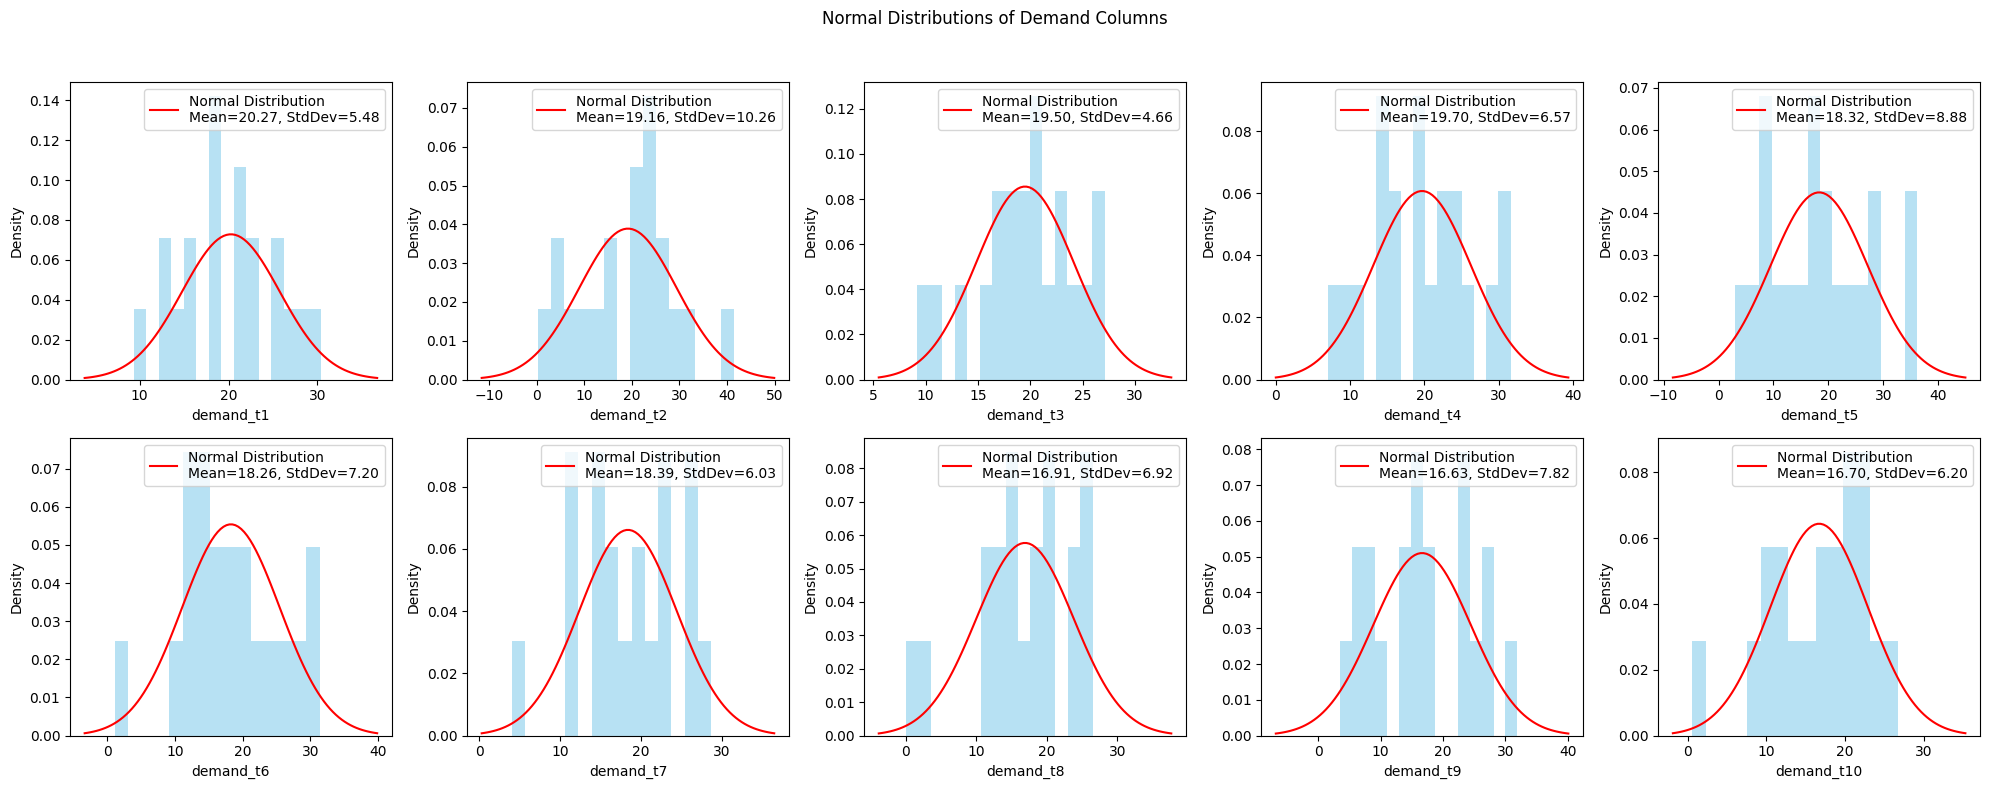

In [31]:
# 創建 2x5 的子圖網格
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Normal Distributions of Demand Columns")

for idx, column in enumerate(demand_df.columns):
    data = demand_df[column].dropna()  # 移除缺失值
    mean, std_dev = np.mean(data), np.std(data)

    # 產生 x 值範圍
    x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 100)
    pdf = norm.pdf(x, mean, std_dev)

    # 確定當前的軸位置
    ax = axes[idx // 5, idx % 5]
    ax.hist(data, bins=15, density=True, alpha=0.6, color="skyblue")
    ax.plot(
        x,
        pdf,
        "r-",
        label=f"Normal Distribution\nMean={mean:.2f}, StdDev={std_dev:.2f}",
    )
    ax.set_xlabel(column)
    ax.set_ylabel("Density")
    ax.legend()

# 移除空白子圖（若有）
for idx in range(len(demand_df.columns), 10):
    fig.delaxes(axes[idx // 5, idx % 5])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Validate the covariance


In [32]:
demand_df.cov()

demand_t1   demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
demand_t1   31.605758    9.410009   9.008299  23.418839  -4.494023  -1.921274   
demand_t2    9.410009  110.713541  32.737584  37.986075 -68.646732  -0.315299   
demand_t3    9.008299   32.737584  22.884960  11.210757  -7.086806  13.042622   
demand_t4   23.418839   37.986075  11.210757  45.420315 -24.102303  -5.430719   
demand_t5   -4.494023  -68.646732  -7.086806 -24.102303  82.986274  27.790421   
demand_t6   -1.921274   -0.315299  13.042622  -5.430719  27.790421  54.560109   
demand_t7   11.094547  -20.045194  -0.744349   2.696562  28.631149  28.134931   
demand_t8  -11.424254    7.990806  12.230793 -21.426177  16.327466  37.731898   
demand_t9   -7.739730   23.331571 -10.123994  19.172520 -17.939418 -19.254955   
demand_t10  -5.181547   -4.207789  -5.382893  -4.847938   7.334368   5.196337   

            demand_t7  demand_t8  demand_t9  demand_t10  
demand_t1   11.094547 -11.424254  -7.739730   -5.181547  
demand_t2  -20.045194   7.990806  23.331571   -4.207789  
demand_t3   -0.744349  12.230793 -10.123994   -5.382893  
demand_t4    2.696562 -21.426177  19.172520   -4.847938  
demand_t5   28.631149  16.327466 -17.939418    7.334368  
demand_t6   28.134931  37.731898 -19.254955    5.196337  
demand_t7   38.304137  16.845923   0.236322   21.666891  
demand_t8   16.845923  50.359005  -5.822027   20.489600  
demand_t9    0.236322  -5.822027  64.380476   30.196502  
demand_t10  21.666891  20.489600  30.196502   40.423365

In [33]:
empirical_covariance = demand_df.cov()
covariance_diff = np.abs(empirical_covariance - np.array(cov_matrices).mean(axis=0))
covariance_diff

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
demand_t1    9.764797   8.865692   8.407627   0.921305  11.330704   4.716476   
demand_t2    8.865692  45.992552   7.744691  20.208318  41.504524   5.772687   
demand_t3    8.407627   7.744691   1.227533   3.062267   6.162951  20.410789   
demand_t4    0.921305  20.208318   3.062267   3.841605   6.337722   2.185655   
demand_t5   11.330704  41.504524   6.162951   6.337722  42.634729  12.761427   
demand_t6    4.716476   5.772687  20.410789   2.185655  12.761427  13.649474   
demand_t7   14.486148   4.491348  13.710653   2.999150  18.492608   5.725970   
demand_t8    0.394035   4.393432  11.910376   3.821281   4.741548  17.046209   
demand_t9   10.585481  18.209383   1.699449  15.824384  12.251058   6.532907   
demand_t10   4.359252   1.805770   1.542326  14.475461  11.551043   0.550246   

            demand_t7  demand_t8  demand_t9  demand_t10  
demand_t1   14.486148   0.394035  10.585481    4.359252  
demand_t2    4.491348   4.393432  18.209383    1.805770  
demand_t3   13.710653  11.910376   1.699449    1.542326  
demand_t4    2.999150   3.821281  15.824384   14.475461  
demand_t5   18.492608   4.741548  12.251058   11.551043  
demand_t6    5.725970  17.046209   6.532907    0.550246  
demand_t7    9.767970  15.556008   0.540458    5.847708  
demand_t8   15.556008  11.720363   1.557096   15.536401  
demand_t9    0.540458   1.557096  30.352107   17.534669  
demand_t10   5.847708  15.536401  17.534669    3.014608

### Validate the corr matrix of damand_df is close to original setting


In [34]:
correlation_matrix = demand_df.corr()
print("Correlation Matrix from demand_df:")
correlation_matrix

Correlation Matrix from demand_df:


demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
demand_t1    1.000000   0.159077   0.334954   0.618098  -0.087750  -0.046267   
demand_t2    0.159077   1.000000   0.650386   0.535672  -0.716170  -0.004057   
demand_t3    0.334954   0.650386   1.000000   0.347724  -0.162619   0.369107   
demand_t4    0.618098   0.535672   0.347724   1.000000  -0.392582  -0.109092   
demand_t5   -0.087750  -0.716170  -0.162619  -0.392582   1.000000   0.413004   
demand_t6   -0.046267  -0.004057   0.369107  -0.109092   0.413004   1.000000   
demand_t7    0.318863  -0.307813  -0.025141   0.064649   0.507824   0.615440   
demand_t8   -0.286356   0.107017   0.360281  -0.448003   0.252567   0.719834   
demand_t9   -0.171580   0.276354  -0.263754   0.354550  -0.245430  -0.324884   
demand_t10  -0.144964  -0.062898  -0.176980  -0.113140   0.126632   0.110648   

            demand_t7  demand_t8  demand_t9  demand_t10  
demand_t1    0.318863  -0.286356  -0.171580   -0.144964  
demand_t2   -0.307813   0.107017   0.276354   -0.062898  
demand_t3   -0.025141   0.360281  -0.263754   -0.176980  
demand_t4    0.064649  -0.448003   0.354550   -0.113140  
demand_t5    0.507824   0.252567  -0.245430    0.126632  
demand_t6    0.615440   0.719834  -0.324884    0.110648  
demand_t7    1.000000   0.383560   0.004759    0.550627  
demand_t8    0.383560   1.000000  -0.102249    0.454128  
demand_t9    0.004759  -0.102249   1.000000    0.591920  
demand_t10   0.550627   0.454128   0.591920    1.000000

In [35]:
print(f"Original corr_matrix shape: {corr_matrix.shape}")
corr_matrix_df = pd.DataFrame(corr_matrix)
corr_matrix_df

Original corr_matrix shape: (10, 10)


0         1         2         3         4         5         6  \
0  1.000000  0.354243  0.555784  0.587411 -0.387774 -0.161484 -0.099073   
1  0.354243  1.000000  0.645671  0.344249 -0.533962 -0.118714 -0.366601   
2  0.555784  0.645671  1.000000  0.259728 -0.428492 -0.236520 -0.551543   
3  0.587411  0.344249  0.259728  1.000000 -0.433716 -0.078962  0.166233   
4 -0.387774 -0.533962 -0.428492 -0.433716  1.000000  0.371399  0.300310   
5 -0.161484 -0.118714 -0.236520 -0.078962  0.371399  1.000000  0.658292   
6 -0.099073 -0.366601 -0.551543  0.166233  0.300310  0.658292  1.000000   
7 -0.275944  0.072230  0.010563 -0.631022  0.294020  0.520508  0.038941   
8 -0.488891  0.109958 -0.414246  0.089139 -0.153719 -0.341738 -0.009772   
9 -0.020925 -0.049126 -0.128709  0.244177 -0.108549  0.147419  0.485870   

          7         8         9  
0 -0.275944 -0.488891 -0.020925  
1  0.072230  0.109958 -0.049126  
2  0.010563 -0.414246 -0.128709  
3 -0.631022  0.089139  0.244177  
4  0.294020 -0.153719 -0.108549  
5  0.520508 -0.341738  0.147419  
6  0.038941 -0.009772  0.485870  
7  1.000000 -0.203659  0.130487  
8 -0.203659  1.000000  0.355112  
9  0.130487  0.355112  1.000000

### Split test and train demand_df


In [36]:
def demand_data_split_data_k_fold(data, train_size, k_fold=2):
    folds = []
    for i in range(k_fold):
        train_data, test_data = train_test_split(
            data, train_size=train_size, random_state=i
        )
        test_data.reset_index(drop=True, inplace=True)
        train_data.reset_index(drop=True, inplace=True)
        folds.append((train_data, test_data))
    return folds

In [37]:
demand_folds = demand_data_split_data_k_fold(demand_df, train_size, k_fold=k_fold)

for i, (train, test) in enumerate(demand_folds):
    print(f"Fold {i + 1}:")
    print(f"Train size: {train.shape}, Test size: {test.shape}")
    print(f"train.head(): \n{train.head()}")
    print()

Fold 1:
Train size: (10, 10), Test size: (10, 10)
train.head(): 
   demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0  18.983674  30.433868  22.754177  19.626266  15.445056  14.812940   
1  16.322423  22.452494  19.626252  23.178855  10.412501  13.037681   
2  21.401028  19.942260  22.019712  14.568653  20.305671  14.752316   
3  26.678838  14.281307  19.702800  22.965390  26.224115  28.989238   
4  25.538998  19.581920  20.202805  14.902208   8.698713  18.426185   

   demand_t7  demand_t8  demand_t9  demand_t10  
0  14.774223  20.215903  23.568330   20.972546  
1   4.010334   3.472112   9.372295    0.588769  
2  14.939508  14.518569   6.879041    9.120182  
3  28.705340  20.867050  15.440646   19.501281  
4  20.560533  20.546294   3.481343   17.767353  

Fold 2:
Train size: (10, 10), Test size: (10, 10)
train.head(): 
   demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0  22.881244  21.479686  23.822757  25.394595  13.556896  15.407605   
1  18.

In [38]:
# # Only for testing
# demand_df_train = demand_df_test = demand_df

### Define the Q star(Q optimal)


In [39]:
def calculate_Q_star(demand_df, service_level=0.95):

    # 計算每一行的總和
    demand_sum = demand_df.sum(axis=1)

    # 計算總和的均值和標準差
    mean_sum = demand_sum.mean()
    std_sum = demand_sum.std()

    # 計算總和的95%百分位數值
    Q_star = norm.ppf(service_level, loc=mean_sum, scale=std_sum)

    # 打印結果
    print(f"mean of sum: {mean_sum}")
    print(f"std of sum: {std_sum}")
    print(f"{service_level*100} percentile of sum: {Q_star}")

    return Q_star

In [40]:
demand_df_train_1 = demand_folds[0][0]
Q_star = calculate_Q_star(demand_df_train_1, service_level=0.95)
print(f"Q_star: {Q_star}\n")

demand_df_train_2 = demand_folds[1][0]
Q_star = calculate_Q_star(demand_df_train_2, service_level=0.95)
print(f"Q_star: {Q_star}\n")

mean of sum: 175.24908843677085
std of sum: 28.677047050944203
95.0 percentile of sum: 222.41863328877443
Q_star: 222.41863328877443

mean of sum: 186.54543840132823
std of sum: 23.56924526932134
95.0 percentile of sum: 225.31339696708025
Q_star: 225.31339696708025



## Data3: Qk hat df


### Functions


In [41]:
# 計算條件分佈的函數
def calculate_conditional_distribution(mu, covariance_matrix, x_observed, k):
    mu_1 = mu[:k]
    mu_2 = mu[k:]
    Sigma_11 = covariance_matrix[:k, :k]
    Sigma_22 = covariance_matrix[k:, k:]
    Sigma_12 = covariance_matrix[k:, :k]
    Sigma_21 = covariance_matrix[:k, k:]

    # Compute conditional mean and covariance
    Sigma_11_inv = np.linalg.pinv(Sigma_11)
    mu_cond = mu_2 + np.dot(Sigma_12, np.dot(Sigma_11_inv, (x_observed - mu_1)))
    sigma_cond = Sigma_22 - np.dot(Sigma_12, np.dot(Sigma_11_inv, Sigma_21))

    return mu_cond, sigma_cond

In [42]:
def cal_Var_Y(sigma_cond):

    # Extract the variances (diagonal elements)
    variances = np.diag(sigma_cond)

    # Calculate the sum of covariances (off-diagonal elements)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)

    # Total variance for the sum of mu_cond
    total_variance = np.sum(variances) + covariances_sum

    return total_variance

In [43]:
def cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed):
    # predict_quantity = mu_cond + norm.ppf(service_level) * np.sqrt(np.diag(sigma_cond))
    # Qk_hat = x_observed.sum() + predict_quantity.sum()

    mean_Y = np.sum(mu_cond)
    var_Y = cal_Var_Y(sigma_cond)

    sd_Y = np.sqrt(var_Y)
    if sd_Y < 0 or np.isnan(sd_Y):  # scale must be positive
        sd_Y = 1e-6

    percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=sd_Y)

    # print(f"        mean_Y: {mean_Y}")
    # print(f"        sd_Y: {sd_Y}")
    # print(f"    percentile_95_Y: {percentile_95_Y}")

    Qk_hat = x_observed.sum() + percentile_95_Y
    return Qk_hat

In [44]:
def cal_mu_and_cov_matrix(demand_df_train):

    mu_matrix = demand_df_train.mean().values
    covariance_matrix = demand_df_train.cov().values

    # print(f"mu_matrix: {mu_matrix}")
    # print(f"covariance_matrix: \n{covariance_matrix}\n")

    return mu_matrix, covariance_matrix

In [45]:
def make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix):
    results_df = pd.DataFrame(index=demand_df.index)

    for index, row_data in demand_df.iterrows():
        for k in range(2, T):
            # print(f"Now processing index: {index}, t={k}")

            x_observed = row_data[
                : k - 1
            ].values  # 取出前 k 個觀測值 -> Qk_hat_2(t=2): 則 observerd: T=1

            mu_cond, sigma_cond = calculate_conditional_distribution(
                mu_matrix, covariance_matrix, x_observed, len(x_observed)
            )

            Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)

            results_df.loc[index, f"Qk_hat_k{k}"] = Qk_hat

            # print(f"    x_observed: {x_observed}")
            # print(f"    mu_cond: {mu_cond}")
            # print(f"    sigma_cond: \n{sigma_cond}")
            # print(f"    Qk_hat: {Qk_hat}")
            # print("\n")

    return results_df

公式連結：https://jujueffectivelife.notion.site/Qk-eab4d89ec36345efbf3a0d4a4f488474?pvs=4


### Validate the consistency of condMVN in Python and R


#### Given mu and sigma


In [46]:
from scipy.stats import multivariate_normal

# Define the mean vector and the covariance matrix
mu = np.array([10, 20, 30, 40])
covariance_matrix = np.array([[5, 1, 0, 2], [1, 8, 1, 0], [0, 1, 10, 1], [2, 0, 1, 7]])

# Mean and covariance partitioning
mu_1 = mu[:2]
mu_2 = mu[2:]
Sigma_11 = covariance_matrix[:2, :2]
Sigma_22 = covariance_matrix[2:, 2:]
Sigma_12 = covariance_matrix[2:, :2]
Sigma_21 = covariance_matrix[:2, 2:]

print(f"Sigma_11: \n{Sigma_11}\n")
print(f"Sigma_22: \n{Sigma_22}\n")
print(f"Sigma_12: \n{Sigma_12}\n")
print(f"Sigma_21: \n{Sigma_21}\n")

Sigma_11: 
[[5 1]
 [1 8]]

Sigma_22: 
[[10  1]
 [ 1  7]]

Sigma_12: 
[[0 1]
 [2 0]]

Sigma_21: 
[[0 2]
 [1 0]]



In [47]:
# Observed values of X1 and X2
x_observed = np.array([6, 30])

mu_cond, sigma_cond = calculate_conditional_distribution(
    mu, covariance_matrix, x_observed, len(x_observed)
)
print(f"mu_cond: {mu_cond}")
print(f"sigma_cond: \n{sigma_cond}")

mu_cond: [31.38461538 37.84615385]
sigma_cond: 
[[9.87179487 1.05128205]
 [1.05128205 6.17948718]]


In [48]:
# Define the conditional distribution
conditional_dist = multivariate_normal(mean=mu_cond, cov=sigma_cond)

# Values at which to evaluate the PDF and CDF
x3, x4 = 30, 40  # These can be any values of interest

# Calculate the PDF
pdf_value = conditional_dist.pdf([x3, x4])
print(f"Conditional density at X3 = {x3}, X4 = {x4}: {pdf_value}")

# Calculate the CDF
cdf_value = conditional_dist.cdf([x3, x4])
print(f"Conditional cumulative probability up to X3 = {x3}, X4 = {x4}: {cdf_value}")

# Qk hat
Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)
print(f"Qk_hat of x_observed: {Qk_hat}")

Conditional density at X3 = 30, X4 = 40: 0.012061749355189695
Conditional cumulative probability up to X3 = 30, X4 = 40: 0.2790601403798458
Qk_hat of x_observed: 112.23905144741786


```
R 中運行的結果
```

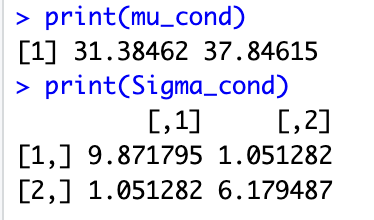
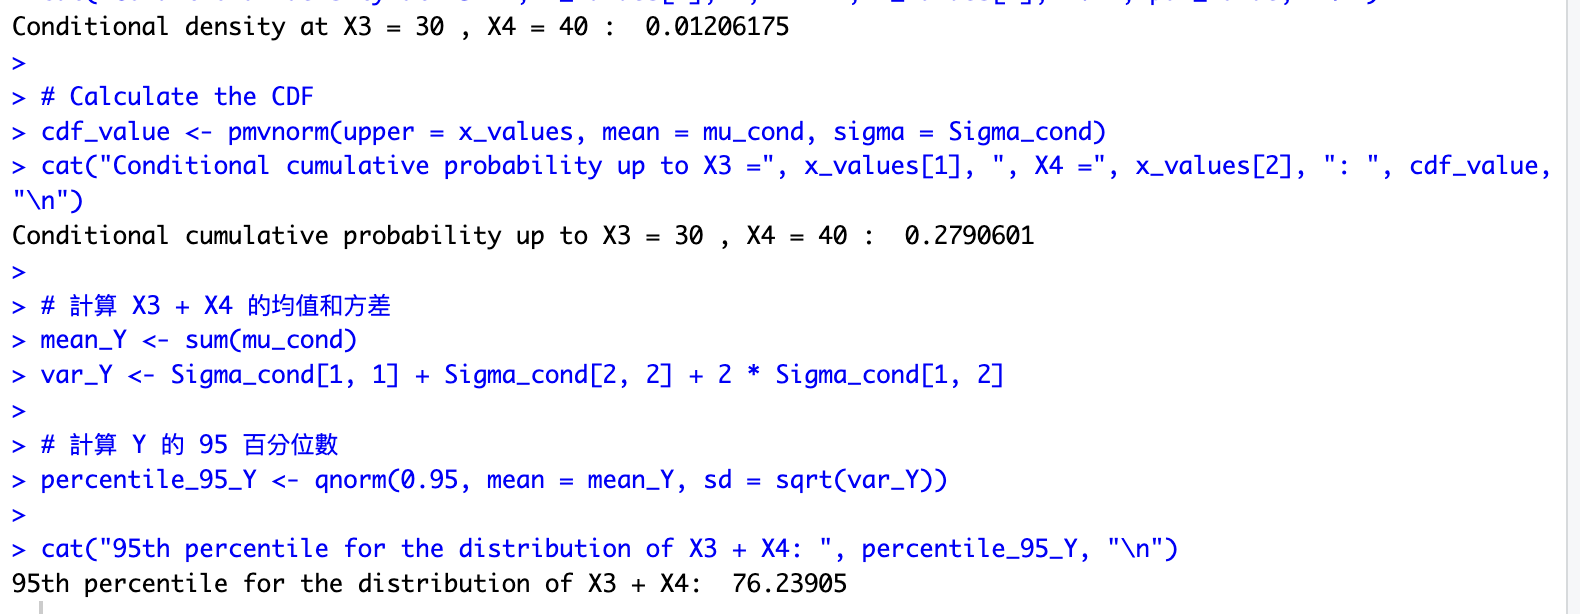


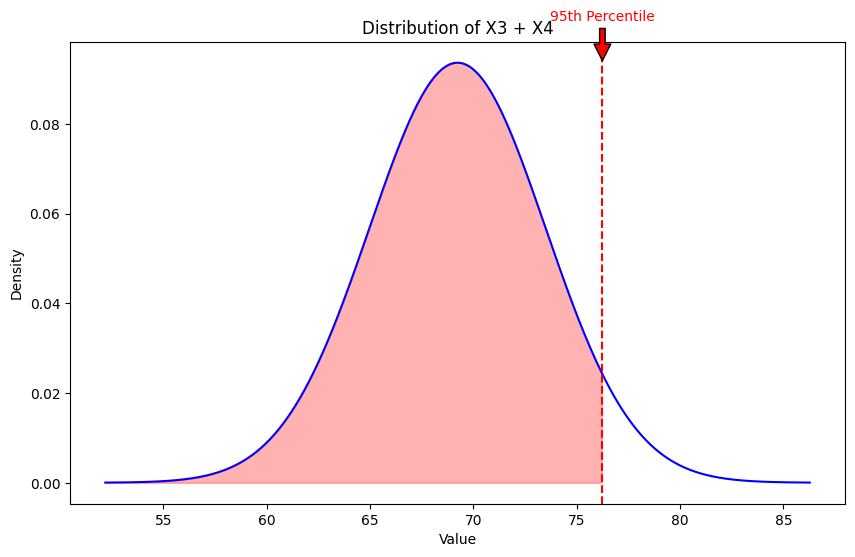

In [49]:
import matplotlib.pyplot as plt
from scipy.stats import norm

mean_Y = np.sum(mu_cond)
var_Y = cal_Var_Y(sigma_cond)

percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=np.sqrt(var_Y))

# Generate normal distribution data
x_values = np.linspace(mean_Y - 4 * np.sqrt(var_Y), mean_Y + 4 * np.sqrt(var_Y), 1000)
y_values = norm.pdf(x_values, loc=mean_Y, scale=np.sqrt(var_Y))

# Create dataframe
data = pd.DataFrame({"x": x_values, "y": y_values})

# Plot distribution
plt.figure(figsize=(10, 6))
plt.plot(data["x"], data["y"], color="blue")
plt.axvline(x=percentile_95_Y, color="red", linestyle="dashed")
plt.fill_between(
    data["x"], data["y"], where=(data["x"] <= percentile_95_Y), color="red", alpha=0.3
)
plt.title("Distribution of X3 + X4")
plt.xlabel("Value")
plt.ylabel("Density")
plt.annotate(
    "95th Percentile",
    xy=(percentile_95_Y, max(y_values)),
    xytext=(percentile_95_Y, max(y_values) * 1.1),
    arrowprops=dict(facecolor="red", shrink=0.05),
    color="red",
    ha="center",
)
plt.show()

```
以下為 R 程式結果
```


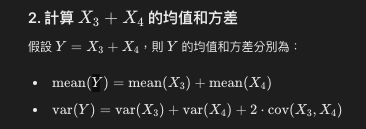


P(X3,X4∣X1=10,X2=20) 的 R 計算如下

```
install.packages("condMVNorm")
install.packages("mvtnorm")
library(condMVNorm)
library(mvtnorm)
library(ggplot2)

# Define the mean vector and covariance matrix
mu <- c(10, 20, 30, 40)
sigma <- matrix(c(
    5, 1, 0, 2,
    1, 8, 1, 0,
    0, 1, 10, 1,
    2, 0, 1, 7
), nrow = 4, byrow = TRUE)

# Observed values of X1 and X2
x_observed <- c(6, 30)

# Compute the conditional mean and covariance using condMVNorm
conditional_results <- condMVN(mean = mu, sigma = sigma, dependent.ind = c(3, 4), given.ind = c(1, 2), X.given = x_observed)

# Print the conditional mean and covariance
print(conditional_results$condMean)
print(conditional_results$condVar)

# Extract the conditional mean and covariance
mu_cond <- conditional_results$condMean
Sigma_cond <- conditional_results$condVar

# Print the conditional mean and covariance
print(mu_cond)
print(Sigma_cond)

# Values at which to evaluate the PDF and CDF
x_values <- c(30, 40)

# Calculate the PDF
pdf_value <- dmvnorm(x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional density at X3 =", x_values[1], ", X4 =", x_values[2], ": ", pdf_value, "\n")

# Calculate the CDF
cdf_value <- pmvnorm(upper = x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional cumulative probability up to X3 =", x_values[1], ", X4 =", x_values[2], ": ", cdf_value, "\n")

```


#### Conditional mean and variance


In [50]:
def cal_Var_Y(sigma_cond):
    variances = np.diag(sigma_cond)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)
    total_variance = np.sum(variances) + covariances_sum

    return total_variance


def simulate_Y(mu_cond, sigma_cond, num_samples=10000):
    samples = np.random.multivariate_normal(mu_cond, sigma_cond, num_samples)

    Y = samples[:, 0] + samples[:, 1]

    mean_Y = np.mean(Y)
    var_Y = np.var(Y)

    return mean_Y, var_Y


mu_cond = [2, 3]
sigma_cond = [[1, 0.5], [0.5, 1]]

mean_Y_formula = np.sum(mu_cond)
var_Y_formula = cal_Var_Y(sigma_cond)

mean_Y_simulated, var_Y_simulated = simulate_Y(mu_cond, sigma_cond)

print(f"公式計算的Y的均值: {mean_Y_formula}")
print(f"公式計算的Y的方差: {var_Y_formula}")
print(f"模擬計算的Y的均值: {mean_Y_simulated}")
print(f"模擬計算的Y的方差: {var_Y_simulated}")

公式計算的Y的均值: 5
公式計算的Y的方差: 3.0
模擬計算的Y的均值: 5.019062296389834
模擬計算的Y的方差: 2.9653345136351845


### Calculate Qk hat for 2~T-1 of demand_df_train


In [51]:
demand_df_train = demand_folds[0][0]

In [52]:
_, _ = cal_mu_and_cov_matrix(demand_df_train)

In [53]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df)
Qk_hat_df = make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix)

In [54]:
Qk_hat_df

Qk_hat_k2   Qk_hat_k3   Qk_hat_k4   Qk_hat_k5   Qk_hat_k6   Qk_hat_k7  \
0   229.955762  212.815551  215.476183  221.156222  231.896360  240.681748   
1   230.133088  233.142923  241.376869  242.845644  241.156486  246.315688   
2   242.295333  260.312294  258.398886  259.686709  243.310034  244.020431   
3   213.607295  218.445022  219.999281  222.524315  212.481851  202.464199   
4   235.166596  220.289707  197.717789  200.711326  164.840641  150.168001   
5   230.045148  238.822306  237.316131  233.444814  237.264177  218.917027   
6   224.735572  229.580224  209.602850  201.585801  197.357250  191.323414   
7   243.138330  232.611848  230.826142  230.621959  234.419329  245.802953   
8   230.225645  241.850586  222.996627  226.422483  235.584293  243.998650   
9   234.158233  231.201300  234.103140  226.384722  220.385120  201.724955   
10  219.976109  199.082477  191.190920  192.298202  202.417822  183.224785   
11  221.598313  203.510117  211.040328  206.671920  185.526672  187.266060   
12  234.536942  218.979024  212.766524  214.031972  191.448889  186.652607   
13  236.676793  234.867718  240.560242  245.209220  211.816961  200.354639   
14  225.517079  226.769988  224.311371  229.876212  199.728015  188.754528   
15  219.249461  222.889644  229.253240  221.470559  209.613221  198.329662   
16  241.198913  236.575391  232.854437  221.152156  187.668089  191.788581   
17  237.432127  226.499842  224.970866  218.234776  212.882793  220.030360   
18  249.547544  240.369379  238.183331  235.166372  251.021901  222.815313   
19  245.469261  247.539038  253.459909  258.653206  248.506600  230.581694   

     Qk_hat_k8   Qk_hat_k9  
0   212.527636  200.847408  
1   235.479160  229.775893  
2   226.925408  214.534333  
3   199.344651  205.660050  
4   128.351913  125.785902  
5   211.192171  204.566888  
6   171.404648  171.089580  
7   230.220081  224.600369  
8   242.187141  226.520691  
9   187.745660  165.254392  
10  187.938092  173.924536  
11  164.619364  160.983327  
12  199.447608  178.893877  
13  204.330837  203.347776  
14  143.426911  124.657971  
15  183.081020  167.228993  
16  186.746610  177.040498  
17  209.804317  207.642741  
18  195.098609  192.904786  
19  227.833902  221.275267

### Plot the distribuction


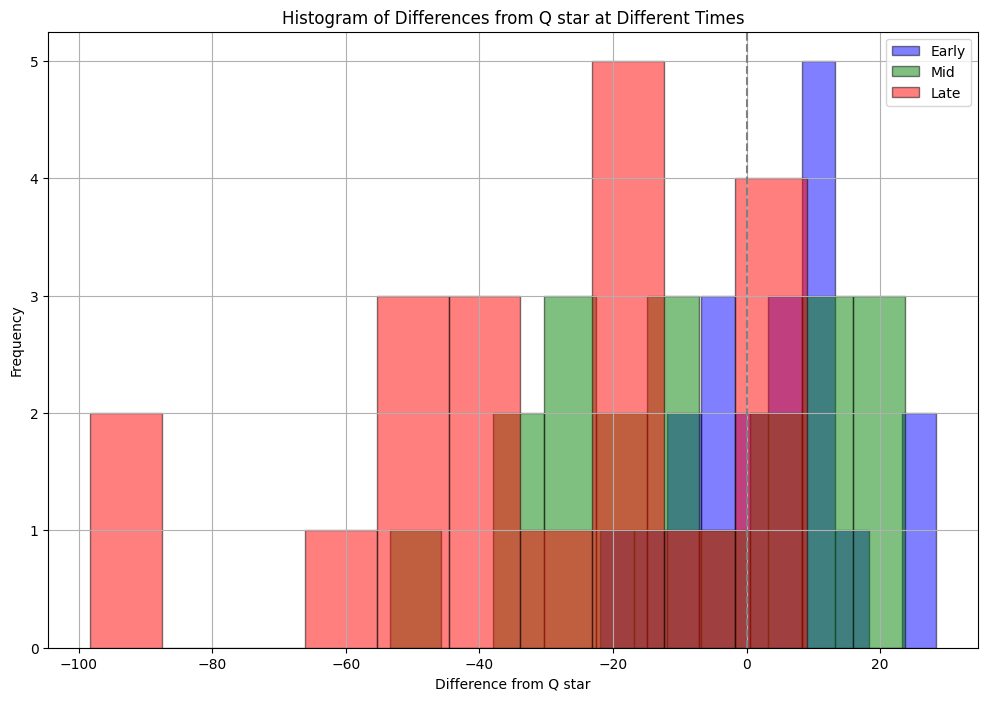

Q_star is: 225.31339696708025
Early bias: 3.8069861593013017
Mid bias: -8.268557160379794
Late bias: -32.207371597287036


In [55]:
# 將 T 個時期分成三份
early_values = Qk_hat_df.iloc[:, : T // 3].mean(axis=1)
mid_values = Qk_hat_df.iloc[:, T // 3 : 2 * T // 3].mean(axis=1)
late_values = Qk_hat_df.iloc[:, 2 * T // 3 :].mean(axis=1)

# 計算與 Q_star 的差距
early_diff = early_values - Q_star
mid_diff = mid_values - Q_star
late_diff = late_values - Q_star

# 繪製直方圖
plt.figure(figsize=(12, 8))

# 早期
plt.hist(early_diff, bins=10, alpha=0.5, label="Early", color="blue", edgecolor="black")
# 中期
plt.hist(mid_diff, bins=10, alpha=0.5, label="Mid", color="green", edgecolor="black")
# 晚期
plt.hist(late_diff, bins=10, alpha=0.5, label="Late", color="red", edgecolor="black")

plt.axvline(0, color="grey", linestyle="--")

plt.xlabel("Difference from Q star")
plt.ylabel("Frequency")
plt.title("Histogram of Differences from Q star at Different Times")
plt.legend()
plt.grid(True)
plt.show()

# 計算偏差
early_bias = np.mean(early_diff)
mid_bias = np.mean(mid_diff)
late_bias = np.mean(late_diff)

print(f"Q_star is: {Q_star}")
print(f"Early bias: {early_bias}")
print(f"Mid bias: {mid_bias}")
print(f"Late bias: {late_bias}")

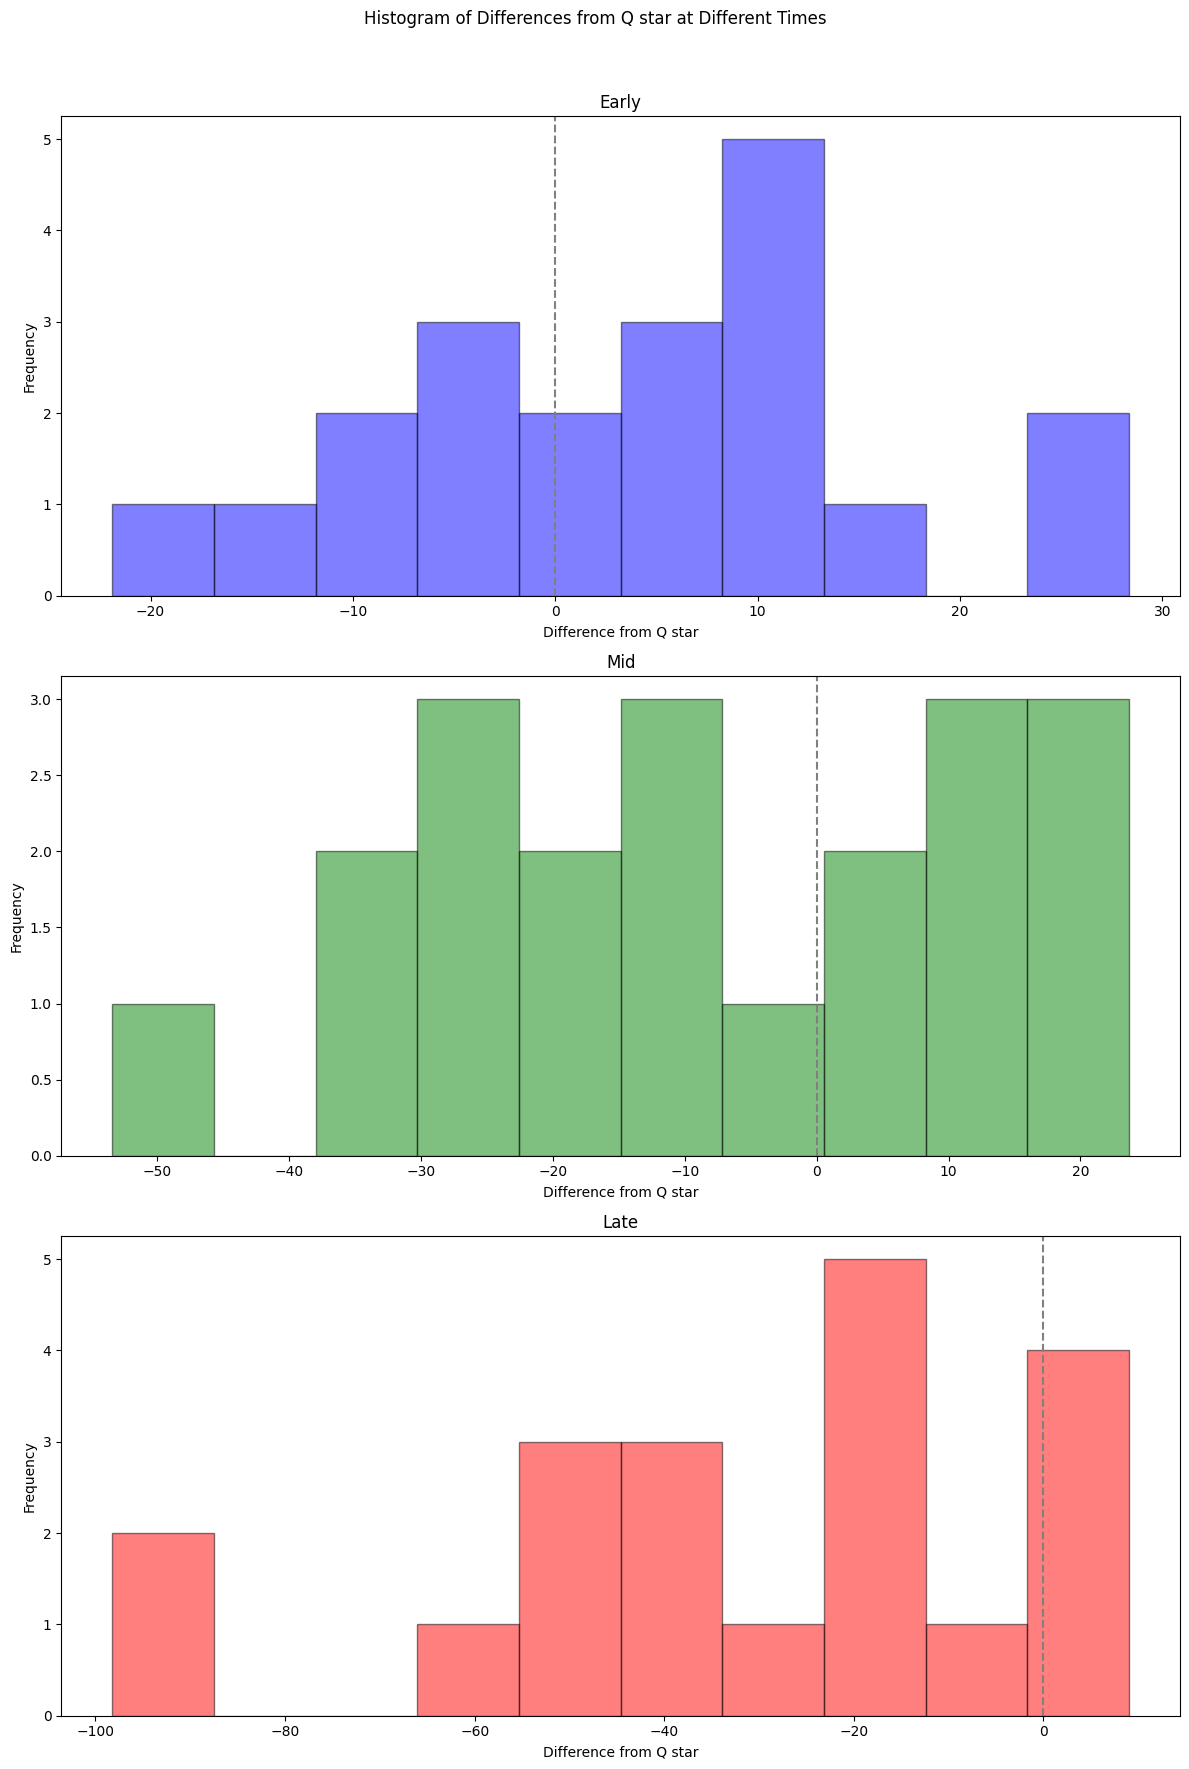

In [56]:
# 繪製直方圖
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# 早期
axes[0].hist(early_diff, bins=10, alpha=0.5, color="blue", edgecolor="black")
axes[0].axvline(0, color="grey", linestyle="--")
axes[0].set_title("Early")
axes[0].set_xlabel("Difference from Q star")
axes[0].set_ylabel("Frequency")

# 中期
axes[1].hist(mid_diff, bins=10, alpha=0.5, color="green", edgecolor="black")
axes[1].axvline(0, color="grey", linestyle="--")
axes[1].set_title("Mid")
axes[1].set_xlabel("Difference from Q star")
axes[1].set_ylabel("Frequency")

# 晚期
axes[2].hist(late_diff, bins=10, alpha=0.5, color="red", edgecolor="black")
axes[2].axvline(0, color="grey", linestyle="--")
axes[2].set_title("Late")
axes[2].set_xlabel("Difference from Q star")
axes[2].set_ylabel("Frequency")

fig.suptitle("Histogram of Differences from Q star at Different Times")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Strategies utils


## S0 - One-time Procurement


In [57]:
def one_time_procurement(Q_star, demand_df, cost, price, salvage_value, holding_cost):

    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []
    all_holding_costs = []

    for i, row in demand_df.iterrows():
        inventory = Q_star
        losses = []
        lefts = []
        daily_operation_profits = []
        daily_profits = []
        total_sold = 0  # 追蹤總售出量
        total_lost = 0  # 追蹤總丟失量
        holding_costs = 0  # 追蹤總持有成本

        print("=" * 50)
        print(
            f"Processing row {i+1}/{len(demand_df)} with initial inventory Q_star={Q_star}"
        )
        print("=" * 50)

        for day, demand in enumerate(row):
            sales = min(inventory, demand)
            loss = max(demand - inventory, 0)
            left = max(inventory - sales, 0)
            total_sold += sales
            total_lost += loss

            inventory -= sales
            holding_costs += holding_cost * inventory

            print("-" * 50)
            print(f"Day {day+1}")
            print(f"Demand      : {demand}")
            print(f"Sales       : {sales}")
            print(f"Loss        : {loss}")
            print(f"Left        : {left}")
            print(f"Inventory   : {inventory}")
            print(f"Holding Cost: {holding_costs}")
            print("-" * 50)

            if day == len(row) - 1:
                left_penalty_cost = (cost - salvage_value) * left
                lefts.append(left)
                print(f"End of period: Left Penalty Cost = {left_penalty_cost}")
                print("-" * 50)
            else:
                left_penalty_cost = 0

        operation_profit = (price - cost) * total_sold
        profit = (
            operation_profit
            - left_penalty_cost
            - ((price - cost) * total_lost)
            - holding_costs
        )

        print("=" * 50)
        print(f"Row {i+1} Summary")
        print(f"Total Sold         : {total_sold}")
        print(f"Total Lost         : {total_lost}")
        print(f"Operation Profit   : {operation_profit}")
        print(f"Profit             : {profit}")
        print("=" * 50)

        all_losses.append(total_lost)
        all_lefts.append(sum(lefts))
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)

    avg_losses = np.mean(all_losses)
    avg_lefts = np.mean(all_lefts)
    avg_operation_profits = np.mean(all_operation_profits)
    avg_profits = np.mean(all_profits)

    print("=" * 50)
    print("Overall Summary")
    print(f"Average Losses           : {avg_losses}")
    print(f"Average Lefts            : {avg_lefts}")
    print(f"Average Operation Profits: {avg_operation_profits}")
    print(f"Average Profits          : {avg_profits}")
    print("=" * 50)

    stimulation_df = pd.DataFrame(
        {
            "losses": all_losses,
            "lefts": all_lefts,
            "operation_profits": all_operation_profits,
            "profits": all_profits,
        }
    )

    return avg_losses, avg_lefts, avg_profits, avg_operation_profits, stimulation_df

## S1 - Grid for Fixed F & Fixed Rk


In [58]:
def cal_fixed_F_fixed_R(
    Q_star, assigned_F, assigned_R, demand_df, cost, price, salvage_value, Qk_hat_df
):
    all_losses = []
    all_lefts = []
    all_left0s = []
    all_left1s = []
    all_operation_profits = []
    all_profits = []
    all_q0s = []
    all_q1s = []

    Q0 = assigned_F * Q_star  # 期初庫存

    print(f"\n")
    print(f"====" * 10)
    print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = operation_profit - left_penalty_cost - lost_penalty_cost

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)
        all_q0s.append(Q0)
        all_q1s.append(Q1)
        all_left0s.append(left_0)
        all_left1s.append(left_1)

        print(f"這是第 {i+1} 筆模擬資料\n")
        print(f"F: {assigned_F}, R: {assigned_R+2}")
        print(f"Q_star 為 {Q_star}")
        print(f"期初庫存 Q0: {Q0}")
        print(f"重新估計量 Qk_hat: {Qk_hat}")
        print(f"訂貨量 Q1 為 {Q1}\n")

        print(
            f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}"
        )
        print(
            f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}\n"
        )
        print(
            f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，Profit 為 {profit}"
        )
        print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "operation_profits": all_operation_profits,
        "Q0": all_q0s,
        "Q1": all_q1s,
    }

    return result_df, stimulation_result

In [59]:
def grid_fixed_F_fixed_R(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    results_list = []
    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
            )
            results_list.append(mean_result)

            if max_profit is None or max_profit < mean_result["average_profits"]:
                print(
                    f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## S8 - Grid for Fixed F & Fixed Rk(with holding cost)


In [60]:
def cal_fixed_F_fixed_R_with_holding_cost(
    Q_star,
    assigned_F,
    assigned_R,
    demand_df,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    holding_cost,
):
    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []
    all_q0s = []
    all_q1s = []
    all_holding_costs_0 = []
    all_holding_costs_1 = []
    all_left0s = []
    all_left1s = []
    all_lost0s = []
    all_lost1s = []

    Q0 = assigned_F * Q_star  # 期初庫存

    print(f"\n")
    print(f"====" * 10)
    print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算 holding_cost
        """
        今天 T = 10, 假設 R = 5 (此時 assigned_R=3), 此時:
        第一階段是 T=1~4 -> 高為 R-1 = (assigned_R+2) - 1
        第二階段是 T=5~10 -> 高為 T - R = T - (assigned_R+2)
        """

        first_holding_cost = (Q0 + left_0 + Q1) * ((assigned_R + 2) - 1) / 2
        # T = 1 ~ R+1, R+1 才是代表 R(T)
        second_holding_cost = (Q1 + left_0 + left_1) * (T - (assigned_R + 2)) / 2
        # T = R+1 ~ T
        holding_penalty = holding_cost * (first_holding_cost + second_holding_cost)

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = (
            operation_profit - left_penalty_cost - lost_penalty_cost - holding_penalty
        )

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)
        all_q0s.append(Q0)
        all_q1s.append(Q1)
        all_holding_costs_0.append(first_holding_cost)
        all_holding_costs_1.append(second_holding_cost)
        all_left0s.append(left_0)
        all_left1s.append(left_1)
        all_lost0s.append(lost_0)
        all_lost1s.append(lost_1)

        # print(f"這是第 {i+1} 筆模擬資料\n")
        # print(f"F: {assigned_F}, R: {assigned_R+2}")
        # print(f"Q_star 為 {Q_star}")
        # print(f"期初庫存 Q0: {Q0}")
        # print(f"重新估計量 Qk_hat: {Qk_hat}")
        # print(f"訂貨量 Q1 為 {Q1}\n")

        # print(
        #     f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}, first_holding_cost 為 {first_holding_cost}"
        # )
        # print(
        #     f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}, second_holding_cost 為 {second_holding_cost}\n"
        # )
        # print(
        #     f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，holding_penalty 為 {holding_penalty}，Profit 為 {profit}"
        # )
        # print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "operation_profits": all_operation_profits,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "hc0": all_holding_costs_0,
        "hc1": all_holding_costs_1,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "lost0s": all_lost0s,
        "lost1s": all_lost1s,
    }

    return result_df, stimulation_result

In [61]:
def grid_fixed_F_fixed_R_with_holding_cost(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    holding_cost,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    results_list = []
    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R_with_holding_cost(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
                holding_cost,
            )
            results_list.append(mean_result)

            if max_profit is None or max_profit < mean_result["average_profits"]:
                print(
                    f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F


In [62]:
def cal_flexible_F_fixed_R(
    assigned_R,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            ## 只會有一個 R 為 1
            model.addConstr(R_vars[i, assigned_R] == 1, name=f"Set_R_{i}_0_To_1")
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 引入二進制變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")

            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i] - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(
                Sold_0s[i] >= Q0_vars[i] - M * Sold_0_binary, name=f"Sold_0_lb2_{i}"
            )

            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i]
                + Q0_vars[i]
                - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_lb2_{i}")
            model.addConstr(
                Left_0s[i] <= Q0_vars[i] - Sold_0s[i] + M * (1 - Left_0_binary),
                name=f"Left_0_ub1_{i}",
            )
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_ub2_{i}")

            # Lost_0 的線性化
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Lost_0_lb1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_lb2_{i}")
            model.addConstr(
                Lost_0s[i]
                <= total_demand_up_to_k_minus_1_vars[i]
                - Q0_vars[i]
                + M * (1 - Lost_0_binary),
                name=f"Lost_0_ub1_{i}",
            )
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_ub2_{i}")

            # Q1 + Left_0 平衡式
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Q1_plus_left_balance_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_ub1_{i}"
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub2_{i}")
            model.addConstr(
                Sold_1s[i]
                >= total_demand_from_k_to_T_vars[i]
                + Q1_plus_lefts[i]
                - M * (1 - Sold_1_binary),
                name=f"Sold_1_lb1_{i}",
            )
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_lb2_{i}")
            model.addConstr(
                Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i] + M * (1 - Left_1_binary),
                name=f"Left_1_ub1_{i}",
            )
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_ub2_{i}")

            # Lost_1 的線性化
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Lost_1_lb1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_lb2_{i}")
            model.addConstr(
                Lost_1s[i]
                <= total_demand_from_k_to_T_vars[i]
                - Q1_plus_lefts[i]
                + M * (1 - Lost_1_binary),
                name=f"Lost_1_ub1_{i}",
            )
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_ub2_{i}")

            # 計算 Holding_Cost_0
            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                alpha_values = np.array([alpha.X for key, alpha in alphas.items()])

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []
                all_sold0s = []
                all_sold1s = []
                all_demand_up = []
                all_demand_down = []
                all_Q1_plus_lefts = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    q1_plus_left = Q1_plus_lefts[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X
                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Qk_hat.append(Q_hats[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)
                    all_sold0s.append(sold0)
                    all_sold1s.append(sold1)
                    all_demand_up.append(total_demand_up)
                    all_demand_down.append(total_demand_down)
                    all_Q1_plus_lefts.append(q1_plus_left)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                    all_sold0s,
                    all_sold1s,
                    all_demand_up,
                    all_demand_down,
                    all_Q1_plus_lefts,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [63]:
def grid_flexible_F_fixed_R(
    assigned_Ts,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
    holding_cost,
):
    results_dict = {
        "R(T)": [],
        "R": [],
        "average_profits": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "alpha_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is T={assigned_T} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )

        assigned_R = assigned_T - 2
        result = cal_flexible_F_fixed_R(
            assigned_R=assigned_R,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
            holding_cost=holding_cost,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:

            (
                all_Rs,
                losses,
                lefts,
                profits,
                operation_profits,
                alpha_values,
                F_vars,
                Q0_vars,
                Q1_vars,
                holding_costs_0s,
                holding_costs_1s,
                all_left0s,
                all_left1s,
                all_lost0s,
                all_lost1s,
                all_Qk_hat,
                all_sold0s,
                all_sold1s,
                all_demand_up,
                all_demand_down,
                all_Q1_plus_lefts,
            ) = result

            # 计算平均值
            average_losses = sum(losses) / len(losses) if losses else 0
            average_lefts = sum(lefts) / len(lefts) if lefts else 0
            average_profits = sum(profits) / len(profits) if profits else 0
            average_operation_profits = (
                sum(operation_profits) / len(operation_profits)
                if operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["R(T)"].append(assigned_T)
            results_dict["R"].append([x - 2 for x in all_Rs])
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            results_dict["alpha_values"].append(alpha_values)
            results_dict["F_vars"].append(F_vars)
            results_dict["Q0_vars"].append(Q0_vars)  # 紀錄該策略組合每一次模擬的 Q0
            results_dict["Q1_vars"].append(Q1_vars)  # 紀錄該策略組合每一次模擬的 Q1

            print(f"The average profits is {average_profits}")

            if max_profit is None or max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R(T)": all_Rs,
                    "R": [x - 2 for x in all_Rs],
                    "F": F_vars,
                    "profits": profits,
                    "losses": losses,
                    "lefts": lefts,
                    "operation_profits": operation_profits,
                    "Q0": Q0_vars,
                    "Q1": Q1_vars,
                    "hc0": holding_costs_0s,
                    "hc1": holding_costs_1s,
                    "demand_up": all_demand_up,
                    "demand_down": all_demand_down,
                    "Sold0s": all_sold0s,
                    "Sold1s": all_sold1s,
                    "Left0s": all_left0s,
                    "Left1s": all_left1s,
                    "lost0s": all_lost0s,
                    "lost1s": all_lost1s,
                    "Qk_hat": all_Qk_hat,
                    "Q1_plus_lefts": all_Q1_plus_lefts,
                }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## S3 - Grid for Fixed F & Flexible Rk(with full beta)

In [64]:
def cal_fixed_F_flexible_R(
    assigned_F,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            model.addConstr(F_vars[i] == assigned_F)
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

                # 定義指數變數
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                # 設定約束條件
                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i]
                + Q0_vars[i]
                - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_lb2_{i}")
            model.addConstr(
                Left_0s[i] <= Q0_vars[i] - Sold_0s[i] + M * (1 - Left_0_binary),
                name=f"Left_0_ub1_{i}",
            )
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_ub2_{i}")

            # Lost_0 的線性化
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Lost_0_lb1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_lb2_{i}")
            model.addConstr(
                Lost_0s[i]
                <= total_demand_up_to_k_minus_1_vars[i]
                - Q0_vars[i]
                + M * (1 - Lost_0_binary),
                name=f"Lost_0_ub1_{i}",
            )
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_ub2_{i}")

            # Q1 + Left_0 平衡式
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Q1_plus_left_balance_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_ub1_{i}"
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub2_{i}")
            model.addConstr(
                Sold_1s[i]
                >= total_demand_from_k_to_T_vars[i]
                + Q1_plus_lefts[i]
                - M * (1 - Sold_1_binary),
                name=f"Sold_1_lb1_{i}",
            )
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_lb2_{i}")
            model.addConstr(
                Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i] + M * (1 - Left_1_binary),
                name=f"Left_1_ub1_{i}",
            )
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_ub2_{i}")

            # Lost_1 的線性化
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Lost_1_lb1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_lb2_{i}")
            model.addConstr(
                Lost_1s[i]
                <= total_demand_from_k_to_T_vars[i]
                - Q1_plus_lefts[i]
                + M * (1 - Lost_1_binary),
                name=f"Lost_1_ub1_{i}",
            )
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_ub2_{i}")

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                beta_values = np.array(
                    [[betas[i, j].X for j in range(features_num + 1)] for i in range(K)]
                )
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []
                all_sold0s = []
                all_sold1s = []
                all_demand_up = []
                all_demand_down = []
                all_Q1_plus_lefts = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    q1_plus_left = Q1_plus_lefts[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X
                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)
                    all_sold0s.append(sold0)
                    all_sold1s.append(sold1)
                    all_demand_up.append(total_demand_up)
                    all_demand_down.append(total_demand_down)
                    all_Q1_plus_lefts.append(q1_plus_left)
                    all_Qk_hat.append(Q_hats[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    beta_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                    all_sold0s,
                    all_sold1s,
                    all_demand_up,
                    all_demand_down,
                    all_Q1_plus_lefts,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [65]:
def grid_fixed_F_flexible_R(
    assigned_Fs,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
    holding_cost,
):
    results_dict = {
        "R(T)": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "average_profits": [],
        "beta_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
        "tau_values": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_F in assigned_Fs:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is F={assigned_F} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )
        result = cal_fixed_F_flexible_R(
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
            holding_cost=holding_cost,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:
            (
                all_Rs,
                all_losses,
                all_lefts,
                all_profits,
                all_operation_profits,
                all_Fs,
                all_Q0s,
                all_Q1s,
                beta_values,
                tau_values,
                all_holding_costs_0,
                all_holding_costs_1,
                all_left0s,
                all_left1s,
                all_lost0s,
                all_lost1s,
                all_Qk_hat,
                all_sold0s,
                all_sold1s,
                all_demand_up,
                all_demand_down,
                all_Q1_plus_lefts,
            ) = result

            # 计算平均值
            average_losses = sum(all_losses) / len(all_losses) if all_losses else 0
            average_lefts = sum(all_lefts) / len(all_lefts) if all_lefts else 0
            average_profits = sum(all_profits) / len(all_profits) if all_profits else 0
            average_operation_profits = (
                sum(all_operation_profits) / len(all_operation_profits)
                if all_operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["R(T)"].append(all_Rs)
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            results_dict["beta_values"].append(beta_values)
            results_dict["tau_values"].append(tau_values)
            results_dict["F_vars"].append(all_Fs)
            results_dict["Q0_vars"].append(all_Q0s)
            results_dict["Q1_vars"].append(all_Q1s)

            if max_profit is None or max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R(T)": all_Rs,
                    "R": [x - 2 for x in all_Rs],
                    "F": all_Fs,
                    "profits": all_profits,
                    "losses": all_losses,
                    "lefts": all_lefts,
                    "operation_profits": all_operation_profits,
                    "Q0": all_Q0s,
                    "Q1": all_Q1s,
                    "hc0": all_holding_costs_0,
                    "hc1": all_holding_costs_1,
                    "Left0s": all_left0s,
                    "Left1s": all_left1s,
                    "lost0s": all_lost0s,
                    "lost1s": all_lost1s,
                    "Qk_hat": all_Qk_hat,
                    "Sold0s": all_sold0s,
                    "Sold1s": all_sold1s,
                    "demand_up": all_demand_up,
                    "demand_down": all_demand_down,
                    "Q1_plus_lefts": all_Q1_plus_lefts,
                }

            print(f"beta_values: \n{beta_values}")

    print(max_profit_stimulation_result)

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## Fully flexible F & Rk


### S5 - Simple beta with softmax


In [66]:
def __fully_flexible_simple_beta_with_softmax_5(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(使用 softmax)
            exp_tau_vars = []
            for k in range(K):
                model.addConstr(
                    tau_vars[i, k] == betas[k, 0], name=f"tau_computation_{i}_{k}"
                )  # 只使用截距項

                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            for k in range(K):
                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i]
                + Q0_vars[i]
                - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_lb2_{i}")
            model.addConstr(
                Left_0s[i] <= Q0_vars[i] - Sold_0s[i] + M * (1 - Left_0_binary),
                name=f"Left_0_ub1_{i}",
            )
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_ub2_{i}")

            # Lost_0 的線性化
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Lost_0_lb1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_lb2_{i}")
            model.addConstr(
                Lost_0s[i]
                <= total_demand_up_to_k_minus_1_vars[i]
                - Q0_vars[i]
                + M * (1 - Lost_0_binary),
                name=f"Lost_0_ub1_{i}",
            )
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_ub2_{i}")

            # Q1 + Left_0 平衡式
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Q1_plus_left_balance_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_ub1_{i}"
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub2_{i}")
            model.addConstr(
                Sold_1s[i]
                >= total_demand_from_k_to_T_vars[i]
                + Q1_plus_lefts[i]
                - M * (1 - Sold_1_binary),
                name=f"Sold_1_lb1_{i}",
            )
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_lb2_{i}")
            model.addConstr(
                Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i] + M * (1 - Left_1_binary),
                name=f"Left_1_ub1_{i}",
            )
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_ub2_{i}")

            # Lost_1 的線性化
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Lost_1_lb1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_lb2_{i}")
            model.addConstr(
                Lost_1s[i]
                <= total_demand_from_k_to_T_vars[i]
                - Q1_plus_lefts[i]
                + M * (1 - Lost_1_binary),
                name=f"Lost_1_ub1_{i}",
            )
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_ub2_{i}")

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []
                all_sold0s = []
                all_sold1s = []
                all_demand_up = []
                all_demand_down = []
                all_Q1_plus_lefts = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    q1_plus_left = Q1_plus_lefts[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X
                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)
                    all_sold0s.append(sold0)
                    all_sold1s.append(sold1)
                    all_demand_up.append(total_demand_up)
                    all_demand_down.append(total_demand_down)
                    all_Q1_plus_lefts.append(q1_plus_left)
                    all_Qk_hat.append(Q_hats[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                    all_sold0s,
                    all_sold1s,
                    all_demand_up,
                    all_demand_down,
                    all_Q1_plus_lefts,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [67]:
def fully_flexible_simple_beta_with_softmax_5(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    result = __fully_flexible_simple_beta_with_softmax_5(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
        holding_cost=holding_cost,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            all_holding_costs_0,
            all_holding_costs_1,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
            all_Qk_hat,
            all_sold0s,
            all_sold1s,
            all_demand_up,
            all_demand_down,
            all_Q1_plus_lefts,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=all_holding_costs_0,
            holding_costs_1s=all_holding_costs_1,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
            all_Qk_hat=all_Qk_hat,
            all_sold0s=all_sold0s,
            all_sold1s=all_sold1s,
            all_demand_up=all_demand_up,
            all_demand_down=all_demand_down,
            all_Q1_plus_lefts=all_Q1_plus_lefts,
        )

### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [68]:
def __fully_flexible_simple_beta_with_softmax_6(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(softmax)
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0], name=f"tau_computation_{i}_{p}"
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i]
                + Q0_vars[i]
                - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_lb2_{i}")
            model.addConstr(
                Left_0s[i] <= Q0_vars[i] - Sold_0s[i] + M * (1 - Left_0_binary),
                name=f"Left_0_ub1_{i}",
            )
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_ub2_{i}")

            # Lost_0 的線性化
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Lost_0_lb1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_lb2_{i}")
            model.addConstr(
                Lost_0s[i]
                <= total_demand_up_to_k_minus_1_vars[i]
                - Q0_vars[i]
                + M * (1 - Lost_0_binary),
                name=f"Lost_0_ub1_{i}",
            )
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_ub2_{i}")

            # Q1 + Left_0 平衡式
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Q1_plus_left_balance_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_ub1_{i}"
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub2_{i}")
            model.addConstr(
                Sold_1s[i]
                >= total_demand_from_k_to_T_vars[i]
                + Q1_plus_lefts[i]
                - M * (1 - Sold_1_binary),
                name=f"Sold_1_lb1_{i}",
            )
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_lb2_{i}")
            model.addConstr(
                Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i] + M * (1 - Left_1_binary),
                name=f"Left_1_ub1_{i}",
            )
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_ub2_{i}")

            # Lost_1 的線性化
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Lost_1_lb1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_lb2_{i}")
            model.addConstr(
                Lost_1s[i]
                <= total_demand_from_k_to_T_vars[i]
                - Q1_plus_lefts[i]
                + M * (1 - Lost_1_binary),
                name=f"Lost_1_ub1_{i}",
            )
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_ub2_{i}")

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []
                all_sold0s = []
                all_sold1s = []
                all_demand_up = []
                all_demand_down = []
                all_Q1_plus_lefts = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    q1_plus_left = Q1_plus_lefts[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X
                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)
                    all_sold0s.append(sold0)
                    all_sold1s.append(sold1)
                    all_demand_up.append(total_demand_up)
                    all_demand_down.append(total_demand_down)
                    all_Q1_plus_lefts.append(q1_plus_left)
                    all_Qk_hat.append(Q_hats[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                    all_sold0s,
                    all_sold1s,
                    all_demand_up,
                    all_demand_down,
                    all_Q1_plus_lefts,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [69]:
def fully_flexible_simple_beta_with_softmax_6(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    result = __fully_flexible_simple_beta_with_softmax_6(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
        holding_cost=holding_cost,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            all_holding_costs_0,
            all_holding_costs_1,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
            all_Qk_hat,
            all_sold0s,
            all_sold1s,
            all_demand_up,
            all_demand_down,
            all_Q1_plus_lefts,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=all_holding_costs_0,
            holding_costs_1s=all_holding_costs_1,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
            all_Qk_hat=all_Qk_hat,
            all_sold0s=all_sold0s,
            all_sold1s=all_sold1s,
            all_demand_up=all_demand_up,
            all_demand_down=all_demand_down,
            all_Q1_plus_lefts=all_Q1_plus_lefts,
        )

### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [70]:
def __fully_flexible_simple_beta_with_softmax_7(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0] + f_vars[i],
                    name=f"tau_computation_{i}_{p}",
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i]
                + Q0_vars[i]
                - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_lb2_{i}")
            model.addConstr(
                Left_0s[i] <= Q0_vars[i] - Sold_0s[i] + M * (1 - Left_0_binary),
                name=f"Left_0_ub1_{i}",
            )
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_ub2_{i}")

            # Lost_0 的線性化
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Lost_0_lb1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_lb2_{i}")
            model.addConstr(
                Lost_0s[i]
                <= total_demand_up_to_k_minus_1_vars[i]
                - Q0_vars[i]
                + M * (1 - Lost_0_binary),
                name=f"Lost_0_ub1_{i}",
            )
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_ub2_{i}")

            # Q1 + Left_0 平衡式
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Q1_plus_left_balance_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_ub1_{i}"
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub2_{i}")
            model.addConstr(
                Sold_1s[i]
                >= total_demand_from_k_to_T_vars[i]
                + Q1_plus_lefts[i]
                - M * (1 - Sold_1_binary),
                name=f"Sold_1_lb1_{i}",
            )
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_lb2_{i}")
            model.addConstr(
                Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i] + M * (1 - Left_1_binary),
                name=f"Left_1_ub1_{i}",
            )
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_ub2_{i}")

            # Lost_1 的線性化
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Lost_1_lb1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_lb2_{i}")
            model.addConstr(
                Lost_1s[i]
                <= total_demand_from_k_to_T_vars[i]
                - Q1_plus_lefts[i]
                + M * (1 - Lost_1_binary),
                name=f"Lost_1_ub1_{i}",
            )
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_ub2_{i}")

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []
                all_sold0s = []
                all_sold1s = []
                all_demand_up = []
                all_demand_down = []
                all_Q1_plus_lefts = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    q1_plus_left = Q1_plus_lefts[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X
                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)
                    all_sold0s.append(sold0)
                    all_sold1s.append(sold1)
                    all_demand_up.append(total_demand_up)
                    all_demand_down.append(total_demand_down)
                    all_Q1_plus_lefts.append(q1_plus_left)
                    all_Qk_hat.append(Q_hats[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                    all_sold0s,
                    all_sold1s,
                    all_demand_up,
                    all_demand_down,
                    all_Q1_plus_lefts,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [71]:
def fully_flexible_simple_beta_with_softmax_7(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):
    result = __fully_flexible_simple_beta_with_softmax_7(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
        holding_cost=holding_cost,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            all_holding_costs_0,
            all_holding_costs_1,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
            all_Qk_hat,
            all_sold0s,
            all_sold1s,
            all_demand_up,
            all_demand_down,
            all_Q1_plus_lefts,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=all_holding_costs_0,
            holding_costs_1s=all_holding_costs_1,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
            all_Qk_hat=all_Qk_hat,
            all_sold0s=all_sold0s,
            all_sold1s=all_sold1s,
            all_demand_up=all_demand_up,
            all_demand_down=all_demand_down,
            all_Q1_plus_lefts=all_Q1_plus_lefts,
        )

### S4 - Beta with softmax


In [72]:
def __fully_flexible_beta_with_softmax_4(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

                # 定義指數變數
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                # 設定約束條件
                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i]
                + Q0_vars[i]
                - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_lb2_{i}")
            model.addConstr(
                Left_0s[i] <= Q0_vars[i] - Sold_0s[i] + M * (1 - Left_0_binary),
                name=f"Left_0_ub1_{i}",
            )
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_ub2_{i}")

            # Lost_0 的線性化
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Lost_0_lb1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_lb2_{i}")
            model.addConstr(
                Lost_0s[i]
                <= total_demand_up_to_k_minus_1_vars[i]
                - Q0_vars[i]
                + M * (1 - Lost_0_binary),
                name=f"Lost_0_ub1_{i}",
            )
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_ub2_{i}")

            # Q1 + Left_0 平衡式
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Q1_plus_left_balance_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_ub1_{i}"
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub2_{i}")
            model.addConstr(
                Sold_1s[i]
                >= total_demand_from_k_to_T_vars[i]
                + Q1_plus_lefts[i]
                - M * (1 - Sold_1_binary),
                name=f"Sold_1_lb1_{i}",
            )
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_lb2_{i}")
            model.addConstr(
                Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i] + M * (1 - Left_1_binary),
                name=f"Left_1_ub1_{i}",
            )
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_ub2_{i}")

            # Lost_1 的線性化
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Lost_1_lb1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_lb2_{i}")
            model.addConstr(
                Lost_1s[i]
                <= total_demand_from_k_to_T_vars[i]
                - Q1_plus_lefts[i]
                + M * (1 - Lost_1_binary),
                name=f"Lost_1_ub1_{i}",
            )
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_ub2_{i}")

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(features_num + 1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []
                all_sold0s = []
                all_sold1s = []
                all_demand_up = []
                all_demand_down = []
                all_Q1_plus_lefts = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    q1_plus_left = Q1_plus_lefts[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X
                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)
                    all_sold0s.append(sold0)
                    all_sold1s.append(sold1)
                    all_demand_up.append(total_demand_up)
                    all_demand_down.append(total_demand_down)
                    all_Q1_plus_lefts.append(q1_plus_left)
                    all_Qk_hat.append(Q_hats[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                    all_sold0s,
                    all_sold1s,
                    all_demand_up,
                    all_demand_down,
                    all_Q1_plus_lefts,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [73]:
def fully_flexible_beta_with_softmax_4(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    result = __fully_flexible_beta_with_softmax_4(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
        holding_cost=holding_cost,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            all_holding_costs_0,
            all_holding_costs_1,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
            all_Qk_hat,
            all_sold0s,
            all_sold1s,
            all_demand_up,
            all_demand_down,
            all_Q1_plus_lefts,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=all_holding_costs_0,
            holding_costs_1s=all_holding_costs_1,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
            all_Qk_hat=all_Qk_hat,
            all_sold0s=all_sold0s,
            all_sold1s=all_sold1s,
            all_demand_up=all_demand_up,
            all_demand_down=all_demand_down,
            all_Q1_plus_lefts=all_Q1_plus_lefts,
        )

# Testing Utils


## S1 - Grid for Fixed F & Fixed Rk


In [74]:
def cal_test_fixed_F_fixed_R(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
):

    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## S8 - Grid for Fixed F & Fixed Rk(with holding cost)


In [75]:
def cal_test_fixed_F_fixed_R_with_holding_cost(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
    holding_cost,
):

    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R_with_holding_cost(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
        holding_cost,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F


In [76]:
def cal_test_flexible_F_fixed_R(
    assigned_R,
    alphas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
    holding_cost,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    R_vars = np.zeros((n, K), dtype=int)  # Use dtype=int to represent binary 0/1 values

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Ensure only one `R` is set to 1 in each row by setting `assigned_R` to 1 and all others to 0
        R_vars[i, assigned_R] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    print(f"assigned_R: {assigned_R}")
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "R(T)": assigned_R + 2,
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": assigned_R + 2,
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## S3 - Grid for Fixed F & Flexible Rk(原s6)


In [77]:
def cal_test_fixed_F_flexible_R(
    assigned_F,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
    holding_cost,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        F_vars[i] = assigned_F
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        # Step 2: Calculate the exponentials of -tau_vars
        exp_tau_vars[i] = np.exp(-tau_vars[i])

        # Step 3: Softmax normalization
        sum_exp_tau = np.sum(exp_tau_vars[i])  # Sum of exponentials for normalization
        r_vars[i] = exp_tau_vars[i] / sum_exp_tau  # Normalize to get softmax

        max_r_index[i] = np.argmax(r_vars[i])
        R_vars[i, max_r_index[i]] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "beta_balues": [betas],
            "F": [assigned_F],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## Fully flexible F & Rk


### S5 - Simple beta with softmax


In [78]:
def cal_test_fully_flexible_simple_beta_with_softmax_5(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
    holding_cost,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = betas[k, 0]
            exp_tau_vars[i, k] = np.exp(-tau_vars[i, k])  # Calculate exp(-tau_vars)

        sum_exp_tau_vars = np.sum(
            exp_tau_vars[i]
        )  # Sum of all exp_tau_vars for normalization

        for k in range(K):
            r_vars[i, k] = exp_tau_vars[i, k] / sum_exp_tau_vars

        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [79]:
def cal_test_fully_flexible_simple_beta_with_softmax_6(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
    holding_cost,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0]  # Only intercept term is used
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate softmax-normalized r_vars
        sum_exp_tau_vars = (
            np.sum(exp_tau_vars[i]) + 1
        )  # Adding 1 as in the softmax denominator for the last element

        for p in range(K):
            if p == K - 1:
                # Set the last r_vars element to ensure the sum of all r_vars elements is 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 3: Find the maximum r_vars element and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [80]:
def cal_test_fully_flexible_simple_beta_with_softmax_7(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
    holding_cost,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas and f_vars
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0] + f_vars[i]
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate the sum of exp_tau_vars for softmax normalization
        sum_exp_tau_vars = np.sum(exp_tau_vars[i]) + 1  # Adding 1 for the last r_var

        # Step 3: Calculate r_vars with softmax normalization
        for p in range(K):
            if p == K - 1:
                # Last r_var element ensures all r_vars sum to 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 4: Find the index of the maximum r_vars and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S4 - Beta with softmax


In [81]:
def cal_test_fully_flexible_beta_with_softmax_4(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
    holding_cost,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars as a linear combination of X_data and betas
        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        # Step 2: Calculate the exponentials of -tau_vars
        exp_tau_vars[i] = np.exp(-tau_vars[i])

        # Step 3: Softmax normalization
        sum_exp_tau = np.sum(exp_tau_vars[i])  # Sum of exponentials for normalization
        r_vars[i] = exp_tau_vars[i] / sum_exp_tau  # Normalize to get softmax

        max_r_index[i] = np.argmax(r_vars[i])
        R_vars[i, max_r_index[i]] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

# Med Margin(P-C Med)


## Setting reasonable parameters


In [82]:
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))
CURRENT_TIMESTAMP

202411282053

In [83]:
status = "train"

service_lv = calculate_service_level(
    salvage_value=salvage_value, cost=cost, price=price
)
print(f"service_lv: {service_lv}")

service_lv: 0.5


In [84]:
training_df, testing_df = training_data_folds[0]
demand_df_train, demand_df_test = demand_folds[0]

In [85]:
training_df.shape

(10, 2)

In [86]:
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 175.24908843677085
std of sum: 28.677047050944203
50.0 percentile of sum: 175.24908843677085
Q_star: 175.24908843677085


In [87]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_train)
Qk_hat_df_train = make_Qk_hat_df(
    demand_df_train, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_train

Qk_hat_k2   Qk_hat_k3   Qk_hat_k4   Qk_hat_k5   Qk_hat_k6   Qk_hat_k7  \
0  175.870930  179.490340  179.427115  180.955252  209.639725  203.699012   
1  172.089380  173.370425  171.403030  179.412711  130.503939  125.357269   
2  179.305914  180.273904  182.668914  182.328929  179.288671  154.948456   
3  186.805510  186.626591  187.451703  196.226398  197.876850  211.105246   
4  185.185835  186.352293  186.126330  173.651638  159.657994  175.328048   
5  168.816679  164.774592  166.457132  160.235884  148.646034  147.632270   
6  162.143097  163.285335  161.684287  162.377977  176.817182  187.128540   
7  175.796282  172.742351  173.233653  184.040473  200.378437  205.258522   
8  166.855070  168.191845  170.298354  165.709941  166.189428  171.124685   
9  179.622187  177.383210  173.740366  167.551682  183.492624  170.908835   

    Qk_hat_k8   Qk_hat_k9  
0  195.220455  199.604133  
1  122.590615  121.973715  
2  160.144606  161.041901  
3  219.096858  220.959098  
4  171.663500  172.013472  
5  145.233923  152.180145  
6  194.196193  198.404981  
7  198.246200  194.219765  
8  172.474112  162.293632  
9  173.624421  169.800043

## Training


### S0 - One-time procurement strategy


In [88]:
(
    baseline_avg_losses,
    baseline_avg_lefts,
    baseline_avg_profits,
    baseline_avg_operation_profits,
    baseline_stimulation_df,
) = one_time_procurement(
    Q_star=Q_star,
    demand_df=demand_df_train,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    holding_cost=holding_cost,
)

print(f"baseline_profit: {baseline_avg_profits}")

Processing row 1/10 with initial inventory Q_star=175.24908843677085
--------------------------------------------------
Day 1
Demand      : 18.983673586286056
Sales       : 18.983673586286056
Loss        : 0
Left        : 156.2654148504848
Inventory   : 156.2654148504848
Holding Cost: 0.0
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 30.43386763296133
Sales       : 30.43386763296133
Loss        : 0
Left        : 125.83154721752348
Inventory   : 125.83154721752348
Holding Cost: 0.0
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 22.75417675011091
Sales       : 22.75417675011091
Loss        : 0
Left        : 103.07737046741256
Inventory   : 103.07737046741256
Holding Cost: 0.0
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 19.62626640176582
Sales       : 19.626266401

In [89]:
baseline_stimulation_df

losses      lefts  operation_profits       profits
0  26.337894   0.000000       87624.544218  74455.597418
1   0.000000  52.775372       61236.858326  34849.172434
2   0.000000  16.802149       79223.469620  70822.395022
3  48.106917   0.000000       87624.544218  63571.085620
4   0.000000   5.542737       84853.175660  82081.807102
5   0.000000  21.233832       77007.628022  66390.711825
6  20.900454   0.000000       87624.544218  77174.317087
7  16.323972   0.000000       87624.544218  79462.558172
8   0.000000  11.097745       82075.671901  76526.799583
9   0.000000   4.217402       85515.843205  83407.142191

### S1 - Grid for Fixed F & Fixed Rk


In [90]:
results_df_1, stimulation_results_df_1 = None, None

results_df_1, stimulation_results_df_1 = grid_fixed_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    assigned_Fs=ASSIGNED_FS,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    Qk_hat_df=Qk_hat_df_train,
    demand_df_train=demand_df_train,
    Q_star=Q_star,
)
results_df_1





這是第 1 筆模擬資料

F: 0.1, R: 2
Q_star 為 175.24908843677085
期初庫存 Q0: 17.524908843677085
重新估計量 Qk_hat: 175.87093048479875
訂貨量 Q1 為 158.34602164112167

第一階段：期初庫存 Q0: 17.524908843677085，需求量為 18.983673586286056，Sold_0 為 17.524908843677085，Left_0 為 0.0，Lost_0 為 1.4587647426089703
第二階段：期初庫存 Q1+left_0 為 158.34602164112167，需求量為 182.60330845158398，Sold_1 為 158.34602164112167，Left_1 為 0.0，Lost_1 為 24.25728681046232

統計結果：Sold 為 175.87093048479875, Lost 為 25.71605155307129 Left_Penalty_Cost 為 0.0，Lost_Penalty_Cost 為 12858.025776535644，Profit 為 75077.43946586372
----------------------------------------
這是第 2 筆模擬資料

F: 0.1, R: 2
Q_star 為 175.24908843677085
期初庫存 Q0: 17.524908843677085
重新估計量 Qk_hat: 172.0893796836034
訂貨量 Q1 為 154.56447083992632

第一階段：期初庫存 Q0: 17.524908843677085，需求量為 16.322423343851618，Sold_0 為 16.322423343851618，Left_0 為 1.2024854998254675，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 155.76695633975177，需求量為 106.15129330878364，Sold_1 為 106.15129330878364，Left_1 為 49.615663030968136，Lost_1 為 0

統計結果





這是第 1 筆模擬資料

F: 0.2, R: 4
Q_star 為 175.24908843677085
期初庫存 Q0: 35.04981768735417
重新估計量 Qk_hat: 179.42711518797898
訂貨量 Q1 為 144.37729750062482

第一階段：期初庫存 Q0: 35.04981768735417，需求量為 72.1717179693583，Sold_0 為 35.04981768735417，Left_0 為 0.0，Lost_0 為 37.12190028200413
第二階段：期初庫存 Q1+left_0 為 144.37729750062482，需求量為 129.41526406851173，Sold_1 為 129.41526406851173，Left_1 為 14.962033432113088，Lost_1 為 0

統計結果：Sold 為 164.4650817558659, Lost 為 37.12190028200413 Left_Penalty_Cost 為 7481.016716056544，Lost_Penalty_Cost 為 18560.950141002064，Profit 為 56190.57402087434
----------------------------------------
這是第 2 筆模擬資料

F: 0.2, R: 4
Q_star 為 175.24908843677085
期初庫存 Q0: 35.04981768735417
重新估計量 Qk_hat: 171.40303044779094
訂貨量 Q1 為 136.35321276043678

第一階段：期初庫存 Q0: 35.04981768735417，需求量為 58.40116922225633，Sold_0 為 35.04981768735417，Left_0 為 0.0，Lost_0 為 23.351351534902157
第二階段：期初庫存 Q1+left_0 為 136.35321276043678，需求量為 64.07254743037895，Sold_1 為 64.07254743037895，Left_1 為 72.28066533005783，Lost_1 為 0

統計

R(T)    F                                                 Q0  \
62     8  0.9  [157.72417959309377, 157.72417959309377, 157.7...   
52     7  0.8  [140.19927074941668, 140.19927074941668, 140.1...   
53     7  0.9  [157.72417959309377, 157.72417959309377, 157.7...   
51     7  0.7  [122.6743619057396, 122.6743619057396, 122.674...   
42     6  0.7  [122.6743619057396, 122.6743619057396, 122.674...   
..   ...  ...                                                ...   
55     8  0.2  [35.04981768735417, 35.04981768735417, 35.0498...   
65     9  0.3  [52.57472653103126, 52.57472653103126, 52.5747...   
54     8  0.1  [17.524908843677085, 17.524908843677085, 17.52...   
64     9  0.2  [35.04981768735417, 35.04981768735417, 35.0498...   
63     9  0.1  [17.524908843677085, 17.524908843677085, 17.52...   

                                                   Q1  average_profits  \
62  [37.49627560136034, 0, 2.420426656327521, 61.3...     82521.944270   
52  [63.49974164437762, 0, 14.749185200119626, 70....     82191.031780   
53  [45.97483280070054, 0, 0, 53.381065967590644, ...     82045.211099   
51  [81.0246504880547, 2.6829075897445307, 32.2740...     81400.964576   
42  [86.96536356237078, 7.829576899723577, 56.6143...     78590.179784   
..                                                ...              ...   
55  [160.17063750709994, 87.5407973041255, 125.094...    -54507.409255   
65  [147.02940690000702, 69.39898847739705, 108.46...    -55583.948003   
54  [177.69554635077702, 105.06570614780259, 142.6...    -80794.772521   
64  [164.55431574368413, 86.92389732107415, 125.99...    -81871.311268   
63  [182.0792245873612, 104.44880616475123, 143.51...   -108158.674534   

    average_losses  average_lefts  average_operation_profits  
62        1.814273       6.576655               86717.407915  
52        3.127608       4.611808               86060.740093  
53        2.211737       6.735192               86518.675563  
51        4.149053       4.149053               85550.017671  
42        6.022910       6.022910               84613.089407  
..             ...            ...                        ...  
55       94.754636      94.754636               40247.226394  
65       95.472328      95.472328               39888.380145  
54      112.279544     112.279544               31484.771972  
64      112.997237     112.997237               31125.925723  
63      130.522146     130.522146               22363.471301  

[72 rows x 8 columns]

In [91]:
stimulation_results_df_1

R(T)    F       profits    losses      lefts     Left0s     Left1s  \
0     8  0.9  94426.964176  6.366527   0.000000  20.893976   0.000000   
1     8  0.9  43611.626856  0.000000  35.250463  48.683639  35.250463   
2     8  0.9  78374.636116  0.000000   1.697667  29.795032   1.697667   
3     8  0.9  99073.301849  9.822850   5.563702   0.000000   5.563702   
4     8  0.9  83874.601424  0.000000   1.957148  29.812818   1.957148   
5     8  0.9  75153.166247  0.000000   3.708924  45.032110   3.708924   
6     8  0.9  96121.421887  1.953349   0.000000  38.189246   0.000000   
7     8  0.9  92449.960399  0.000000   6.673140   3.257697   6.673140   
8     8  0.9  77914.287864  0.000000   8.322768  40.954756   8.322768   
9     8  0.9  84219.475882  0.000000   2.592735  32.400838   2.592735   

   operation_profits         Q0         Q1  
0       97610.227597  157.72418  37.496276  
1       61236.858326  157.72418   0.000000  
2       79223.469620  157.72418   2.420427  
3      106766.577937  157.72418  61.372679  
4       84853.175660  157.72418  13.939320  
5       77007.628022  157.72418   0.000000  
6       97098.096618  157.72418  36.472014  
7       95786.530265  157.72418  40.522021  
8       82075.671901  157.72418  14.749932  
9       85515.843205  157.72418  15.900241

In [92]:
# 比較結果
max_profit = results_df_1["average_profits"].max()

print("\n============ Below is the comparison results =================")
print(f"Q_star: {Q_star}")
print(f"Maximum Profit: {max_profit}")


============ Below is the comparison results =================
Q_star: 175.24908843677085
Maximum Profit: 82521.94427004398


In [93]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_1.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "F", "average_profits"]]
top_three_info

R(T)    F  average_profits
62     8  0.9     82521.944270
52     7  0.8     82191.031780
53     7  0.9     82045.211099

Plot saved as plots/grid_fixed_F_fixed_R_metrics_train_linear_constraint_med_with_holding_cost_0_20_202411282053.png


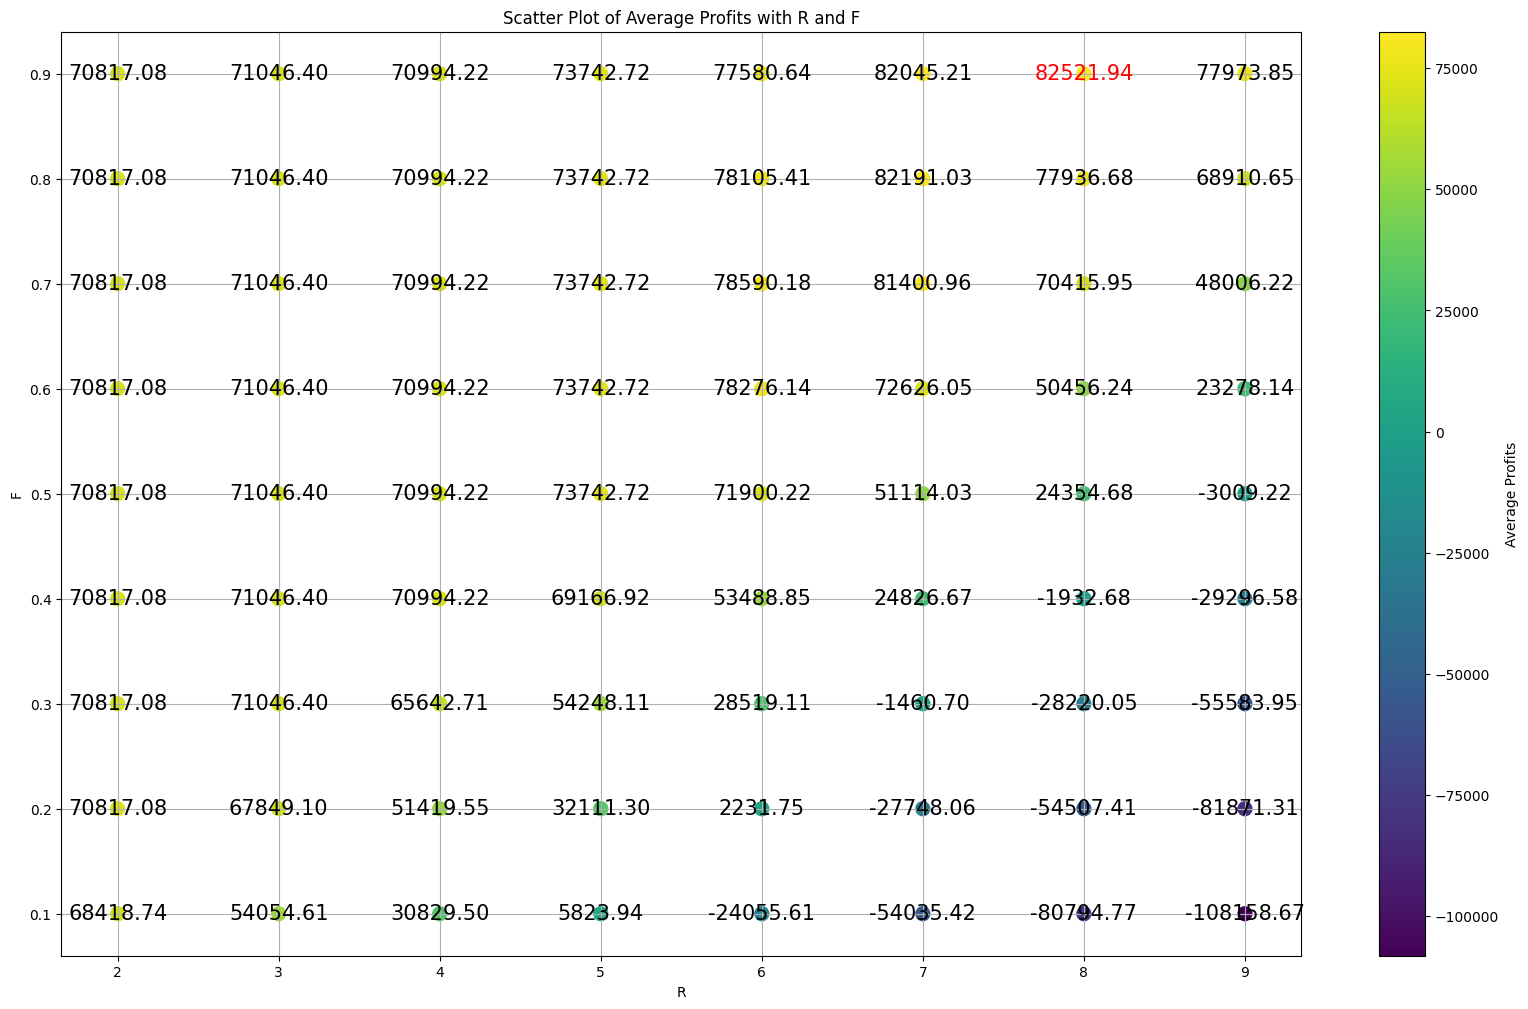

In [94]:
# 找到 'average_profits' 的最大值
max_profit = results_df_1["average_profits"].max()

# 画出散点图
plt.figure(figsize=(20, 12))
sc = plt.scatter(
    results_df_1["R(T)"],
    results_df_1["F"],
    c=results_df_1["average_profits"],
    cmap="viridis",
    s=100,
)
plt.colorbar(label="Average Profits")
plt.xlabel("R")
plt.ylabel("F")
plt.title("Scatter Plot of Average Profits with R and F")
plt.grid(True)

# 在每个数据点上标注数值
for i in range(len(results_df_1)):
    avg_profit = results_df_1["average_profits"].iloc[i]
    # 判断是否等于 max_profit 的整數部分
    if int(avg_profit) == int(max_profit):
        plt.text(
            results_df_1["R(T)"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="red",
        )
    else:
        plt.text(
            results_df_1["R(T)"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="black",
        )

name = "grid_fixed_F_fixed_R_metrics"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

Plot saved as plots/grid_fixed_F_fixed_R_trend_train_linear_constraint_med_with_holding_cost_0_20_202411282053.png


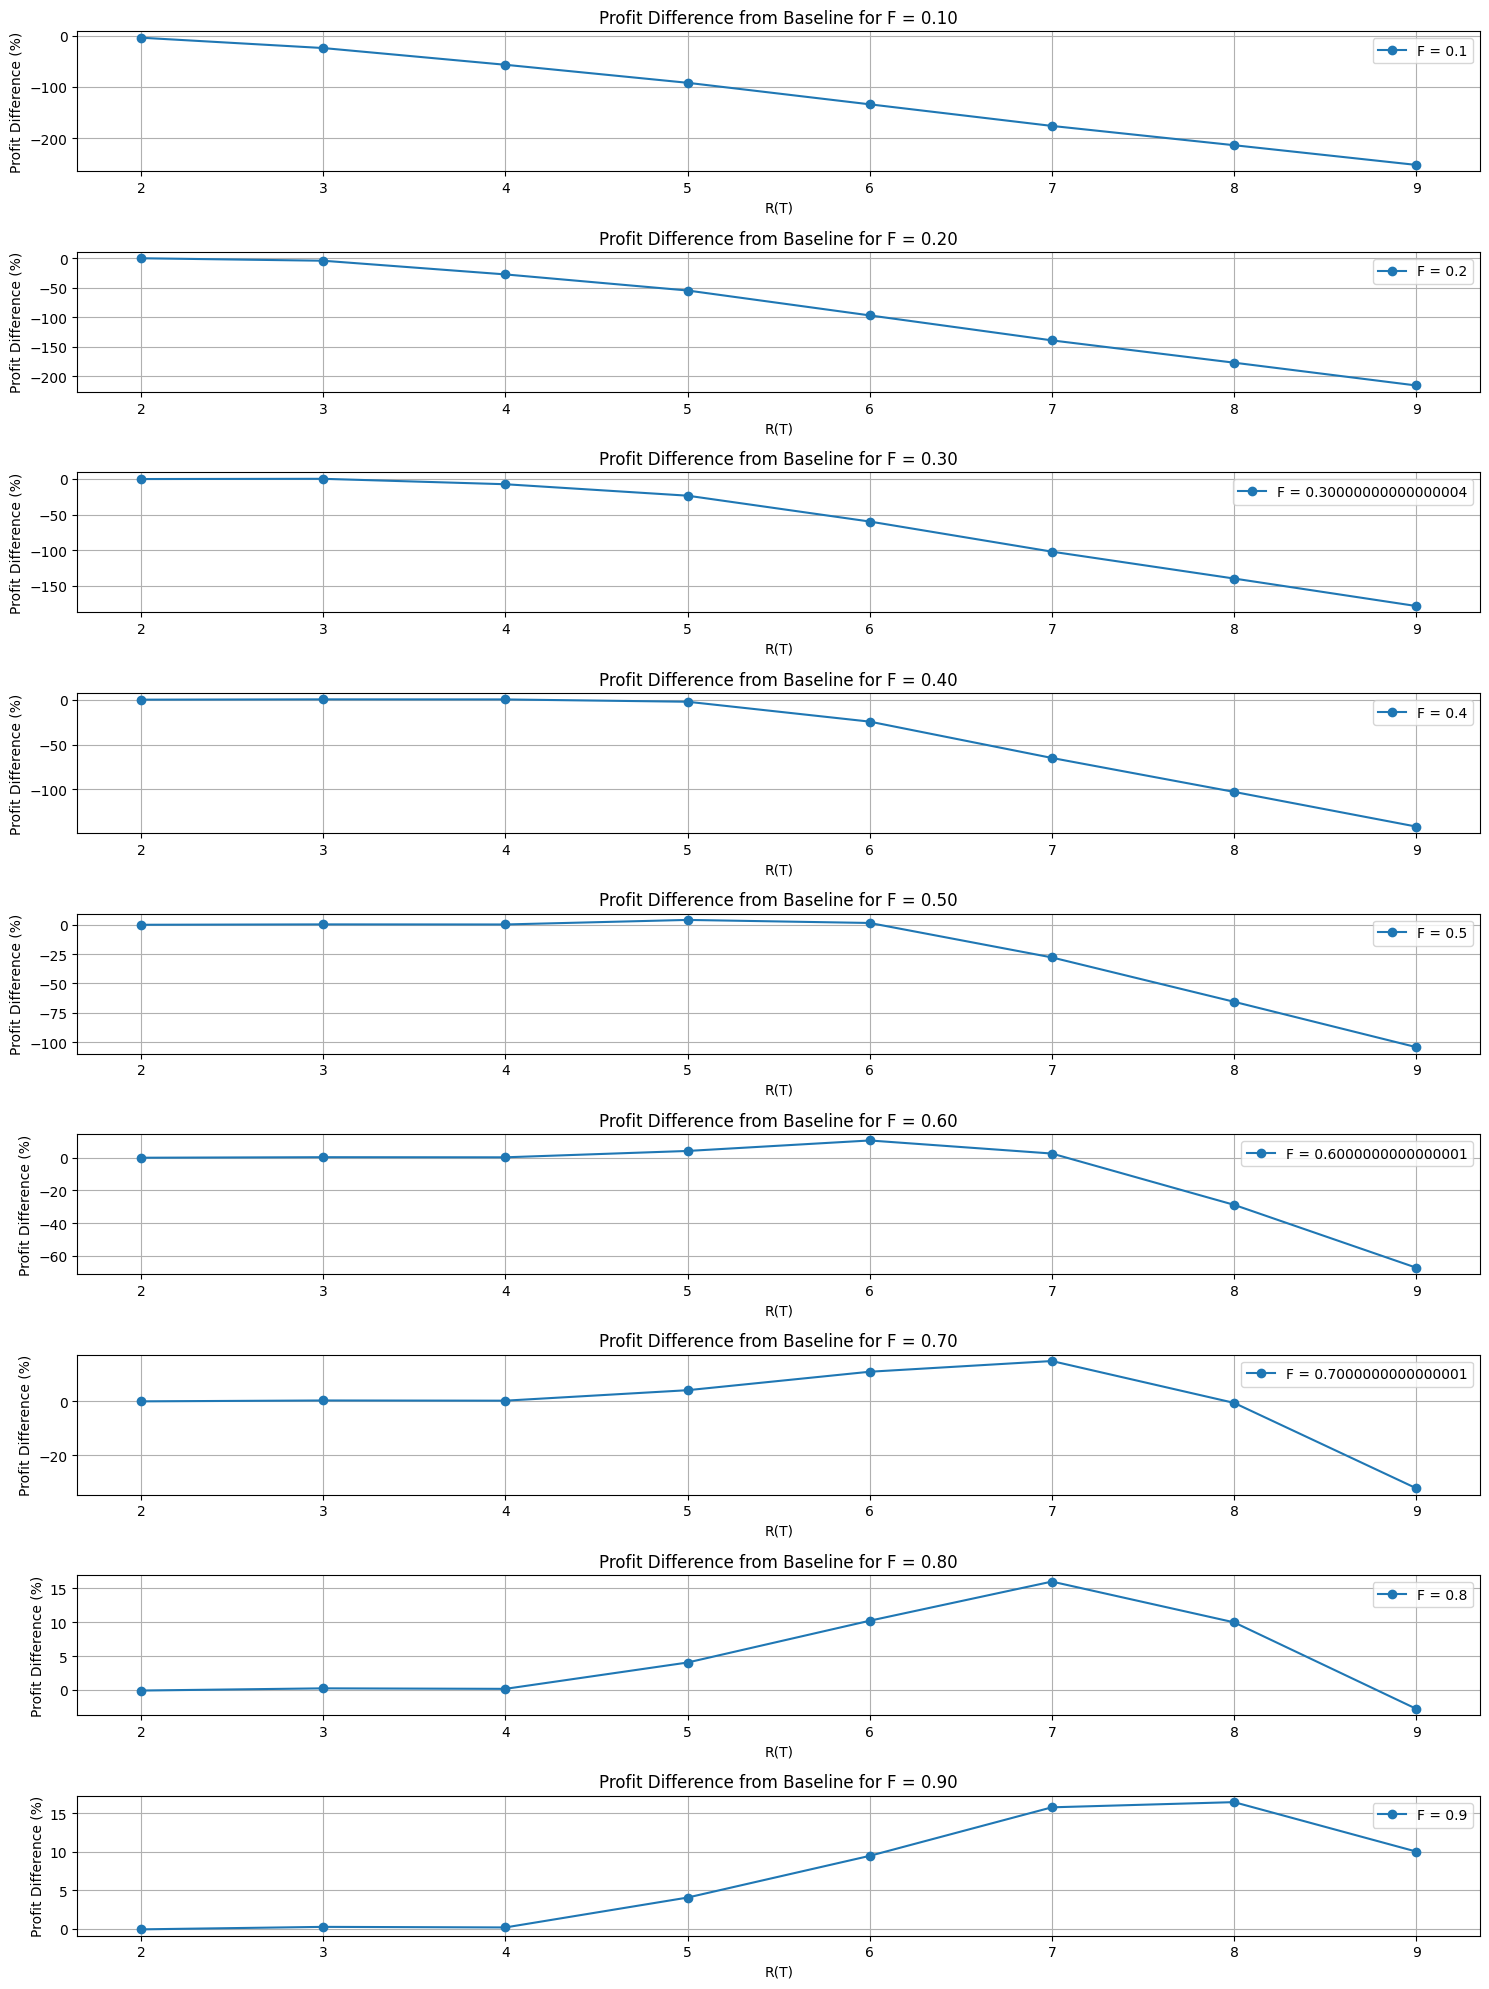

In [95]:
results_df_1["baseline_profit"] = baseline_avg_profits

# Calculate percentage difference from baseline profit
results_df_1["profit_diff_percent"] = (
    (results_df_1["average_profits"] - baseline_avg_profits) / baseline_avg_profits
) * 100

# Plot subplots for different values of F
plt.figure(figsize=(15, 20))

for idx, F in enumerate(ASSIGNED_FS):
    plt.subplot(len(ASSIGNED_FS), 1, idx + 1)
    subset = results_df_1[results_df_1["F"] == F].sort_values(by="R(T)").dropna()
    plt.plot(
        subset["R(T)"],
        subset["profit_diff_percent"],
        marker="o",
        linestyle="-",
        label=f"F = {F}",
    )
    plt.xlabel("R(T)")
    plt.ylabel("Profit Difference (%)")
    plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()

name = "grid_fixed_F_fixed_R_trend"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

### S8 - Grid for Fixed F & Fixed Rk


In [96]:
results_df_8, stimulation_results_df_8 = None, None

results_df_8, stimulation_results_df_8 = grid_fixed_F_fixed_R_with_holding_cost(
    assigned_Ts=ASSIGNED_TS,
    assigned_Fs=ASSIGNED_FS,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    Qk_hat_df=Qk_hat_df_train,
    demand_df_train=demand_df_train,
    Q_star=Q_star,
    holding_cost=holding_cost,
)
results_df_8





max_profit is changed from None to 68418.74295577493




max_profit is changed from 68418.74295577493 to 70817.0785609174








































max_profit is changed from 70817.0785609174 to 71046.39799758712




max_profit is changed from 71046.39799758712 to 71046.39799758713












































































max_profit is changed from 71046.39799758713 to 73742.71980173854








































max_profit is changed from 73742.71980173854 to 78276.14165596917




max_profit is changed from 78276.14165596917 to 78590.17978444719




































max_profit is changed from 78590.17978444719 to 81400.9645762651




max_profit is changed from 81400.9645762651 to 82191.03177982








































max_profit is changed from 82191.03177982 to 82521.94427004398






































R(T)    F                                                 Q0  \
62     8  0.9  [157.72417959309377, 157.72417959309377, 157.7...   
52     7  0.8  [140.19927074941668, 140.19927074941668, 140.1...   
53     7  0.9  [157.72417959309377, 157.72417959309377, 157.7...   
51     7  0.7  [122.6743619057396, 122.6743619057396, 122.674...   
42     6  0.7  [122.6743619057396, 122.6743619057396, 122.674...   
..   ...  ...                                                ...   
55     8  0.2  [35.04981768735417, 35.04981768735417, 35.0498...   
65     9  0.3  [52.57472653103126, 52.57472653103126, 52.5747...   
54     8  0.1  [17.524908843677085, 17.524908843677085, 17.52...   
64     9  0.2  [35.04981768735417, 35.04981768735417, 35.0498...   
63     9  0.1  [17.524908843677085, 17.524908843677085, 17.52...   

                                                   Q1  average_profits  \
62  [37.49627560136034, 0, 2.420426656327521, 61.3...     82521.944270   
52  [63.49974164437762, 0, 14.749185200119626, 70....     82191.031780   
53  [45.97483280070054, 0, 0, 53.381065967590644, ...     82045.211099   
51  [81.0246504880547, 2.6829075897445307, 32.2740...     81400.964576   
42  [86.96536356237078, 7.829576899723577, 56.6143...     78590.179784   
..                                                ...              ...   
55  [160.17063750709994, 87.5407973041255, 125.094...    -54507.409255   
65  [147.02940690000702, 69.39898847739705, 108.46...    -55583.948003   
54  [177.69554635077702, 105.06570614780259, 142.6...    -80794.772521   
64  [164.55431574368413, 86.92389732107415, 125.99...    -81871.311268   
63  [182.0792245873612, 104.44880616475123, 143.51...   -108158.674534   

    average_losses  average_lefts  average_operation_profits  
62        1.814273       6.576655               86717.407915  
52        3.127608       4.611808               86060.740093  
53        2.211737       6.735192               86518.675563  
51        4.149053       4.149053               85550.017671  
42        6.022910       6.022910               84613.089407  
..             ...            ...                        ...  
55       94.754636      94.754636               40247.226394  
65       95.472328      95.472328               39888.380145  
54      112.279544     112.279544               31484.771972  
64      112.997237     112.997237               31125.925723  
63      130.522146     130.522146               22363.471301  

[72 rows x 8 columns]

In [97]:
stimulation_results_df_8

R(T)    F       profits    losses      lefts  operation_profits         Q0  \
0     8  0.9  94426.964176  6.366527   0.000000       97610.227597  157.72418   
1     8  0.9  43611.626856  0.000000  35.250463       61236.858326  157.72418   
2     8  0.9  78374.636116  0.000000   1.697667       79223.469620  157.72418   
3     8  0.9  99073.301849  9.822850   5.563702      106766.577937  157.72418   
4     8  0.9  83874.601424  0.000000   1.957148       84853.175660  157.72418   
5     8  0.9  75153.166247  0.000000   3.708924       77007.628022  157.72418   
6     8  0.9  96121.421887  1.953349   0.000000       97098.096618  157.72418   
7     8  0.9  92449.960399  0.000000   6.673140       95786.530265  157.72418   
8     8  0.9  77914.287864  0.000000   8.322768       82075.671901  157.72418   
9     8  0.9  84219.475882  0.000000   2.592735       85515.843205  157.72418   

          Q1         hc0        hc1     Left0s     Left1s   lost0s    lost1s  
0  37.496276  756.400509  58.390251  20.893976   0.000000  0.00000  6.366527  
1   0.000000  722.427366  83.934102  48.683639  35.250463  0.00000  0.000000  
2   2.420427  664.788735  33.913126  29.795032   1.697667  0.00000  0.000000  
3  61.372679  766.839004  66.936381   0.000000   5.563702  9.82285  0.000000  
4  13.939320  705.167112  45.709287  29.812818   1.957148  0.00000  0.000000  
5   0.000000  709.647012  48.741033  45.032110   3.708924  0.00000  0.000000  
6  36.472014  813.349039  74.661260  38.189246   0.000000  0.00000  1.953349  
7  40.522021  705.263640  50.452857   3.257697   6.673140  0.00000  0.000000  
8  14.749932  747.001039  64.027457  40.954756   8.322768  0.00000  0.000000  
9  15.900241  721.088405  50.893814  32.400838   2.592735  0.00000  0.000000

In [98]:
# 比較結果
max_profit = results_df_8["average_profits"].max()

print("\n============ Below is the comparison results =================")
print(f"Q_star: {Q_star}")
print(f"Maximum Profit: {max_profit}")


============ Below is the comparison results =================
Q_star: 175.24908843677085
Maximum Profit: 82521.94427004398


In [99]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_8.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "F", "average_profits"]]
top_three_info

R(T)    F  average_profits
62     8  0.9     82521.944270
52     7  0.8     82191.031780
53     7  0.9     82045.211099

Plot saved as plots/grid_fixed_F_fixed_R_metrics_s8_train_linear_constraint_med_with_holding_cost_0_20_202411282053.png


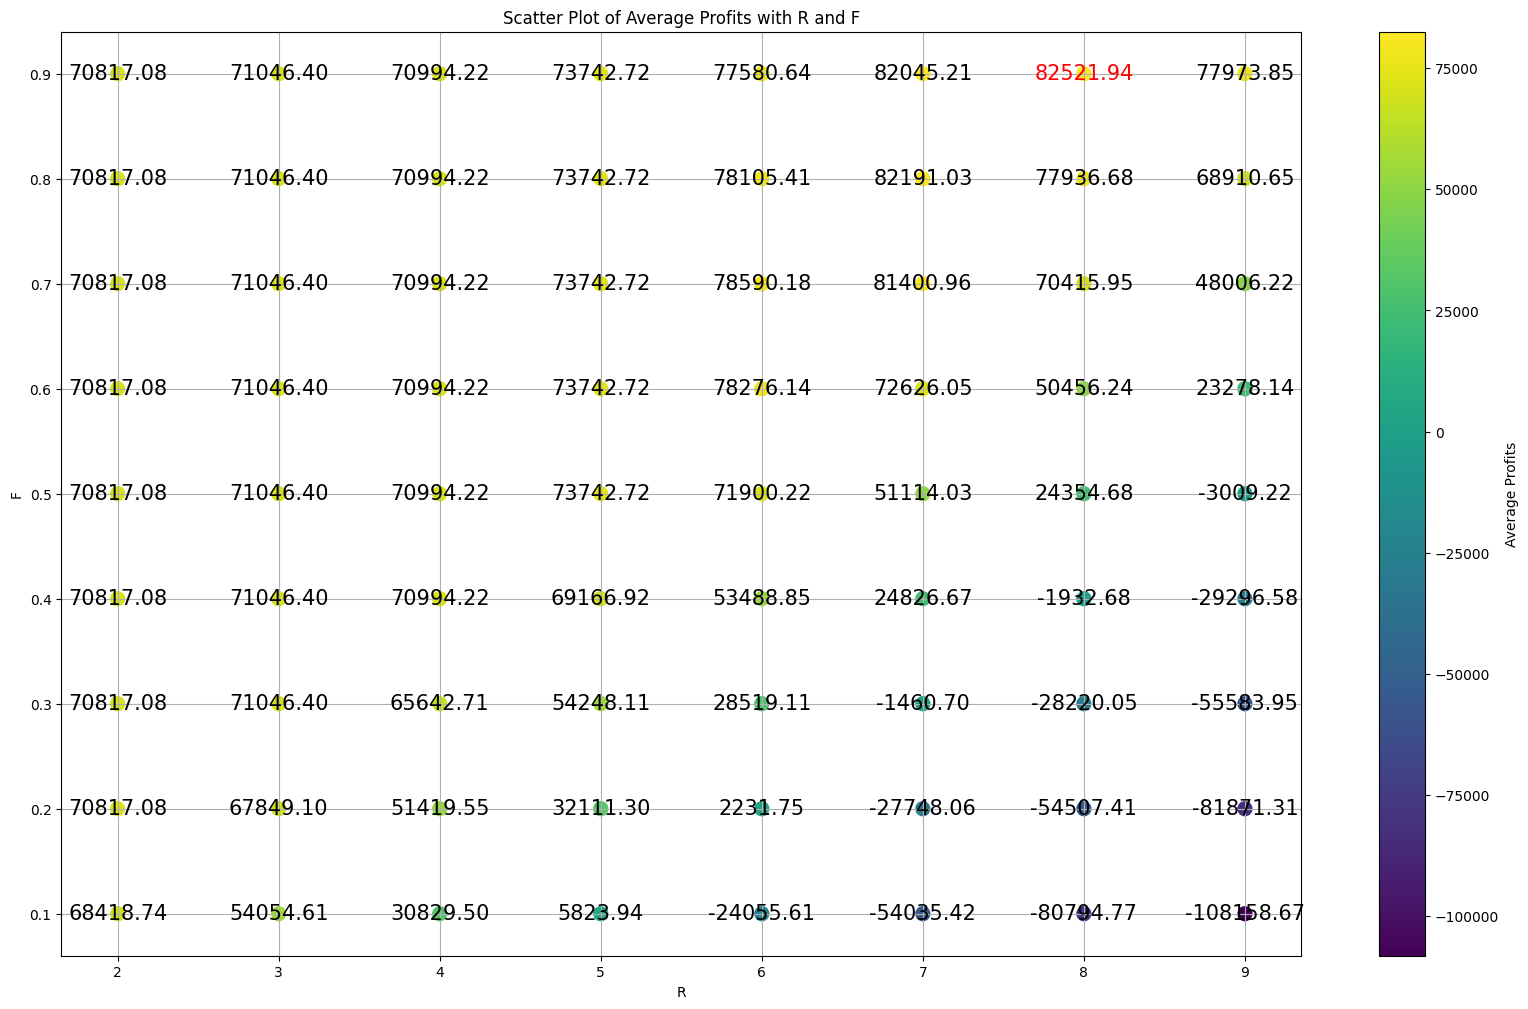

In [100]:
# 找到 'average_profits' 的最大值
max_profit = results_df_8["average_profits"].max()

# 画出散点图
plt.figure(figsize=(20, 12))
sc = plt.scatter(
    results_df_8["R(T)"],
    results_df_8["F"],
    c=results_df_8["average_profits"],
    cmap="viridis",
    s=100,
)
plt.colorbar(label="Average Profits")
plt.xlabel("R")
plt.ylabel("F")
plt.title("Scatter Plot of Average Profits with R and F")
plt.grid(True)

# 在每个数据点上标注数值
for i in range(len(results_df_8)):
    avg_profit = results_df_8["average_profits"].iloc[i]
    # 判断是否等于 max_profit 的整數部分
    if int(avg_profit) == int(max_profit):
        plt.text(
            results_df_8["R(T)"].iloc[i],
            results_df_8["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="red",
        )
    else:
        plt.text(
            results_df_8["R(T)"].iloc[i],
            results_df_8["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="black",
        )

name = "grid_fixed_F_fixed_R_metrics_s8"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

Plot saved as plots/grid_fixed_F_fixed_R_trend_s8_train_linear_constraint_med_with_holding_cost_0_20_202411282053.png


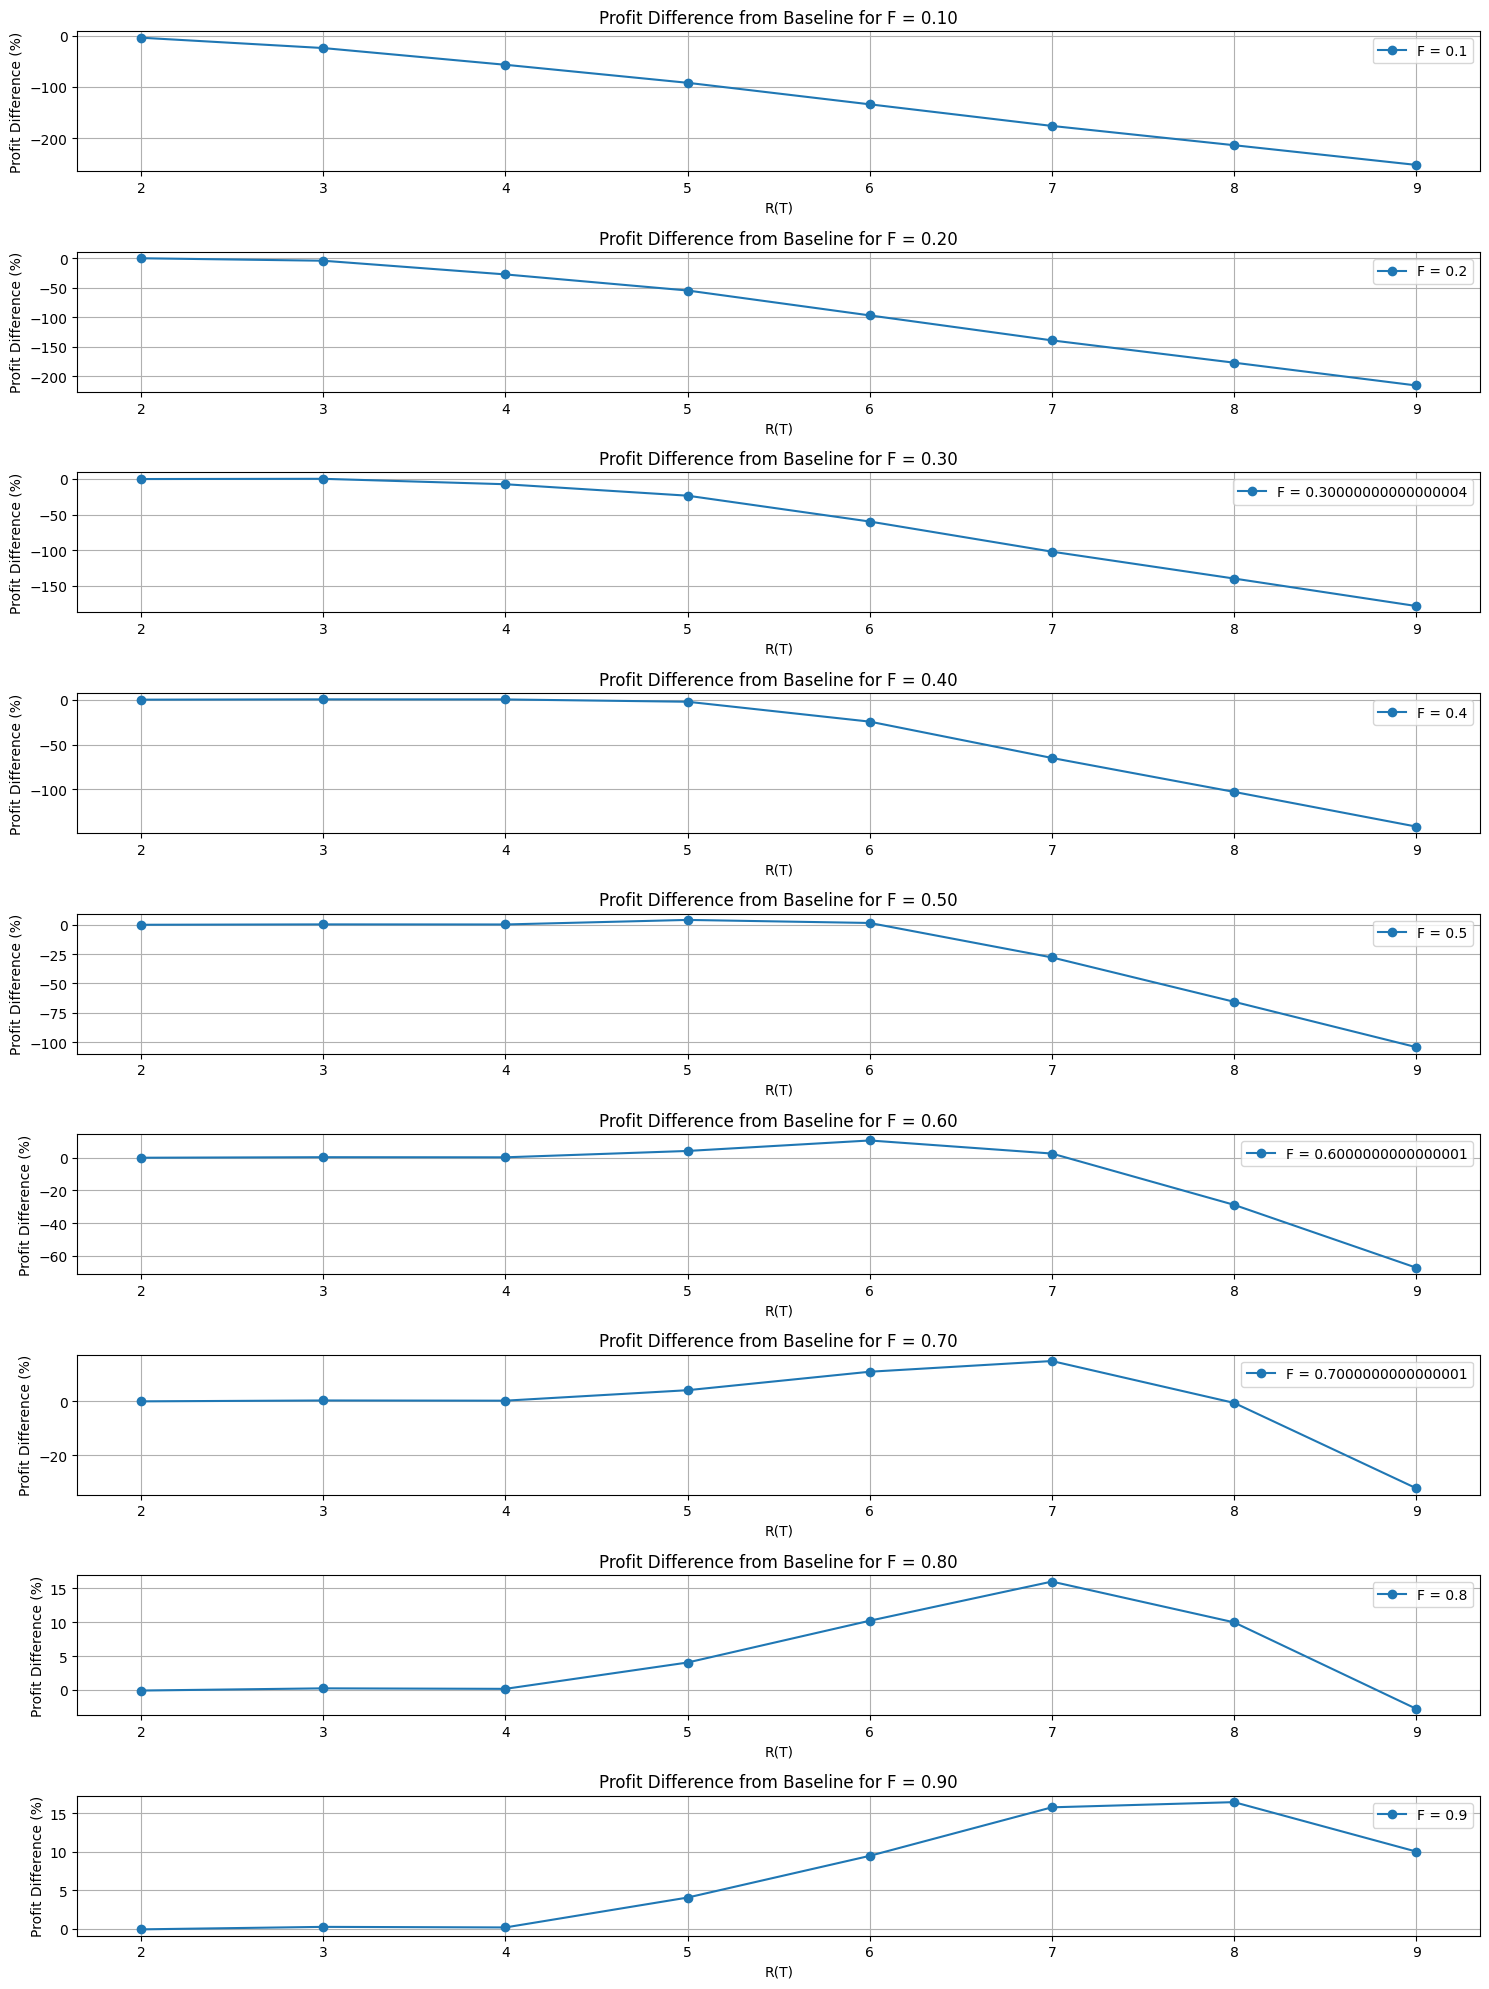

In [101]:
results_df_8["baseline_profit"] = baseline_avg_profits

# Calculate percentage difference from baseline profit
results_df_8["profit_diff_percent"] = (
    (results_df_8["average_profits"] - baseline_avg_profits) / baseline_avg_profits
) * 100

# Plot subplots for different values of F
plt.figure(figsize=(15, 20))

for idx, F in enumerate(ASSIGNED_FS):
    plt.subplot(len(ASSIGNED_FS), 1, idx + 1)
    subset = results_df_8[results_df_8["F"] == F].sort_values(by="R(T)").dropna()
    plt.plot(
        subset["R(T)"],
        subset["profit_diff_percent"],
        marker="o",
        linestyle="-",
        label=f"F = {F}",
    )
    plt.xlabel("R(T)")
    plt.ylabel("Profit Difference (%)")
    plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()

name = "grid_fixed_F_fixed_R_trend_s8"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

### S2 - Grid for Fixed Rk & Flexible F


In [102]:
results_df_2, stimulation_results_df_2 = None, None
results_df_2, stimulation_results_df_2 = grid_flexible_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df_train=Qk_hat_df_train,
    training_df=training_df,
    holding_cost=holding_cost,
)
results_df_2

+++++++++++++++++++++++++++++++++++++++ THis is T=2 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.5
Set parameter TimeLimit to value 10000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 420 rows, 353 columns and 1320 nonzeros
Model fingerprint: 0x76442011
Model has 20 general constraints
Variable types: 203 continuous, 150 integer (150 binary)
Coefficient statistics:
  Matrix range     [2e-02, 5e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 5e+06]
Presolve removed 316 rows and 216 columns
Presolve time: 0.00s
Presolved: 104 rows, 137 columns, 662 nonzeros
Variable types: 103 continuous, 34 integer (14 binary)
Foun

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/675930583.py:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/675930583.py:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/675930583.py:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with D

H    0     0                    830294.75407 830294.754  0.00%     -    0s
     0     0 830294.754    0    1 830294.754 830294.754  0.00%     -    0s

Cutting planes:
  Learned: 2
  Clique: 1
  MIR: 1
  Relax-and-lift: 1

Explored 1 nodes (132 simplex iterations) in 0.02 seconds (0.01 work units)
Thread count was 12 (of 12 available processors)

Solution count 1: 830295 

Optimal solution found (tolerance 5.00e-01)
  Piecewise linearization of function constraints often causes big violation.
  Try to adjust the settings of the related parameters, such as FuncPieces.
Best objective 8.302947540650e+05, best bound 8.302947540650e+05, gap 0.0000%

model.status is optimal: True
model.status is TIME_LIMIT: False

===================== 找到最佳解 ==================
Q0_optimal（最佳總庫存量）: 175.24908843677085
Alphas values:
alpha[0]: 1.6523898789912783
alpha[1]: 0.6012641327032322
alpha[2]: 4.068093869528418
----------------------------------------------
第 1 筆觀察資料:
第 2 天補貨策略: R_vars = 0.0
第 3 天補貨策略: R_v

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/675930583.py:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


R(T)                               R  average_profits  average_losses  \
5     7  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]     83029.475407        2.127176   
4     6  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]     79227.849419        4.481152   
3     5  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]     74484.303588        7.944251   
1     3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]     71046.397998       11.052097   
2     4  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]     70994.219295       11.086883   
0     2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]     70817.078561       11.204977   

   average_lefts  average_operation_profits  \
5      49.665894               86560.956092   
4      76.170219               85383.968404   
3     101.080455               83652.418741   
1     125.956781               82098.495478   
2     106.044155               82081.102577   
0     142.136298               82022.055666   

                                        alpha_values  \
5  [1.6523898789912783, 0.6012641327032322, 4.068...   
4       [0.4286059205479202, 0.0, 4.377832983467565]   
3      [1.2821530709640676, 0.0, 3.4324578346836985]   
1      [0.0, 0.0900784166004274, 1.8803942706331371]   
2     [0.0, 0.09501670693130355, 1.8738372302327737]   
0       [0.0, 0.115570707071381, 1.8465457183374714]   

                                              F_vars  \
5  [0.9820138157341068, 0.5993195596269995, 0.904...   
4  [0.9901596384517432, 0.5385978793091324, 0.880...   
3  [0.9820140199921694, 0.8176793412062848, 0.942...   
1  [0.8637045605511823, 0.8192059631313654, 0.844...   
2  [0.8627675124022007, 0.815829407254905, 0.8426...   
0  [0.8588673594150424, 0.8017756102304928, 0.834...   

                                             Q0_vars  \
5  [172.0970260397173, 105.03020650695859, 158.44...   
4  [173.5245740455506, 94.38878738290337, 154.358...   
3  [172.09706183575656, 143.29755917998074, 165.1...   
1  [151.36343691527645, 143.5650982807387, 148.01...   
2  [151.19922008134608, 142.9733599413332, 147.66...   
0  [150.51572182558263, 140.51044482372956, 146.2...   

                                             Q1_vars  
5  [31.60198635407702, 20.32706298852554, 0.0, 36...  
4  [36.115151422559805, 36.115151422559805, 24.92...  
3  [8.858190254278894, 36.115151422559805, 17.180...  
1  [28.126902873233973, 29.80532682774748, 32.257...  
2  [28.227895106632886, 28.429670506457732, 34.99...  
0  [25.355208659216117, 31.578934859873844, 33.08...

In [181]:
stimulation_results_df_2_selected, rounded_difference_df = organize_stimulation_result(
    stimulation_results_df_2, Q_star, Qk_hat_df_train
)
stimulation_results_df_2_selected

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/1770888325.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["Q0-Sold0s(left0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/1770888325.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["demand_up-Q0(lost0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/1770888325.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

R      Q_star         F          Q0   demand_up      Sold0s     Left0s  \
0  5  175.249088  0.982014  172.097026  122.055981  122.055981  50.041045   
1  5  175.249088  0.599320  105.030207  105.030207  105.030207   0.000000   
2  5  175.249088  0.904124  158.446939  112.989640  112.989640  45.457300   
3  5  175.249088  0.998522  174.990094  138.841689  138.841689  36.148405   
4  5  175.249088  0.794372  139.212897  107.350829  107.350829  31.862068   
5  5  175.249088  0.982014  172.097025   94.883091   94.883091  77.213934   
6  5  175.249088  0.952573  166.937517  105.010325  105.010325  61.927193   
7  5  175.249088  0.982014  172.097027  128.972243  128.972243  43.124783   
8  5  175.249088  0.770387  135.009534  104.997819  104.997819  30.011715   
9  5  175.249088  0.975935  171.031686   99.517042   99.517042  71.514645   

   lost0s      Qk_hat  Qk_hat-Q0  ...     Left1s     lost1s  Q0-Sold0s(left0)  \
0     0.0  203.699012  31.601986  ...   2.112030   0.000000         50.041045   
1     0.0  125.357269  20.327063  ...   2.883553   0.000000          0.000000   
2     0.0  154.948456  -3.498483  ...   0.000000   0.000000         45.457300   
3     0.0  211.105246  36.115151  ...   0.000000  12.250760         36.148405   
4     0.0  175.328048  36.115151  ...   5.621697   0.000000         31.862068   
5     0.0  147.632270 -24.464754  ...  18.081769   0.000000         77.213934   
6     0.0  187.128540  20.191023  ...   0.000000   9.021002         61.927193   
7     0.0  205.258522  33.161495  ...  13.685461   0.000000         43.124783   
8     0.0  171.124685  36.115151  ...   6.973341   0.000000         30.011715   
9     0.0  170.908835  -0.122851  ...   0.000000   0.000000         71.514645   

   demand_up-Q0(lost0)  Q1_plus_lefts-Sold1s(left1)  \
0           -50.041045                 2.112030e+00   
1             0.000000                 2.883553e+00   
2           -45.457300                 0.000000e+00   
3           -36.148405                -1.862645e-09   
4           -31.862068                 5.621697e+00   
5           -77.213934                 1.808177e+01   
6           -61.927193                -1.862645e-09   
7           -43.124783                 1.368546e+01   
8           -30.011715                 6.973341e+00   
9           -71.514645                 0.000000e+00   

   demand_down-Q1_plus_lefts(lost1)  Q0-Sold0s(left0)_clip  \
0                         -2.112030              50.041045   
1                         -2.883553               0.000000   
2                          0.000000              45.457300   
3                         12.250760              36.148405   
4                         -5.621697              31.862068   
5                        -18.081769              77.213934   
6                          9.021002              61.927193   
7                        -13.685461              43.124783   
8                         -6.973341              30.011715   
9                          0.000000              71.514645   

   demand_up-Q0(lost0)_clip  Q1_plus_lefts-Sold1s(left1)_clip  \
0                       0.0                          2.112030   
1                       0.0                          2.883553   
2                       0.0                          0.000000   
3                       0.0                          0.000000   
4                       0.0                          5.621697   
5                       0.0                         18.081769   
6                       0.0                          0.000000   
7                       0.0                         13.685461   
8                       0.0                          6.973341   
9                       0.0                          0.000000   

   demand_down-Q1_plus_lefts(lost1)_clip  
0                               0.000000  
1                               0.000000  
2                               0.000000  
3                              12.250760  
4                               0.000000  


In [183]:
stimulation_results_df_2_selected[
    stimulation_results_df_2_selected.columns.tolist()[:12]
]

R      Q_star         F          Q0   demand_up      Sold0s     Left0s  \
0  5  175.249088  0.982014  172.097026  122.055981  122.055981  50.041045   
1  5  175.249088  0.599320  105.030207  105.030207  105.030207   0.000000   
2  5  175.249088  0.904124  158.446939  112.989640  112.989640  45.457300   
3  5  175.249088  0.998522  174.990094  138.841689  138.841689  36.148405   
4  5  175.249088  0.794372  139.212897  107.350829  107.350829  31.862068   
5  5  175.249088  0.982014  172.097025   94.883091   94.883091  77.213934   
6  5  175.249088  0.952573  166.937517  105.010325  105.010325  61.927193   
7  5  175.249088  0.982014  172.097027  128.972243  128.972243  43.124783   
8  5  175.249088  0.770387  135.009534  104.997819  104.997819  30.011715   
9  5  175.249088  0.975935  171.031686   99.517042   99.517042  71.514645   

   lost0s      Qk_hat  Qk_hat-Q0         Q1  Q1_plus_lefts  
0     0.0  203.699012  31.601986  31.601986      81.643031  
1     0.0  125.357269  20.327063  20.327063      20.327063  
2     0.0  154.948456  -3.498483   0.000000      45.457300  
3     0.0  211.105246  36.115151  36.115151      72.263557  
4     0.0  175.328048  36.115151  36.115151      67.977219  
5     0.0  147.632270 -24.464754   0.000000      77.213934  
6     0.0  187.128540  20.191023  20.191023      82.118216  
7     0.0  205.258522  33.161495  33.161495      76.286278  
8     0.0  171.124685  36.115151  36.115151      66.126866  
9     0.0  170.908835  -0.122851   0.000000      71.514645

In [105]:
rounded_difference_df

Metric  Average Difference
0                  Left0s - Q0-Sold0s(left0)                -0.0
1               Lost0s - demand_up-Q0(lost0)                 0.0
2       Left1s - Q1_plus_lefts-Sold1s(left1)                -0.0
3  Lost1s - demand_down-Q1_plus_lefts(lost1)                -0.0

In [106]:
# # 驗證 Q1 計算是否正確

# if stimulation_results_df_2 is not None and len(stimulation_results_df_2) > 0:
#     stimulation_results_df_2["Qk_hat"] = Qk_hat_df_train.iloc[
#         :, stimulation_results_df_2.iloc[0, 0]
#     ]
#     stimulation_results_df_2["Qk_hat-Q0"] = (
#         stimulation_results_df_2["Qk_hat"] - stimulation_results_df_2["Q0"]
#     )
#     stimulation_results_df_2["Q_star"] = Q_star
#     print(
#         stimulation_results_df_2[
#             ["R", "F", "Q_star", "Q0", "Qk_hat", "Qk_hat-Q0", "Q1"]
#         ]
#     )

In [107]:
if results_df_2 is not None and len(results_df_2) > 0:
    save_model_parameters(
        f"{model_prefix}_s2", alpha_values=results_df_2.iloc[0]["alpha_values"]
    )

Model parameters saved as models/linear_constraint_med_with_holding_cost_0_s2_20_202411282053.pkl


In [108]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_2.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "average_profits"]]
top_three_info

R(T)  average_profits
5     7     83029.475407
4     6     79227.849419
3     5     74484.303588

### S3 - Grid for Fixed F & Flexible Rk


In [109]:
results_df_3, stimulation_results_df_3 = None, None
results_df_3, stimulation_results_df_3 = grid_fixed_F_flexible_R(
    assigned_Fs=ASSIGNED_FS,
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df_train=Qk_hat_df_train,
    training_df=training_df,
    holding_cost=holding_cost,
)


results_df_3

+++++++++++++++++++++++++++++++++++++++ THis is F=0.1 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.5
Set parameter TimeLimit to value 10000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 600 rows, 694 columns and 1920 nonzeros
Model fingerprint: 0x31934983
Model has 100 quadratic constraints
Model has 180 general constraints
Variable types: 544 continuous, 150 integer (140 binary)
Coefficient statistics:
  Matrix range     [2e-02, 5e+06]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e-01, 5e+06]
  GenCon coe range [1e+00, 1e+00]
Presolve added 220 rows and 

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/2035653732.py:247: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


IIS computation: initial model status unknown, solving to determine model status
Presolve added 220 rows and 12610 columns
Presolve time: 0.01s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.01 work units)
Thread count was 1 (of 12 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -

Computing Irreducible Inconsistent Subsystem (IIS)...

           Constraints          |            Bounds           |  Runtime
      Min       Max     Guess   |   Min       Max     Guess   |
--------------------------------------------------------------------------
        0       880         -         0       570         -           0s
        6         6         6         1         1         1           0s

IIS computed: 6 constraints, 1 bounds
IIS runtime: 0.42 seconds (0.36 work units)
導致不可行的約束： R120


R(T)  average_losses  average_lefts  \
0  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]        4.128771     157.459308   

   average_operation_profits  average_profits  \
0               82022.055666     74355.181548   

                                         beta_values  \
0  [[-0.6000815035488267, 1.1935688309750148, -1....   

                                              F_vars  \
0  [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, ...   

                                             Q0_vars  \
0  [157.72417959309377, 157.72417959309377, 157.7...   

                                             Q1_vars  \
0  [18.146750891704983, 14.365200090509655, 21.58...   

                                          tau_values  
0  [[-1.8893619633996008, -2.8339584644000886, -1...

In [110]:
if results_df_3 is not None and len(results_df_3) > 0:
    save_model_parameters(
        f"{model_prefix}_s3",
        beta_values=results_df_3.iloc[0]["beta_values"],
        tau_values=results_df_3.iloc[0]["tau_values"],
    )

Model parameters saved as models/linear_constraint_med_with_holding_cost_0_s3_20_202411282053.pkl


In [111]:
stimulation_results_df_3_selected, rounded_difference_df = organize_stimulation_result(
    stimulation_results_df_3, Q_star, Qk_hat_df_train
)
stimulation_results_df_3_selected

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/1770888325.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["Q0-Sold0s(left0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/1770888325.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["demand_up-Q0(lost0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/1770888325.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

R      Q_star    F         Q0  demand_up     Sold0s      Left0s  lost0s  \
0  0  175.249088  0.9  157.72418  18.983674   0.000000  157.724180     0.0   
1  0  175.249088  0.9  157.72418  16.322423  16.322423  141.401756     0.0   
2  0  175.249088  0.9  157.72418  21.401028  21.401028  136.323151     0.0   
3  0  175.249088  0.9  157.72418  26.678838   0.000000  157.724180     0.0   
4  0  175.249088  0.9  157.72418  25.538998  25.538998  132.185182     0.0   
5  0  175.249088  0.9  157.72418  14.019274  14.019274  143.704905     0.0   
6  0  175.249088  0.9  157.72418   9.322770   0.000000  157.724180     0.0   
7  0  175.249088  0.9  157.72418  18.931140   3.154361  154.569819     0.0   
8  0  175.249088  0.9  157.72418  12.638800  12.638800  145.085379     0.0   
9  0  175.249088  0.9  157.72418  21.623604  21.623604  136.100575     0.0   

       Qk_hat  Qk_hat-Q0  ...     Left1s     lost1s  Q0-Sold0s(left0)  \
0  175.870930  18.146751  ...   0.000000   6.732378        157.724180   
1  172.089380  14.365200  ...  49.615663   0.000000        141.401756   
2  179.305914  21.581734  ...  20.858974   0.000000        136.323151   
3  186.805510  29.081331  ...   0.000000   9.871658        157.724180   
4  185.185835  27.461656  ...  15.479484   0.000000        132.185182   
5  168.816679  11.092500  ...  14.801423   0.000000        143.704905   
6  162.143097   4.418918  ...   0.000000  24.683676        157.724180   
7  175.796282  18.072102  ...   0.000000   0.000000        154.569819   
8  166.855070   9.130890  ...   2.703726   0.000000        145.085379   
9  179.622187  21.898007  ...   8.590500   0.000000        136.100575   

   demand_up-Q0(lost0)  Q1_plus_lefts-Sold1s(left1)  \
0          -138.740506                     0.000000   
1          -141.401756                    49.615663   
2          -136.323151                    20.858974   
3          -131.045342                     0.000000   
4          -132.185182                    15.479484   
5          -143.704905                    14.801423   
6          -148.401410                     0.000000   
7          -138.793040                     0.000000   
8          -145.085379                     2.703726   
9          -136.100575                     8.590500   

   demand_down-Q1_plus_lefts(lost1)  Q0-Sold0s(left0)_clip  \
0                          6.732378             157.724180   
1                        -49.615663             141.401756   
2                        -20.858974             136.323151   
3                          9.871658             157.724180   
4                        -15.479484             132.185182   
5                        -14.801423             143.704905   
6                         24.683676             157.724180   
7                          0.000000             154.569819   
8                         -2.703726             145.085379   
9                         -8.590500             136.100575   

   demand_up-Q0(lost0)_clip  Q1_plus_lefts-Sold1s(left1)_clip  \
0                       0.0                          0.000000   
1                       0.0                         49.615663   
2                       0.0                         20.858974   
3                       0.0                          0.000000   
4                       0.0                         15.479484   
5                       0.0                         14.801423   
6                       0.0                          0.000000   
7                       0.0                          0.000000   
8                       0.0                          2.703726   
9                       0.0                          8.590500   

   demand_down-Q1_plus_lefts(lost1)_clip  
0                               6.732378  
1                               0.000000  
2                               0.000000  
3                               9.871658  
4                               0.000000  
5                               0.000000  
6                              24.

In [112]:
rounded_difference_df

Metric  Average Difference
0                  Left0s - Q0-Sold0s(left0)                -0.0
1               Lost0s - demand_up-Q0(lost0)                 0.0
2       Left1s - Q1_plus_lefts-Sold1s(left1)                -0.0
3  Lost1s - demand_down-Q1_plus_lefts(lost1)                 0.0

Plot saved as plots/result_3_metrics_train_linear_constraint_med_with_holding_cost_0_20_202411282053.png


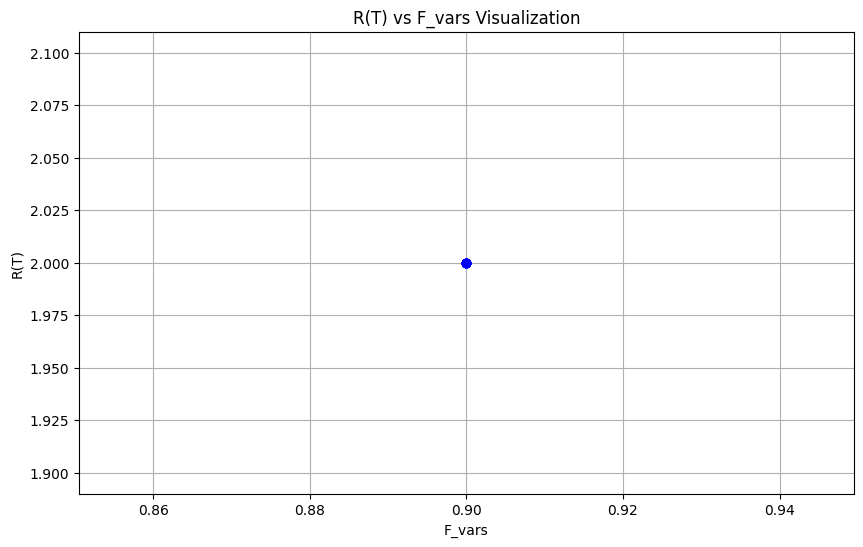

In [113]:
if results_df_3 is not None and len(results_df_3) > 0:

    r_values = results_df_3["R(T)"].explode().values
    f_values = results_df_3["F_vars"].explode().values

    plt.figure(figsize=(10, 6))
    plt.plot(f_values, r_values, marker="o", linestyle="-", color="b")

    plt.title("R(T) vs F_vars Visualization")
    plt.xlabel("F_vars")
    plt.ylabel("R(T)")

    plt.grid(True)

    name = "result_3_metrics"

    os.makedirs("plots", exist_ok=True)
    save_path = (
        f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"
    )

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

else:
    print("results_df_3 is None")

### Fully flexible F & Rk


#### S5 - Simple beta with softmax


In [114]:
results_df_5, stimulation_results_df_5 = None, None
results_df_5, stimulation_results_df_5 = fully_flexible_simple_beta_with_softmax_5(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
    holding_cost=holding_cost,
)
results_df_5

Set parameter Threads to value 12
Set parameter MIPGap to value 0.5
Set parameter TimeLimit to value 10000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 600 rows, 715 columns and 1790 nonzeros
Model fingerprint: 0xc6d364e2
Model has 100 quadratic constraints
Model has 190 general constraints
Variable types: 565 continuous, 150 integer (140 binary)
Coefficient statistics:
  Matrix range     [2e-02, 5e+06]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 5e+06]
  GenCon coe range [1e+00, 1e+00]
Presolve added 148 rows and 12478 columns
Presolve time: 0.15s
Presolved: 3928 rows, 13943 columns, 48475 nonzeros
Presolved model h

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/104858953.py:265: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)



Root relaxation: objective 8.701201e+05, 559 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 870120.062    0  605          - 870120.062      -     -    0s
     0     0 870120.062    0  605          - 870120.062      -     -    0s
     0     0 870120.062    0  789          - 870120.062      -     -    1s
     0     0 870120.062    0  788          - 870120.062      -     -    1s
     0     0 870120.062    0  782          - 870120.062      -     -    1s
     0     0 869128.638    0  782          - 869128.638      -     -    1s
     0     0 868477.776    0  783          - 868477.776      -     -    2s
     0     0 868024.489    0  775          - 868024.489      -     -    2s
     0     0 868024.489    0  774          - 868024.489      -     -    2s
     0     0 868024.489    0  772          - 868024.489      -     -    2s
     0   

average_profits  average_losses  average_lefts  average_operation_profits  \
0     83755.894147             0.0      58.489592               86815.196311   

                                   alpha_values  \
0  [0.0, 3.2613734036584305, 8.023476481669615]   

                                         beta_values  \
0  [[0.0], [-0.08949071067430804], [-0.0894906902...   

                                          tau_values  
0  [[0.0, -0.08949071067430804, -0.08949069026857...

In [115]:
if results_df_5 is not None:
    save_model_parameters(
        f"{model_prefix}_s5",
        alpha_values=results_df_5.iloc[0]["alpha_values"],
        beta_values=results_df_5.iloc[0]["beta_values"],
        tau_values=results_df_5.iloc[0]["tau_values"],
        f_values=stimulation_results_df_5["f_values"].values,
    )

Model parameters saved as models/linear_constraint_med_with_holding_cost_0_s5_20_202411282053.pkl


In [116]:
stimulation_results_df_5

R(T)  R         F   f_values        profits  losses       lefts  \
0     9  7  0.998895   8.221038   99802.066716     0.0   19.992196   
1     8  6  0.622203   0.641828   61178.409157     0.0    0.116898   
2     7  5  0.982014   5.472366   72398.424150     0.0   72.757481   
3     7  5  0.999952  11.939654  105552.622780     0.0   48.649684   
4     6  4  0.997527   7.881506   82298.468819     0.0   91.000535   
5     3  1  0.999904   9.859957   66399.094516     0.0  179.142785   
6     8  6  0.999952   9.936777   97098.096618     0.0   57.659030   
7     8  6  0.999952  12.353914   92449.960399     0.0   27.447270   
8     9  7  0.997527   7.949104   76743.461273     0.0   45.651529   
9     9  7  0.997362   5.978619   83638.337043     0.0   42.478516   

   operation_profits          Q0         Q1  ...      Left0s     Left1s  \
0       99802.066716  175.055454  24.548680  ...   19.992196   0.000000   
1       61236.858326  109.040540  13.550075  ...    0.000000   0.116898   
2       79223.469620  172.097030   0.000000  ...   59.107390  13.650091   
3      105552.622780  175.240613  35.864632  ...   48.649684   0.000000   
4       84853.175660  174.815765   0.000000  ...   85.891121   5.109414   
5       77007.628022  175.232323   0.000000  ...  157.925718  21.217067   
6       97098.096618  175.240613  18.955580  ...   57.659030   0.000000   
7       95786.530265  175.240613  23.005587  ...   20.774131   6.673140   
8       82075.671901  174.815765   0.000000  ...   34.987108  10.664421   
9       85515.843205  174.786699   0.000000  ...   38.723504   3.755012   

   lost0s  lost1s      Qk_hat      Sold0s      Sold1s   demand_up  \
0     0.0     0.0  199.604133  155.063258   44.540875  157.046107   
1     0.0     0.0  122.590615  109.040540   13.433176  109.040540   
2     0.0     0.0  154.948456  112.989640   45.457300  112.989640   
3     0.0     0.0  211.105246  126.590929   84.514317  138.841689   
4     0.0     0.0  159.657994   88.924644   80.781707   88.924644   
5     0.0     0.0  164.774592   17.306605  136.708651   17.306605   
6     0.0     0.0  194.196193  117.581584   76.614609  119.534933   
7     0.0     0.0  198.246200  154.466483   37.106578  154.466483   
8     0.0     0.0  162.293632  139.828657   24.322687  139.828657   
9     0.0     0.0  169.800043  136.063195   34.968491  136.063195   

   demand_down  Q1_plus_lefts  
0    44.540875      44.540875  
1    13.433176      13.550075  
2    45.457300      59.107390  
3    84.514317      84.514317  
4    80.781707      85.891121  
5   136.708651     157.925718  
6    76.614609      76.614609  
7    37.106578      43.779718  
8    24.322687      34.987108  
9    34.968491      38.723504  

[10 rows x 22 columns]

In [117]:
stimulation_results_df_5_selected, rounded_difference_df = organize_stimulation_result(
    stimulation_results_df_5, Q_star, Qk_hat_df_train
)
stimulation_results_df_5_selected

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/1770888325.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["Q0-Sold0s(left0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/1770888325.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["demand_up-Q0(lost0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/1770888325.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

R      Q_star         F          Q0   demand_up      Sold0s      Left0s  \
0  7  175.249088  0.998895  175.055454  157.046107  155.063258   19.992196   
1  6  175.249088  0.622203  109.040540  109.040540  109.040540    0.000000   
2  5  175.249088  0.982014  172.097030  112.989640  112.989640   59.107390   
3  5  175.249088  0.999952  175.240613  138.841689  126.590929   48.649684   
4  4  175.249088  0.997527  174.815765   88.924644   88.924644   85.891121   
5  1  175.249088  0.999904  175.232323   17.306605   17.306605  157.925718   
6  6  175.249088  0.999952  175.240613  119.534933  117.581584   57.659030   
7  6  175.249088  0.999952  175.240613  154.466483  154.466483   20.774131   
8  7  175.249088  0.997527  174.815765  139.828657  139.828657   34.987108   
9  7  175.249088  0.997362  174.786699  136.063195  136.063195   38.723504   

   lost0s      Qk_hat  Qk_hat-Q0  ...     Left1s  lost1s  Q0-Sold0s(left0)  \
0     0.0  199.604133  24.548680  ...   0.000000     0.0         19.992196   
1     0.0  122.590615  13.550075  ...   0.116898     0.0          0.000000   
2     0.0  154.948456 -17.148574  ...  13.650091     0.0         59.107390   
3     0.0  211.105246  35.864632  ...   0.000000     0.0         48.649684   
4     0.0  159.657994 -15.157771  ...   5.109414     0.0         85.891121   
5     0.0  164.774592 -10.457731  ...  21.217067     0.0        157.925718   
6     0.0  194.196193  18.955580  ...   0.000000     0.0         57.659030   
7     0.0  198.246200  23.005587  ...   6.673140     0.0         20.774131   
8     0.0  162.293632 -12.522133  ...  10.664421     0.0         34.987108   
9     0.0  169.800043  -4.986656  ...   3.755012     0.0         38.723504   

   demand_up-Q0(lost0)  Q1_plus_lefts-Sold1s(left1)  \
0           -18.009347                     0.000000   
1             0.000000                     0.116898   
2           -59.107390                    13.650091   
3           -36.398924                     0.000000   
4           -85.891121                     5.109414   
5          -157.925718                    21.217067   
6           -55.705680                     0.000000   
7           -20.774131                     6.673140   
8           -34.987108                    10.664421   
9           -38.723504                     3.755012   

   demand_down-Q1_plus_lefts(lost1)  Q0-Sold0s(left0)_clip  \
0                      0.000000e+00              19.992196   
1                     -1.168983e-01               0.000000   
2                     -1.365009e+01              59.107390   
3                      0.000000e+00              48.649684   
4                     -5.109414e+00              85.891121   
5                     -2.121707e+01             157.925718   
6                      2.842171e-14              57.659030   
7                     -6.673140e+00              20.774131   
8                     -1.066442e+01              34.987108   
9                     -3.755012e+00              38.723504   

   demand_up-Q0(lost0)_clip  Q1_plus_lefts-Sold1s(left1)_clip  \
0                       0.0                          0.000000   
1                       0.0                          0.116898   
2                       0.0                         13.650091   
3                       0.0                          0.000000   
4                       0.0                          5.109414   
5                       0.0                         21.217067   
6                       0.0                          0.000000   
7                       0.0                          6.673140   
8                       0.0                         10.664421   
9                       0.0                          3.755012   

   demand_down-Q1_plus_lefts(lost1)_clip  
0                           0.000000e+00  
1                           0.000000e+00  
2                           0.000000e+00  
3                           0.000000e+00  
4                           0.000000e+00  
5                     

In [118]:
rounded_difference_df

Metric  Average Difference
0                  Left0s - Q0-Sold0s(left0)                 0.0
1               Lost0s - demand_up-Q0(lost0)                 0.0
2       Left1s - Q1_plus_lefts-Sold1s(left1)                 0.0
3  Lost1s - demand_down-Q1_plus_lefts(lost1)                -0.0

#### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [119]:
results_df_6, stimulation_results_df_6 = None, None
results_df_6, stimulation_results_df_6 = fully_flexible_simple_beta_with_softmax_6(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
    holding_cost=holding_cost,
)
results_df_6

Set parameter Threads to value 12
Set parameter MIPGap to value 0.5
Set parameter TimeLimit to value 10000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 600 rows, 681 columns and 1910 nonzeros
Model fingerprint: 0x760a7a0a
Model has 90 quadratic constraints
Model has 180 general constraints
Variable types: 531 continuous, 150 integer (140 binary)
Coefficient statistics:
  Matrix range     [2e-02, 5e+06]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 5e+06]
  GenCon coe range [1e+00, 1e+00]


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/3055309810.py:277: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Presolve added 138 rows and 10951 columns
Presolve time: 0.10s
Presolved: 1158 rows, 11662 columns, 36015 nonzeros
Presolved model has 80 SOS constraint(s)
Presolved model has 100 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 11450 continuous, 212 integer (202 binary)

Root relaxation: objective 8.701201e+05, 640 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 870120.062    0  127          - 870120.062      -     -    0s
     0     0 870120.062    0  127          - 870120.062      -     -    0s
     0     0 870120.062    0  127          - 870120.062      -     -    0s
     0     0 870120.062    0  127          - 870120.062      -     -    0s
     0     0 870120.062    0  135          - 870120.062      -     -    0s
     0     0 870120.062    0  135          - 870120.062      -     -    0s
     0     0 870120.

average_profits  average_losses  average_lefts  average_operation_profits  \
0     84391.961124             0.0      45.945743               86142.154103   

                                        alpha_values  \
0  [0.5479427377659902, 0.9442304595010617, 3.503...   

                                         beta_values  \
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   

                                          tau_values  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....

In [120]:
if results_df_6 is not None:
    save_model_parameters(
        f"{model_prefix}_s6",
        alpha_values=results_df_6.iloc[0]["alpha_values"],
        beta_values=results_df_6.iloc[0]["beta_values"],
        tau_values=results_df_6.iloc[0]["tau_values"],
        f_values=stimulation_results_df_6["f_values"].values,
    )

Model parameters saved as models/linear_constraint_med_with_holding_cost_0_s6_20_202411282053.pkl


In [121]:
stimulation_results_df_6_selected, rounded_difference_df = organize_stimulation_result(
    stimulation_results_df_6, Q_star, Qk_hat_df_train
)
stimulation_results_df_6_selected

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/1770888325.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["Q0-Sold0s(left0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/1770888325.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["demand_up-Q0(lost0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/1770888325.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

R      Q_star         F          Q0   demand_up      Sold0s     Left0s  \
0  5  175.249088  0.982014  172.097022  122.055981  122.055981  50.041041   
1  6  175.249088  0.622203  109.040540  109.040540  109.040540   0.000000   
2  5  175.249088  0.914849  160.326447  112.989640  112.989640  47.336808   
3  4  175.249088  0.993307  174.076173  109.852451   84.373295  89.702877   
4  7  175.249088  0.912932  159.990481  148.457656  148.457656  11.532826   
5  7  175.249088  0.982014  172.097022  137.110794  137.110794  34.986229   
6  7  175.249088  0.985314  172.675399  146.054464  146.054464  26.620934   
7  7  175.249088  0.993307  174.076172  172.535226  172.535226   1.540946   
8  3  175.249088  0.920778  161.365516   68.266350   64.220554  97.144962   
9  5  175.249088  0.941181  164.941138   99.517042   99.394191  65.546947   

   lost0s      Qk_hat  Qk_hat-Q0  ...     Left1s  lost1s  Q0-Sold0s(left0)  \
0     0.0  203.699012  31.601991  ...   2.112030     0.0         50.041041   
1     0.0  122.590615  13.550075  ...   0.116898     0.0          0.000000   
2     0.0  154.948456  -5.377991  ...   1.879508     0.0         47.336808   
3     0.0  197.876850  23.800678  ...   0.000000     0.0         89.702877   
4     0.0  172.013472  12.022990  ...   2.307120     0.0         11.532826   
5     0.0  152.180145 -19.916878  ...  18.081766     0.0         34.986229   
6     0.0  198.404981  25.729583  ...   2.255439     0.0         26.620934   
7     0.0  194.219765  20.143592  ...   2.646704     0.0          1.540946   
8     0.0  165.709941   4.344425  ...   5.604394     0.0         97.144962   
9     0.0  170.908835   5.967697  ...   0.000000     0.0         65.546947   

   demand_up-Q0(lost0)  Q1_plus_lefts-Sold1s(left1)  \
0           -50.041041                     2.112030   
1             0.000000                     0.116898   
2           -47.336808                     1.879508   
3           -64.223722                     0.000000   
4           -11.532826                     2.307120   
5           -34.986229                    18.081766   
6           -26.620934                     2.255439   
7            -1.540946                     2.646704   
8           -93.099166                     5.604394   
9           -65.424096                     0.000000   

   demand_down-Q1_plus_lefts(lost1)  Q0-Sold0s(left0)_clip  \
0                         -2.112030              50.041041   
1                         -0.116898               0.000000   
2                         -1.879508              47.336808   
3                          0.000000              89.702877   
4                         -2.307120              11.532826   
5                        -18.081766              34.986229   
6                         -2.255439              26.620934   
7                         -2.646704               1.540946   
8                         -5.604394              97.144962   
9                          0.000000              65.546947   

   demand_up-Q0(lost0)_clip  Q1_plus_lefts-Sold1s(left1)_clip  \
0                       0.0                          2.112030   
1                       0.0                          0.116898   
2                       0.0                          1.879508   
3                       0.0                          0.000000   
4                       0.0                          2.307120   
5                       0.0                         18.081766   
6                       0.0                          2.255439   
7                       0.0                          2.646704   
8                       0.0                          5.604394   
9                       0.0                          0.000000   

   demand_down-Q1_plus_lefts(lost1)_clip  
0                                    0.0  
1                                    0.0  
2                                    0.0  
3                                    0.0  
4                                    0.0  
5                                

In [122]:
rounded_difference_df

Metric  Average Difference
0                  Left0s - Q0-Sold0s(left0)                -0.0
1               Lost0s - demand_up-Q0(lost0)                 0.0
2       Left1s - Q1_plus_lefts-Sold1s(left1)                 0.0
3  Lost1s - demand_down-Q1_plus_lefts(lost1)                 0.0

#### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [123]:
results_df_7, stimulation_results_df_7 = None, None
results_df_7, stimulation_results_df_7 = fully_flexible_simple_beta_with_softmax_7(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
    holding_cost=holding_cost,
)
results_df_7

Set parameter Threads to value 12
Set parameter MIPGap to value 0.5
Set parameter TimeLimit to value 10000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 600 rows, 681 columns and 1980 nonzeros
Model fingerprint: 0x7091145a
Model has 90 quadratic constraints
Model has 180 general constraints
Variable types: 531 continuous, 150 integer (140 binary)
Coefficient statistics:
  Matrix range     [2e-02, 5e+06]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 5e+06]
  GenCon coe range [1e+00, 1e+00]
Presolve added 212 rows and 11025 columns
Presolve time: 0.09s
Presolved: 1232 rows, 11736 columns, 36233 nonzeros
Presolved model ha

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/3242431114.py:274: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)



Root relaxation: objective 8.701201e+05, 950 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 870120.062    0  131          - 870120.062      -     -    0s
     0     0 870120.062    0  156          - 870120.062      -     -    0s
     0     0 870120.062    0  156          - 870120.062      -     -    0s
     0     0 870120.062    0  154          - 870120.062      -     -    0s
     0     0 870120.062    0  155          - 870120.062      -     -    0s
     0     0 869838.834    0  166          - 869838.834      -     -    0s
     0     0 869708.931    0  147          - 869708.931      -     -    0s
     0     0 868717.507    0  141          - 868717.507      -     -    0s
     0     0 868717.507    0  146          - 868717.507      -     -    1s
     0     0 868717.507    0  146          - 868717.507      -     -    1s
     0   

average_profits  average_losses  average_lefts  average_operation_profits  \
0     83656.990626             0.0      61.755881               86252.918982   

                                        alpha_values  \
0  [0.0, 1.1456255267694737e-06, 3.9999984788434135]   

                                         beta_values  \
0  [[-4.0], [-4.0], [-4.0], [-4.0], [-4.0], [-4.0...   

                                          tau_values  
0  [[-1.0662280525153278e-06, -1.1915875353096794...

In [124]:
if results_df_7 is not None:

    save_model_parameters(
        f"{model_prefix}_s7",
        alpha_values=results_df_7.iloc[0]["alpha_values"],
        beta_values=results_df_7.iloc[0]["beta_values"],
        tau_values=results_df_7.iloc[0]["tau_values"],
        f_values=stimulation_results_df_7["f_values"].values,
    )

Model parameters saved as models/linear_constraint_med_with_holding_cost_0_s7_20_202411282053.pkl


In [125]:
stimulation_results_df_7

R(T)  R         F  f_values       profits  losses       lefts  \
0     7  5  0.982014  3.999999  99737.475841     0.0   52.153063   
1     9  7  0.698855  3.999996  61236.858326     0.0    9.961064   
2     7  5  0.982014  3.999998  72398.439192     0.0   72.757421   
3     6  4  0.952574  4.000000  98938.425185     0.0   82.564460   
4     6  4  0.982014  3.999998  83657.840552     0.0   85.563048   
5     8  6  0.982014  4.000000  67966.754526     0.0   77.486679   
6     8  6  0.982014  4.000000  97098.096618     0.0   54.515433   
7     8  6  0.982014  4.000000  92449.960399     0.0   24.303679   
8     4  2  0.982014  3.999998  78102.852218     0.0  121.154912   
9     9  7  0.982013  3.999998  84983.203408     0.0   37.099050   

   operation_profits          Q0         Q1  ...      Left0s     Left1s  \
0      100793.491019  172.097014  31.601998  ...   50.041033   2.112030   
1       61236.858326  122.473717   0.000000  ...    9.961064   0.000000   
2       79223.469620  172.097000   0.000000  ...   59.107360  13.650061   
3       98938.425185  166.937756  30.939095  ...   82.564460   0.000000   
4       84853.175660  172.097022   0.000000  ...   83.172377   2.390670   
5       77007.628022  172.097003   0.000000  ...   59.404933  18.081746   
6       97098.096618  172.097017  22.099176  ...   54.515433   0.000000   
7       95786.530265  172.097022  26.149179  ...   17.630539   6.673140   
8       82075.671901  172.096983   0.000000  ...  113.209273   7.945639   
9       85515.843205  172.096966   0.000000  ...   36.033771   1.065280   

   lost0s  lost1s      Qk_hat      Sold0s      Sold1s   demand_up  \
0     0.0     0.0  203.699012  122.055981   79.531001  122.055981   
1     0.0     0.0  121.973715  112.512653    9.961064  112.512653   
2     0.0     0.0  154.948456  112.989640   45.457300  112.989640   
3     0.0     0.0  197.876850   84.373295  113.503555  109.852451   
4     0.0     0.0  159.657994   88.924644   80.781707   88.924644   
5     0.0     0.0  145.233923  112.692070   41.323186  112.692070   
6     0.0     0.0  194.196193  117.581584   76.614609  119.534933   
7     0.0     0.0  198.246200  154.466483   37.106578  154.466483   
8     0.0     0.0  170.298354   58.887710  105.263634   58.887710   
9     0.0     0.0  169.800043  136.063195   34.968491  136.063195   

   demand_down  Q1_plus_lefts  
0    79.531001      81.643031  
1     9.961064       9.961064  
2    45.457300      59.107360  
3   113.503555     113.503555  
4    80.781707      83.172377  
5    41.323186      59.404933  
6    76.614609      76.614609  
7    37.106578      43.779718  
8   105.263634     113.209273  
9    34.968491      36.033771  

[10 rows x 22 columns]

In [126]:
stimulation_results_df_7_selected, rounded_difference_df = organize_stimulation_result(
    stimulation_results_df_7, Q_star, Qk_hat_df_train
)
stimulation_results_df_7_selected

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/1770888325.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["Q0-Sold0s(left0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/1770888325.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["demand_up-Q0(lost0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/1770888325.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

R      Q_star         F          Q0   demand_up      Sold0s      Left0s  \
0  5  175.249088  0.982014  172.097014  122.055981  122.055981   50.041033   
1  7  175.249088  0.698855  122.473717  112.512653  112.512653    9.961064   
2  5  175.249088  0.982014  172.097000  112.989640  112.989640   59.107360   
3  4  175.249088  0.952574  166.937756  109.852451   84.373295   82.564460   
4  4  175.249088  0.982014  172.097022   88.924644   88.924644   83.172377   
5  6  175.249088  0.982014  172.097003  112.692070  112.692070   59.404933   
6  6  175.249088  0.982014  172.097017  119.534933  117.581584   54.515433   
7  6  175.249088  0.982014  172.097022  154.466483  154.466483   17.630539   
8  2  175.249088  0.982014  172.096983   58.887710   58.887710  113.209273   
9  7  175.249088  0.982013  172.096966  136.063195  136.063195   36.033771   

   lost0s      Qk_hat  Qk_hat-Q0  ...     Left1s  lost1s  Q0-Sold0s(left0)  \
0     0.0  203.699012  31.601998  ...   2.112030     0.0         50.041033   
1     0.0  121.973715  -0.500002  ...   0.000000     0.0          9.961064   
2     0.0  154.948456 -17.148544  ...  13.650061     0.0         59.107360   
3     0.0  197.876850  30.939095  ...   0.000000     0.0         82.564460   
4     0.0  159.657994 -12.439028  ...   2.390670     0.0         83.172377   
5     0.0  145.233923 -26.863080  ...  18.081746     0.0         59.404933   
6     0.0  194.196193  22.099176  ...   0.000000     0.0         54.515433   
7     0.0  198.246200  26.149179  ...   6.673140     0.0         17.630539   
8     0.0  170.298354  -1.798629  ...   7.945639     0.0        113.209273   
9     0.0  169.800043  -2.296923  ...   1.065280     0.0         36.033771   

   demand_up-Q0(lost0)  Q1_plus_lefts-Sold1s(left1)  \
0           -50.041033                 2.112030e+00   
1            -9.961064                 2.131628e-14   
2           -59.107360                 1.365006e+01   
3           -57.085305                 0.000000e+00   
4           -83.172377                 2.390670e+00   
5           -59.404933                 1.808175e+01   
6           -52.562084                 0.000000e+00   
7           -17.630539                 6.673140e+00   
8          -113.209273                 7.945639e+00   
9           -36.033771                 1.065280e+00   

   demand_down-Q1_plus_lefts(lost1)  Q0-Sold0s(left0)_clip  \
0                     -2.112030e+00              50.041033   
1                     -2.131628e-14               9.961064   
2                     -1.365006e+01              59.107360   
3                      0.000000e+00              82.564460   
4                     -2.390670e+00              83.172377   
5                     -1.808175e+01              59.404933   
6                      0.000000e+00              54.515433   
7                     -6.673140e+00              17.630539   
8                     -7.945639e+00             113.209273   
9                     -1.065280e+00              36.033771   

   demand_up-Q0(lost0)_clip  Q1_plus_lefts-Sold1s(left1)_clip  \
0                       0.0                      2.112030e+00   
1                       0.0                      2.131628e-14   
2                       0.0                      1.365006e+01   
3                       0.0                      0.000000e+00   
4                       0.0                      2.390670e+00   
5                       0.0                      1.808175e+01   
6                       0.0                      0.000000e+00   
7                       0.0                      6.673140e+00   
8                       0.0                      7.945639e+00   
9                       0.0                      1.065280e+00   

   demand_down-Q1_plus_lefts(lost1)_clip  
0                                    0.0  
1                                    0.0  
2                                    0.0  
3                                    0.0  
4                                    0.0  
5                     

In [127]:
rounded_difference_df

Metric  Average Difference
0                  Left0s - Q0-Sold0s(left0)                -0.0
1               Lost0s - demand_up-Q0(lost0)                 0.0
2       Left1s - Q1_plus_lefts-Sold1s(left1)                -0.0
3  Lost1s - demand_down-Q1_plus_lefts(lost1)                 0.0

#### S4 - Beta with softmax


In [128]:
results_df_4, stimulation_results_df_4 = None, None
results_df_4, stimulation_results_df_4 = fully_flexible_beta_with_softmax_4(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
    holding_cost=holding_cost,
)
results_df_4

Set parameter Threads to value 12
Set parameter MIPGap to value 0.5
Set parameter TimeLimit to value 10000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 600 rows, 707 columns and 1950 nonzeros
Model fingerprint: 0xe7b693bd
Model has 100 quadratic constraints
Model has 190 general constraints
Variable types: 557 continuous, 150 integer (140 binary)
Coefficient statistics:
  Matrix range     [2e-02, 5e+06]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 5e+06]
  GenCon coe range [1e+00, 1e+00]
Presolve added 228 rows and 12582 columns
Presolve time: 0.09s
Presolved: 2778 rows, 13729 columns, 45125 nonzeros
Presolved model h

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/853573315.py:265: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)



    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 870120.029    0  354          - 870120.029      -     -    0s
     0     0 870120.029    0  352          - 870120.029      -     -    0s
     0     0 870120.029    0  352          - 870120.029      -     -    0s
     0     0 870120.029    0  355          - 870120.029      -     -    0s
     0     0 870120.029    0  418          - 870120.029      -     -    0s
     0     0 870120.029    0  418          - 870120.029      -     -    0s
     0     0 865225.868    0  409          - 865225.868      -     -    0s
     0     0 864618.069    0  419          - 864618.069      -     -    0s
     0     0 863991.435    0  385          - 863991.435      -     -    0s
     0     0 862726.662    0  369          - 862726.662      -     -    0s
     0     0 862726.662    0  395          - 862726.662      -     -    0s
     0     0 862492.927

In [129]:
if results_df_4 is not None:
    save_model_parameters(
        f"{model_prefix}_s4",
        alpha_values=results_df_4.iloc[0]["alpha_values"],
        beta_values=results_df_4.iloc[0]["beta_values"],
        tau_values=results_df_4.iloc[0]["tau_values"],
        f_values=stimulation_results_df_4["f_values"].values,
    )

In [130]:
stimulation_results_df_4_selected, rounded_difference_df = organize_stimulation_result(
    stimulation_results_df_4, Q_star, Qk_hat_df_train
)
stimulation_results_df_4_selected

In [131]:
rounded_difference_df

### Analysis


#### Baseline


In [132]:
print(f"The Average profit of One-time procurement: {baseline_avg_profits}")

The Average profit of One-time procurement: 70874.1586454361


#### S1


In [133]:
# 策略一
results_df_1

R(T)    F                                                 Q0  \
62     8  0.9  [157.72417959309377, 157.72417959309377, 157.7...   
52     7  0.8  [140.19927074941668, 140.19927074941668, 140.1...   
53     7  0.9  [157.72417959309377, 157.72417959309377, 157.7...   
51     7  0.7  [122.6743619057396, 122.6743619057396, 122.674...   
42     6  0.7  [122.6743619057396, 122.6743619057396, 122.674...   
..   ...  ...                                                ...   
55     8  0.2  [35.04981768735417, 35.04981768735417, 35.0498...   
65     9  0.3  [52.57472653103126, 52.57472653103126, 52.5747...   
54     8  0.1  [17.524908843677085, 17.524908843677085, 17.52...   
64     9  0.2  [35.04981768735417, 35.04981768735417, 35.0498...   
63     9  0.1  [17.524908843677085, 17.524908843677085, 17.52...   

                                                   Q1  average_profits  \
62  [37.49627560136034, 0, 2.420426656327521, 61.3...     82521.944270   
52  [63.49974164437762, 0, 14.749185200119626, 70....     82191.031780   
53  [45.97483280070054, 0, 0, 53.381065967590644, ...     82045.211099   
51  [81.0246504880547, 2.6829075897445307, 32.2740...     81400.964576   
42  [86.96536356237078, 7.829576899723577, 56.6143...     78590.179784   
..                                                ...              ...   
55  [160.17063750709994, 87.5407973041255, 125.094...    -54507.409255   
65  [147.02940690000702, 69.39898847739705, 108.46...    -55583.948003   
54  [177.69554635077702, 105.06570614780259, 142.6...    -80794.772521   
64  [164.55431574368413, 86.92389732107415, 125.99...    -81871.311268   
63  [182.0792245873612, 104.44880616475123, 143.51...   -108158.674534   

    average_losses  average_lefts  average_operation_profits  baseline_profit  \
62        1.814273       6.576655               86717.407915     70874.158645   
52        3.127608       4.611808               86060.740093     70874.158645   
53        2.211737       6.735192               86518.675563     70874.158645   
51        4.149053       4.149053               85550.017671     70874.158645   
42        6.022910       6.022910               84613.089407     70874.158645   
..             ...            ...                        ...              ...   
55       94.754636      94.754636               40247.226394     70874.158645   
65       95.472328      95.472328               39888.380145     70874.158645   
54      112.279544     112.279544               31484.771972     70874.158645   
64      112.997237     112.997237               31125.925723     70874.158645   
63      130.522146     130.522146               22363.471301     70874.158645   

    profit_diff_percent  
62            16.434461  
52            15.967559  
53            15.761813  
51            14.852813  
42            10.886932  
..                  ...  
55          -176.907311  
65          -178.426254  
54          -213.997505  
64          -215.516449  
63          -252.606643  

[72 rows x 10 columns]

In [134]:
if results_df_1 is None or len(results_df_1) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s1 = -1
else:
    max_profit_row = results_df_1.loc[results_df_1["average_profits"].idxmax()]
    max_profit_for_s1 = max_profit_row["average_profits"]

    print(f"策略1最佳策略在：R={max_profit_row['R(T)']}, F={max_profit_row['F']}")
    print(f"策略1最佳策略之下最大利潤為：{max_profit_for_s1}")

策略1最佳策略在：R=8, F=0.9
策略1最佳策略之下最大利潤為：82521.94427004398


#### S2


In [135]:
results_df_2

R(T)                               R  average_profits  average_losses  \
5     7  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]     83029.475407        2.127176   
4     6  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]     79227.849419        4.481152   
3     5  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]     74484.303588        7.944251   
1     3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]     71046.397998       11.052097   
2     4  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]     70994.219295       11.086883   
0     2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]     70817.078561       11.204977   

   average_lefts  average_operation_profits  \
5      49.665894               86560.956092   
4      76.170219               85383.968404   
3     101.080455               83652.418741   
1     125.956781               82098.495478   
2     106.044155               82081.102577   
0     142.136298               82022.055666   

                                        alpha_values  \
5  [1.6523898789912783, 0.6012641327032322, 4.068...   
4       [0.4286059205479202, 0.0, 4.377832983467565]   
3      [1.2821530709640676, 0.0, 3.4324578346836985]   
1      [0.0, 0.0900784166004274, 1.8803942706331371]   
2     [0.0, 0.09501670693130355, 1.8738372302327737]   
0       [0.0, 0.115570707071381, 1.8465457183374714]   

                                              F_vars  \
5  [0.9820138157341068, 0.5993195596269995, 0.904...   
4  [0.9901596384517432, 0.5385978793091324, 0.880...   
3  [0.9820140199921694, 0.8176793412062848, 0.942...   
1  [0.8637045605511823, 0.8192059631313654, 0.844...   
2  [0.8627675124022007, 0.815829407254905, 0.8426...   
0  [0.8588673594150424, 0.8017756102304928, 0.834...   

                                             Q0_vars  \
5  [172.0970260397173, 105.03020650695859, 158.44...   
4  [173.5245740455506, 94.38878738290337, 154.358...   
3  [172.09706183575656, 143.29755917998074, 165.1...   
1  [151.36343691527645, 143.5650982807387, 148.01...   
2  [151.19922008134608, 142.9733599413332, 147.66...   
0  [150.51572182558263, 140.51044482372956, 146.2...   

                                             Q1_vars  
5  [31.60198635407702, 20.32706298852554, 0.0, 36...  
4  [36.115151422559805, 36.115151422559805, 24.92...  
3  [8.858190254278894, 36.115151422559805, 17.180...  
1  [28.126902873233973, 29.80532682774748, 32.257...  
2  [28.227895106632886, 28.429670506457732, 34.99...  
0  [25.355208659216117, 31.578934859873844, 33.08...

In [136]:
if results_df_2 is None or len(results_df_2) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s2 = -1
else:
    max_profit_row = results_df_2.loc[results_df_2["average_profits"].idxmax()]
    max_profit_for_s2 = max_profit_row["average_profits"]

    print(f"策略2最佳策略在：R={max_profit_row['R(T)']}, F為彈性")
    print(f"策略2最佳策略之下最大利潤為：{max_profit_for_s2}")

策略2最佳策略在：R=7, F為彈性
策略2最佳策略之下最大利潤為：83029.47540650019


#### S3


In [137]:
# 策略三
results_df_3

R(T)  average_losses  average_lefts  \
0  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]        4.128771     157.459308   

   average_operation_profits  average_profits  \
0               82022.055666     74355.181548   

                                         beta_values  \
0  [[-0.6000815035488267, 1.1935688309750148, -1....   

                                              F_vars  \
0  [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, ...   

                                             Q0_vars  \
0  [157.72417959309377, 157.72417959309377, 157.7...   

                                             Q1_vars  \
0  [18.146750891704983, 14.365200090509655, 21.58...   

                                          tau_values  
0  [[-1.8893619633996008, -2.8339584644000886, -1...

In [138]:
if results_df_3 is None or len(results_df_3) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s3 = -1
else:
    max_profit_row = results_df_3.iloc[0]
    max_profit_for_s3 = max_profit_row["average_profits"]

    print(f"策略3最佳策略在：\nR={max_profit_row['F_vars'][0]}")
    print(f"策略3最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s3}")

策略3最佳策略在：
R=0.9
策略3最佳策略之下最大利潤(Avg profit)為：74355.18154762611


#### S4


In [139]:
results_df_4

In [140]:
if results_df_4 is None or len(results_df_4) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s4 = -1
else:
    max_profit_row = results_df_4.loc[results_df_4["average_profits"].idxmax()]
    max_profit_for_s4 = max_profit_row["average_profits"]

    print(f"策略4最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s4}")

Model didn't find optimized result.


#### S5


In [141]:
results_df_5

average_profits  average_losses  average_lefts  average_operation_profits  \
0     83755.894147             0.0      58.489592               86815.196311   

                                   alpha_values  \
0  [0.0, 3.2613734036584305, 8.023476481669615]   

                                         beta_values  \
0  [[0.0], [-0.08949071067430804], [-0.0894906902...   

                                          tau_values  
0  [[0.0, -0.08949071067430804, -0.08949069026857...

In [142]:
if results_df_5 is None or len(results_df_5) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s5 = -1
else:
    max_profit_row = results_df_5.loc[results_df_5["average_profits"].idxmax()]
    max_profit_for_s5 = max_profit_row["average_profits"]

    print(f"策略5最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s5}")

策略5最佳策略之下最大利潤(Avg profit)為：83755.89414705205


#### S6


In [143]:
results_df_6

average_profits  average_losses  average_lefts  average_operation_profits  \
0     84391.961124             0.0      45.945743               86142.154103   

                                        alpha_values  \
0  [0.5479427377659902, 0.9442304595010617, 3.503...   

                                         beta_values  \
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   

                                          tau_values  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....

In [144]:
if results_df_6 is None or len(results_df_6) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s6 = -1
else:
    max_profit_row = results_df_6.loc[results_df_6["average_profits"].idxmax()]
    max_profit_for_s6 = max_profit_row["average_profits"]

    print(f"策略6最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s6}")

策略6最佳策略之下最大利潤(Avg profit)為：84391.96112380431


#### S7


In [145]:
results_df_7

average_profits  average_losses  average_lefts  average_operation_profits  \
0     83656.990626             0.0      61.755881               86252.918982   

                                        alpha_values  \
0  [0.0, 1.1456255267694737e-06, 3.9999984788434135]   

                                         beta_values  \
0  [[-4.0], [-4.0], [-4.0], [-4.0], [-4.0], [-4.0...   

                                          tau_values  
0  [[-1.0662280525153278e-06, -1.1915875353096794...

In [147]:
if results_df_7 is None or len(results_df_7) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s7 = -1
else:
    max_profit_row = results_df_7.loc[results_df_7["average_profits"].idxmax()]
    max_profit_for_s7 = max_profit_row["average_profits"]

    # print(f"策略7最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略7最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s7}")

策略7最佳策略之下最大利潤(Avg profit)為：83656.99062648592


#### S8

In [148]:
results_df_8

R(T)    F                                                 Q0  \
62     8  0.9  [157.72417959309377, 157.72417959309377, 157.7...   
52     7  0.8  [140.19927074941668, 140.19927074941668, 140.1...   
53     7  0.9  [157.72417959309377, 157.72417959309377, 157.7...   
51     7  0.7  [122.6743619057396, 122.6743619057396, 122.674...   
42     6  0.7  [122.6743619057396, 122.6743619057396, 122.674...   
..   ...  ...                                                ...   
55     8  0.2  [35.04981768735417, 35.04981768735417, 35.0498...   
65     9  0.3  [52.57472653103126, 52.57472653103126, 52.5747...   
54     8  0.1  [17.524908843677085, 17.524908843677085, 17.52...   
64     9  0.2  [35.04981768735417, 35.04981768735417, 35.0498...   
63     9  0.1  [17.524908843677085, 17.524908843677085, 17.52...   

                                                   Q1  average_profits  \
62  [37.49627560136034, 0, 2.420426656327521, 61.3...     82521.944270   
52  [63.49974164437762, 0, 14.749185200119626, 70....     82191.031780   
53  [45.97483280070054, 0, 0, 53.381065967590644, ...     82045.211099   
51  [81.0246504880547, 2.6829075897445307, 32.2740...     81400.964576   
42  [86.96536356237078, 7.829576899723577, 56.6143...     78590.179784   
..                                                ...              ...   
55  [160.17063750709994, 87.5407973041255, 125.094...    -54507.409255   
65  [147.02940690000702, 69.39898847739705, 108.46...    -55583.948003   
54  [177.69554635077702, 105.06570614780259, 142.6...    -80794.772521   
64  [164.55431574368413, 86.92389732107415, 125.99...    -81871.311268   
63  [182.0792245873612, 104.44880616475123, 143.51...   -108158.674534   

    average_losses  average_lefts  average_operation_profits  baseline_profit  \
62        1.814273       6.576655               86717.407915     70874.158645   
52        3.127608       4.611808               86060.740093     70874.158645   
53        2.211737       6.735192               86518.675563     70874.158645   
51        4.149053       4.149053               85550.017671     70874.158645   
42        6.022910       6.022910               84613.089407     70874.158645   
..             ...            ...                        ...              ...   
55       94.754636      94.754636               40247.226394     70874.158645   
65       95.472328      95.472328               39888.380145     70874.158645   
54      112.279544     112.279544               31484.771972     70874.158645   
64      112.997237     112.997237               31125.925723     70874.158645   
63      130.522146     130.522146               22363.471301     70874.158645   

    profit_diff_percent  
62            16.434461  
52            15.967559  
53            15.761813  
51            14.852813  
42            10.886932  
..                  ...  
55          -176.907311  
65          -178.426254  
54          -213.997505  
64          -215.516449  
63          -252.606643  

[72 rows x 10 columns]

In [149]:
if results_df_8 is None or len(results_df_8) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s8 = -1
else:
    max_profit_row = results_df_8.loc[results_df_8["average_profits"].idxmax()]
    max_profit_for_s8 = max_profit_row["average_profits"]

    print(f"策略8最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略8最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s8}")

策略8最佳策略在：
R=8, 
F=0.9
策略8最佳策略之下最大利潤(Avg profit)為：82521.94427004398


#### 比較&分析


##### 不同策略 Scatter

Plot saved as plots/plot_strategies_profits_scatter_train_linear_constraint_med_with_holding_cost_0_20_202411282053.png


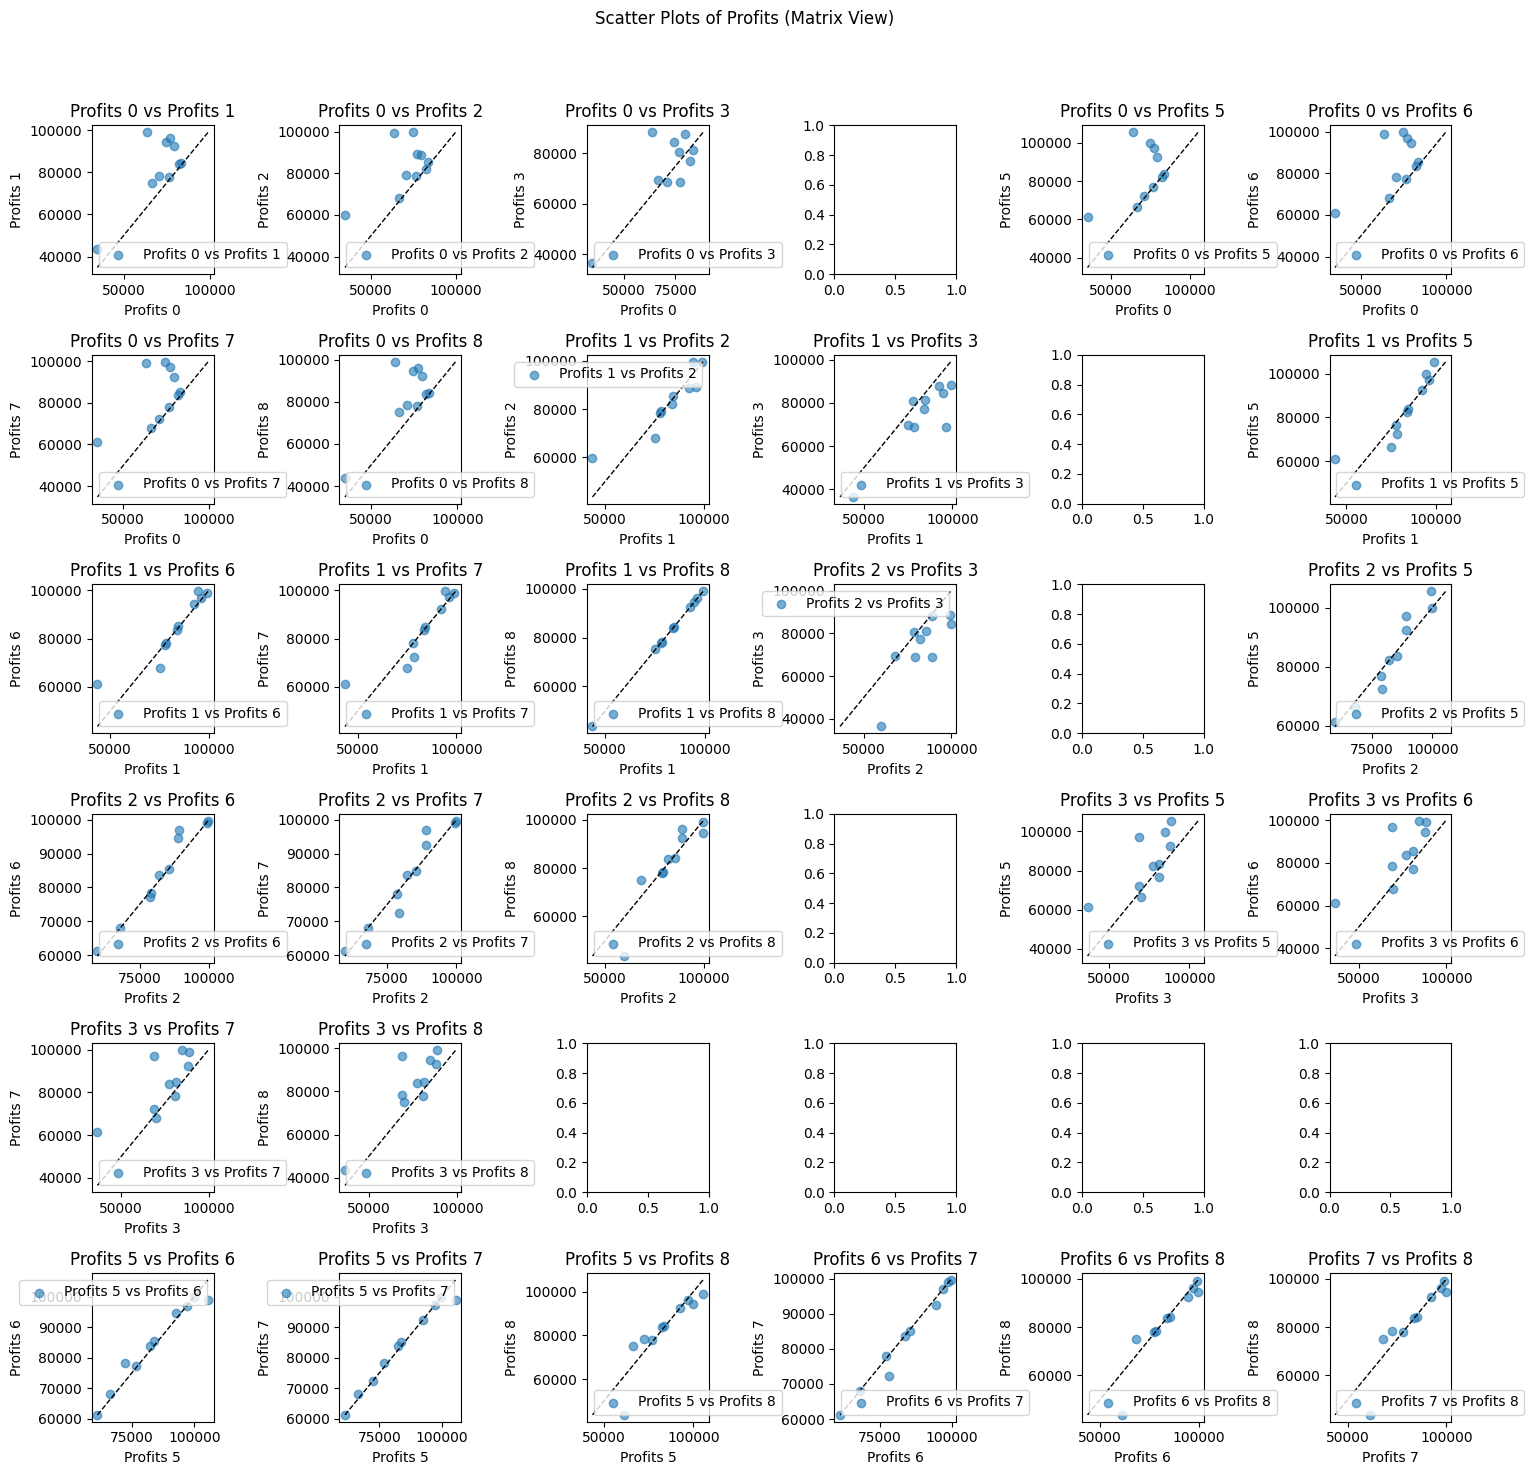

In [150]:
dfs = [
    baseline_stimulation_df,
    stimulation_results_df_1,
    stimulation_results_df_2,
    stimulation_results_df_3,
    stimulation_results_df_4,
    stimulation_results_df_5,
    stimulation_results_df_6,
    stimulation_results_df_7,
    stimulation_results_df_8,
]
plot_strategies_profits_scatter(save_type=f"{status}_{model_prefix}", dfs=dfs)

##### 二次補貨量

Plot saved as plots/plot_Q0_Q1_distribution_train_linear_constraint_med_with_holding_cost_0_20_S1_202411282053.png


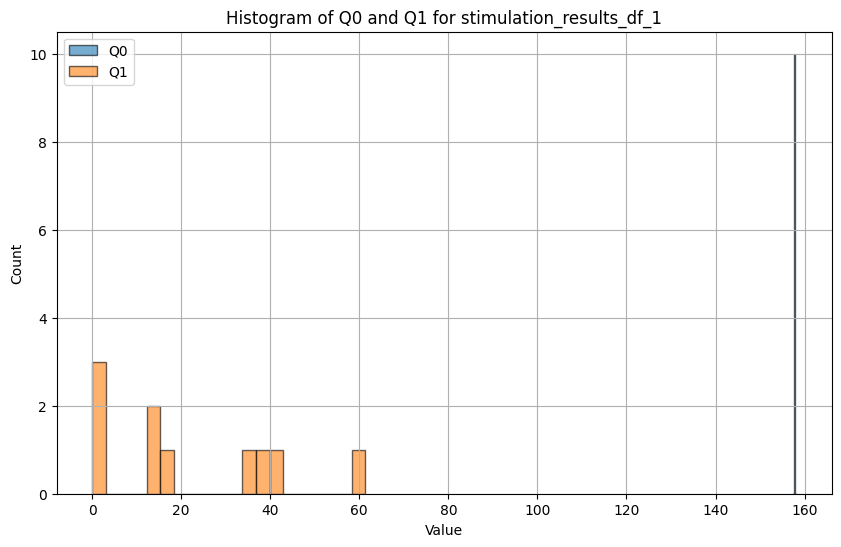

Plot saved as plots/plot_Q0_Q1_distribution_train_linear_constraint_med_with_holding_cost_0_20_S2_202411282053.png


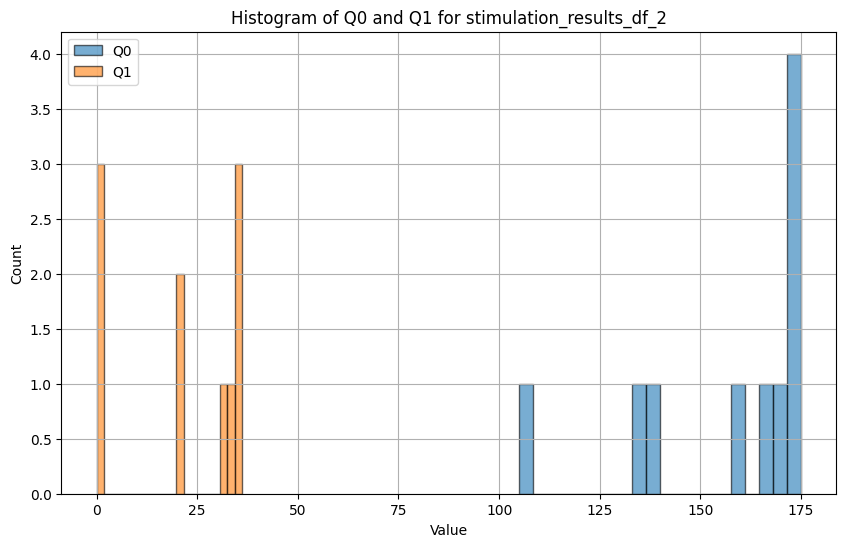

Plot saved as plots/plot_Q0_Q1_distribution_train_linear_constraint_med_with_holding_cost_0_20_S3_202411282053.png


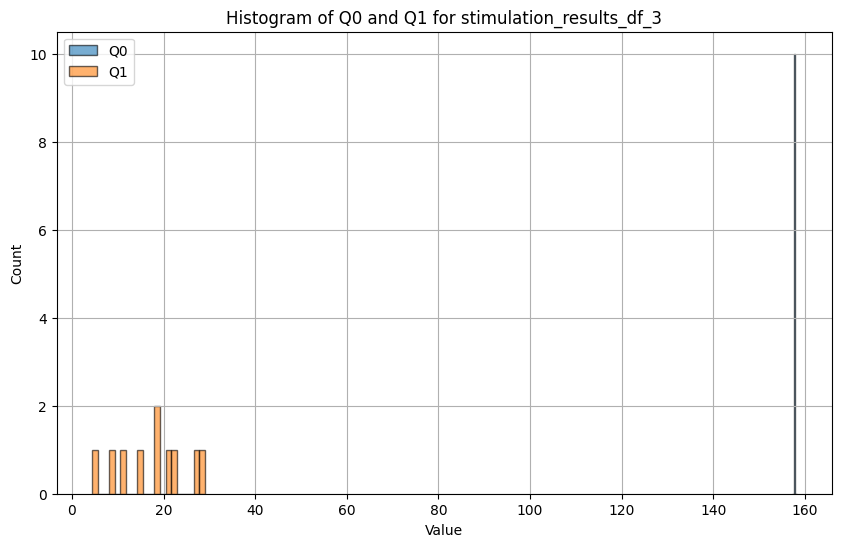

Plot saved as plots/plot_Q0_Q1_distribution_train_linear_constraint_med_with_holding_cost_0_20_S5_202411282053.png


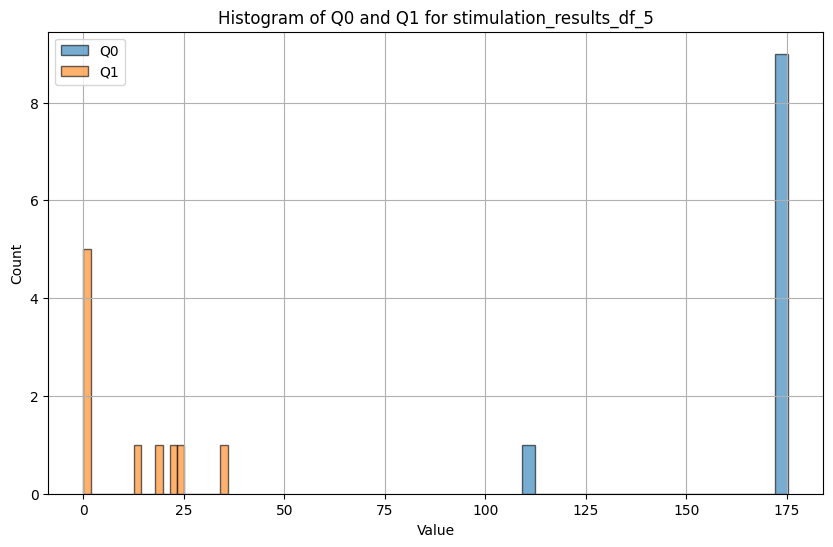

Plot saved as plots/plot_Q0_Q1_distribution_train_linear_constraint_med_with_holding_cost_0_20_S6_202411282053.png


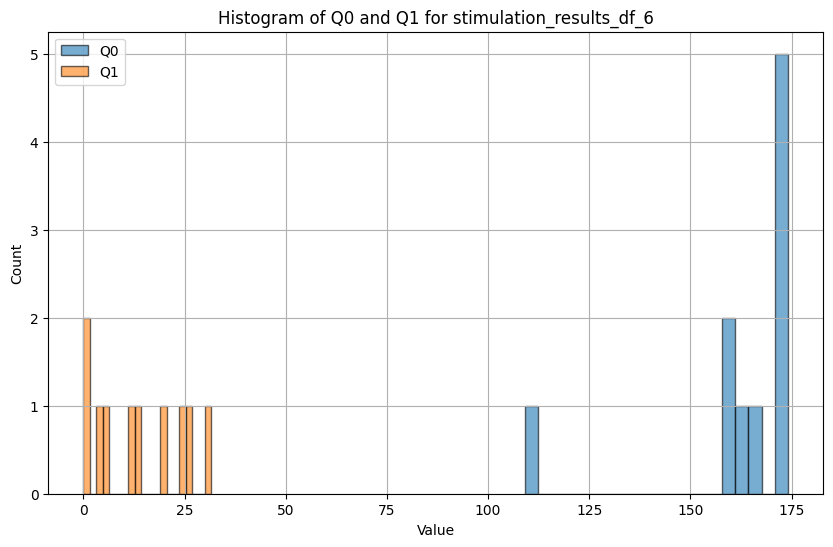

Plot saved as plots/plot_Q0_Q1_distribution_train_linear_constraint_med_with_holding_cost_0_20_S7_202411282053.png


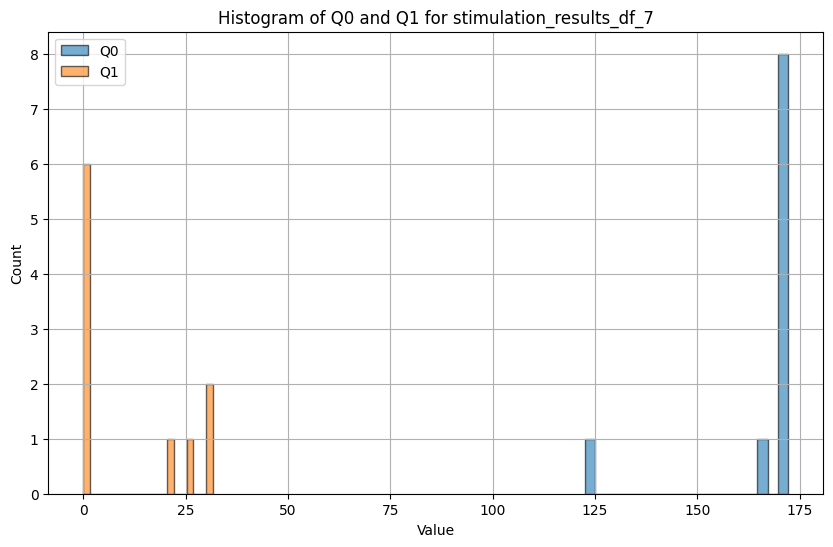

Plot saved as plots/plot_Q0_Q1_distribution_train_linear_constraint_med_with_holding_cost_0_20_S8_202411282053.png


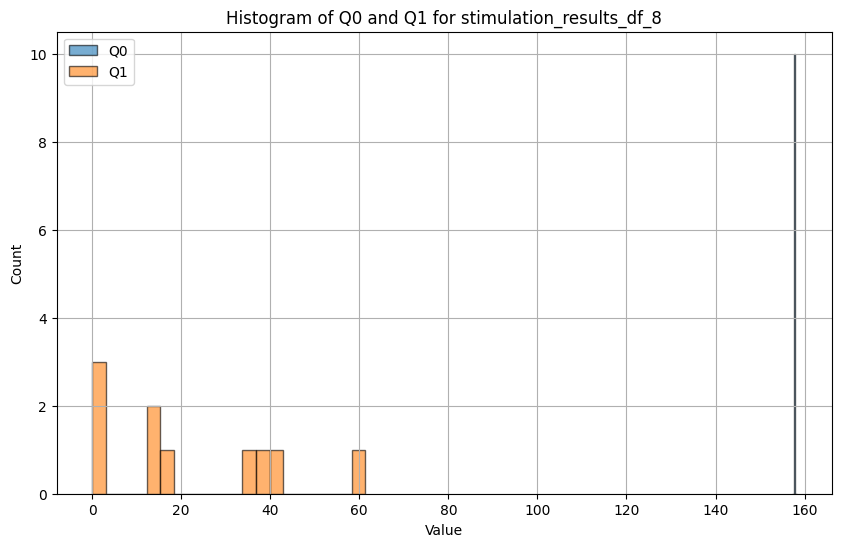

In [151]:
plot_Q0_Q1_distribution(f"{status}_{model_prefix}", dfs[1:])

##### 每一個 profits 對 Baseline 的 Deviation

Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_20_S1_202411282053.png


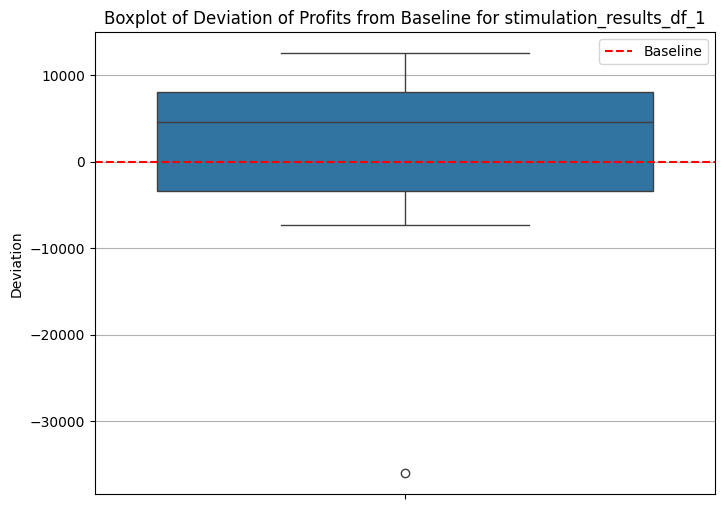

Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_20_S2_202411282053.png


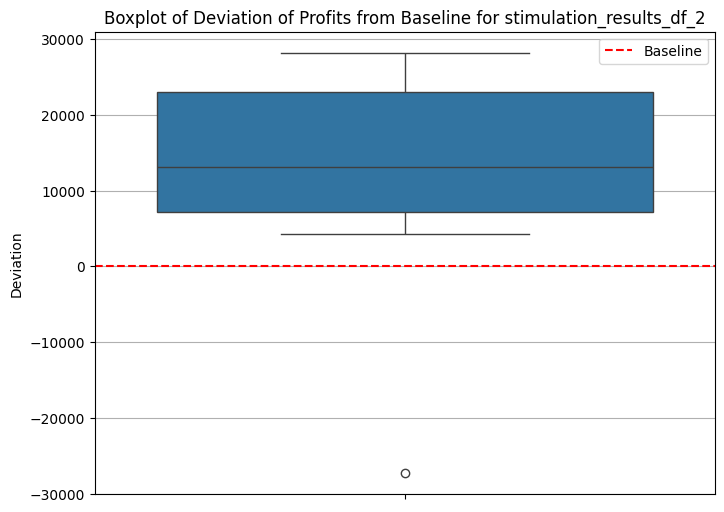

Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_20_S3_202411282053.png


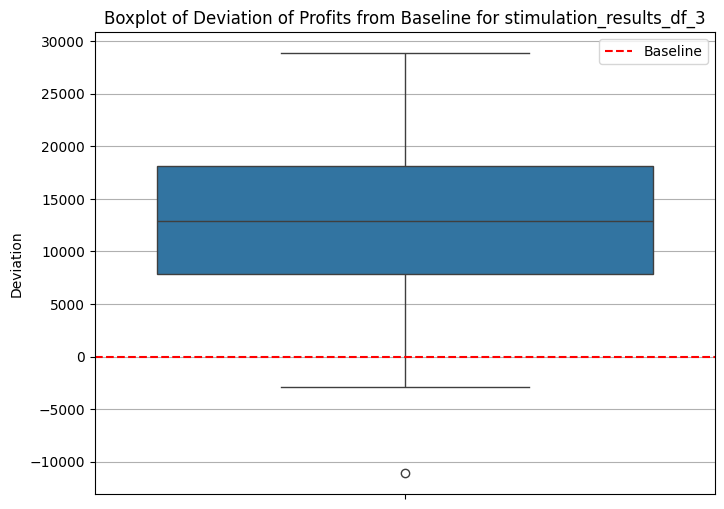

Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_20_S4_202411282053.png


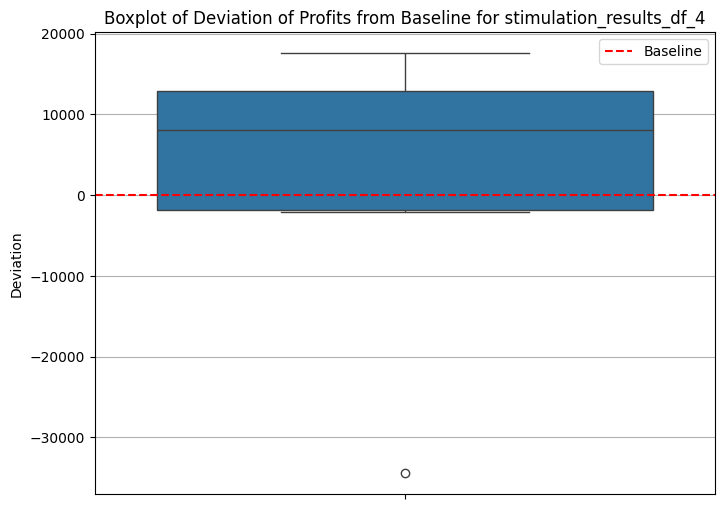

Skipping stimulation_results_df_5: Missing 'profits' column.
Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_20_S6_202411282053.png


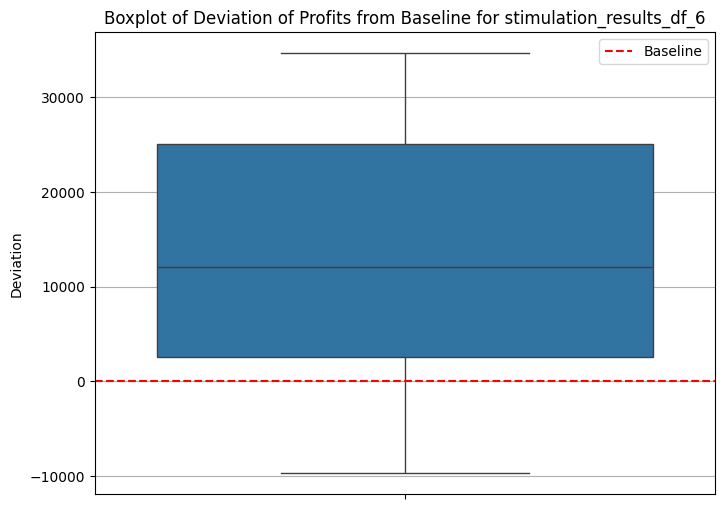

Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_20_S7_202411282053.png


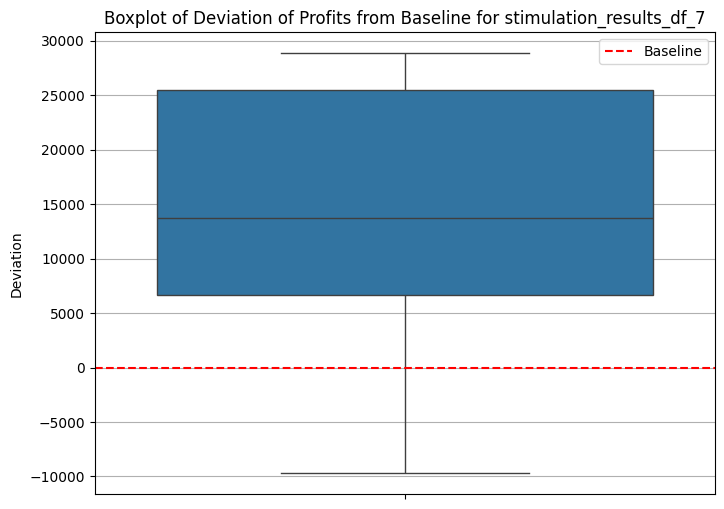

Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_20_S8_202411282053.png


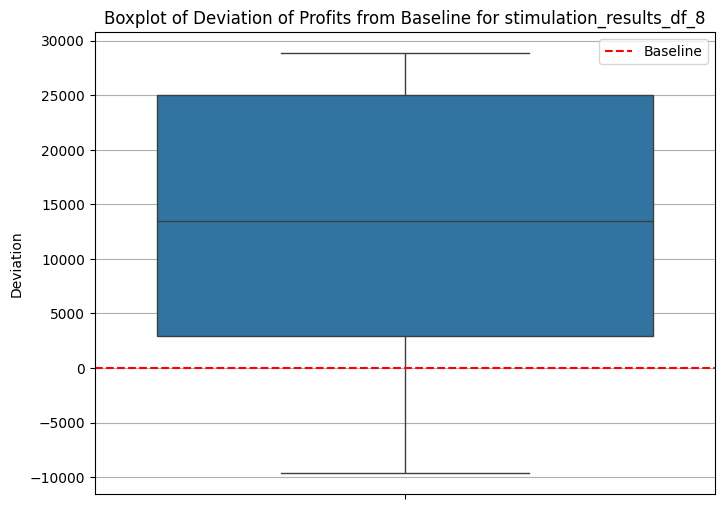

Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_20_S9_202411282053.png


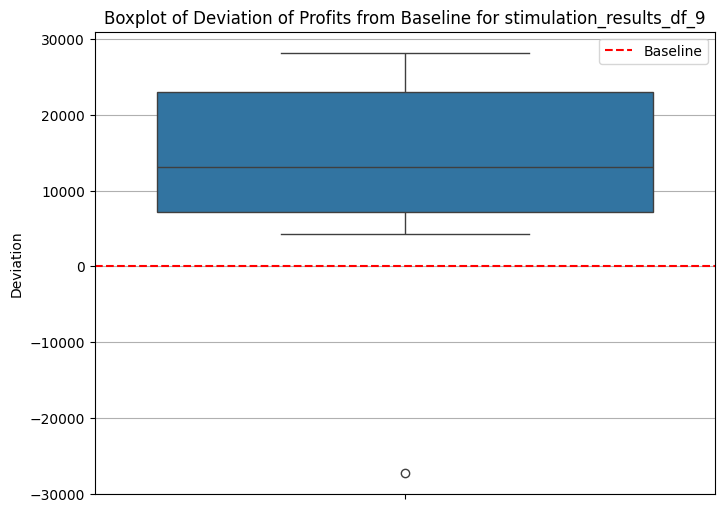

In [152]:
plot_profits_deviation_box_plot(
    f"{status}_{model_prefix}",
    dfs,
    baseline_avg_profits,
)

##### 最大利潤比較


Baseline is: 70874.1586454361
S1's profit: 82521.94427004398
S2's profit: 83029.47540650019
S3's profit: 74355.18154762611
S4's profit: -1
S5's profit: 83755.89414705205
S6's profit: 84391.96112380431
S7's profit: 83656.99062648592
S8's profit: 82521.94427004398
Plot saved as plots/plot_relative_profit_deviation_train_linear_constraint_med_with_holding_cost_0_20_202411282053.png


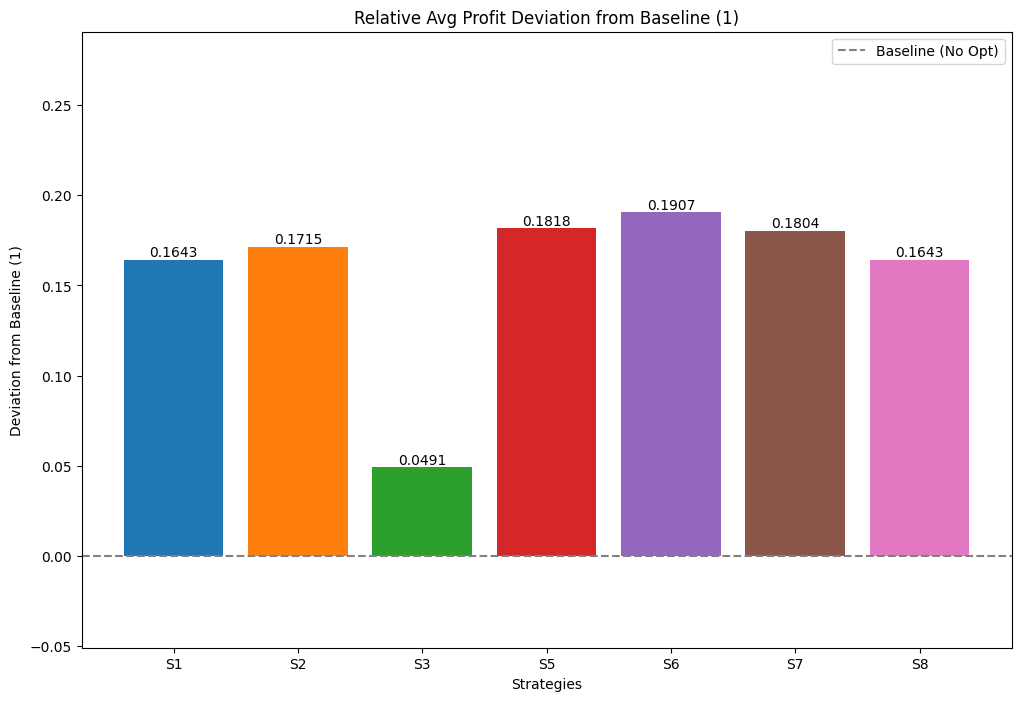

In [153]:
train_max_profits = [
    max_profit_for_s1,
    max_profit_for_s2,
    max_profit_for_s3,
    max_profit_for_s4,
    max_profit_for_s5,
    max_profit_for_s6,
    max_profit_for_s7,
    max_profit_for_s8,
]

plot_relative_profit_deviation(
    f"{status}_{model_prefix}", float(baseline_avg_profits), train_max_profits
)

#### Preparation


In [154]:
# overview
low_results_df_1 = results_df_1
low_results_df_2 = results_df_2
low_results_df_3 = results_df_3
low_results_df_4 = results_df_4
low_results_df_5 = results_df_5
low_results_df_6 = results_df_6
low_results_df_7 = results_df_7
low_results_df_8 = results_df_8

# max stimulation result
low_stimulation_results_df_1 = stimulation_results_df_1
low_stimulation_results_df_2 = stimulation_results_df_2
low_stimulation_results_df_3 = stimulation_results_df_3
low_stimulation_results_df_4 = stimulation_results_df_4
low_stimulation_results_df_5 = stimulation_results_df_5
low_stimulation_results_df_6 = stimulation_results_df_6
low_stimulation_results_df_7 = stimulation_results_df_7
low_stimulation_results_df_8 = stimulation_results_df_8

# max value
low_baseline_profit = baseline_avg_profits
low_max_profit_for_s1 = max_profit_for_s1
low_max_profit_for_s2 = max_profit_for_s2
low_max_profit_for_s3 = max_profit_for_s3
low_max_profit_for_s4 = max_profit_for_s4
low_max_profit_for_s5 = max_profit_for_s5
low_max_profit_for_s6 = max_profit_for_s6
low_max_profit_for_s7 = max_profit_for_s7
low_max_profit_for_s8 = max_profit_for_s8

## Testing


### Setting reasonable parameters


In [155]:
status = "test"

In [156]:
# Q star have to from demand_df_train
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 175.24908843677085
std of sum: 28.677047050944203
50.0 percentile of sum: 175.24908843677085
Q_star: 175.24908843677085


In [157]:
# compute Qk_hat_test with demand_df_test
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_test)
Qk_hat_df_test = make_Qk_hat_df(
    demand_df_test, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_test = Qk_hat_df_test.reset_index(drop=True)

print(f"Qk_hat_df_test shape: {Qk_hat_df_test.shape}")
Qk_hat_df_test.head()

Qk_hat_df_test shape: (10, 8)


Qk_hat_k2   Qk_hat_k3   Qk_hat_k4   Qk_hat_k5   Qk_hat_k6   Qk_hat_k7  \
0  203.047116  187.252041  179.167403  180.285901  195.735588  188.020244   
1  188.708675  197.502099  229.515326  229.567167  231.266286  237.430292   
2  200.035122  202.046362  213.774843  212.587385  215.582569  209.658991   
3  188.777032  210.073331  188.625853  187.351444  202.463700  213.959862   
4  181.207292  158.805438  170.233712  169.552409  180.209123  174.051305   

    Qk_hat_k8   Qk_hat_k9  
0  184.229375  185.467327  
1  224.937846  227.289038  
2  214.927729  215.819362  
3  218.618776  220.598738  
4  176.324059  172.471105

### Run all the strategies


Baseline

In [158]:
(
    test_baseline_avg_loss,
    test_baseline_avg_lefts,
    test_baseline_avg_profits,
    test_baseline_avg_operation_profits,
    test_stimulation_df_baseline,
) = one_time_procurement(
    Q_star=Q_star,
    demand_df=demand_df_test,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    holding_cost=holding_cost,
)

print(f"baseline_profit: {test_baseline_avg_profits}")

Processing row 1/10 with initial inventory Q_star=175.24908843677085
--------------------------------------------------
Day 1
Demand      : 30.44568030255325
Sales       : 30.44568030255325
Loss        : 0
Left        : 144.8034081342176
Inventory   : 144.8034081342176
Holding Cost: 0.0
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 16.69106023264269
Sales       : 16.69106023264269
Loss        : 0
Left        : 128.1123479015749
Inventory   : 128.1123479015749
Holding Cost: 0.0
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 20.980915120589653
Sales       : 20.980915120589653
Loss        : 0
Left        : 107.13143278098525
Inventory   : 107.13143278098525
Holding Cost: 0.0
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 23.954657711533788
Sales       : 23.9546577115

In [159]:
test_stimulation_df_baseline.head()

losses     lefts  operation_profits       profits
0  12.237584  0.000000       87624.544218  81505.752011
1  51.562830  0.000000       87624.544218  61843.129311
2  36.252455  0.000000       87624.544218  69498.316541
3  46.317829  0.000000       87624.544218  64465.629712
4   0.000000  2.651294       86298.897127  84973.250036

S1

In [160]:
test_results_df_1, test_stimulation_results_df_1 = None, None

if results_df_1 is not None:
    assigned_T = results_df_1.iloc[0]["R(T)"]
    assigned_F = results_df_1.iloc[0]["F"]

    test_results_df_1, test_stimulation_results_df_1 = cal_test_fixed_F_fixed_R(
        assigned_T=int(assigned_T),
        assigned_F=assigned_F,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
    )

test_results_df_1





這是第 1 筆模擬資料

F: 0.9, R: 8
Q_star 為 175.24908843677085
期初庫存 Q0: 157.72417959309377
重新估計量 Qk_hat: 184.22937543534164
訂貨量 Q1 為 26.505195842247872

第一階段：期初庫存 Q0: 157.72417959309377，需求量為 147.62804531604166，Sold_0 為 147.62804531604166，Left_0 為 10.096134277052101，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 36.60133011929997，需求量為 39.858627536102524，Sold_1 為 36.60133011929997，Left_1 為 0.0，Lost_1 為 3.257297416802551

統計結果：Sold 為 184.22937543534164, Lost 為 3.257297416802551 Left_Penalty_Cost 為 0.0，Lost_Penalty_Cost 為 1628.6487084012756，Profit 為 90486.03900926955
----------------------------------------
這是第 2 筆模擬資料

F: 0.9, R: 8
Q_star 為 175.24908843677085
期初庫存 Q0: 157.72417959309377
重新估計量 Qk_hat: 224.93784589224754
訂貨量 Q1 為 67.21366629915377

第一階段：期初庫存 Q0: 157.72417959309377，需求量為 164.521050058455，Sold_0 為 157.72417959309377，Left_0 為 0.0，Lost_0 為 6.7968704653612235
第二階段：期初庫存 Q1+left_0 為 67.21366629915377，需求量為 62.290868192480616，Sold_1 為 62.290868192480616，Left_1 為 4.922798106673156，Lost_1 為 0

統計結果：Sold 

R(T)    F                                                 Q0  \
0     8  0.9  [157.72417959309377, 157.72417959309377, 157.7...   

                                                  Q1  average_profits  \
0  [26.505195842247872, 67.21366629915377, 57.203...     89012.522878   

   average_losses  average_lefts  average_operation_profits  
0        3.582848       7.234821               94421.357144

S2

In [161]:
test_results_df_2, test_stimulation_results_df_2 = None, None

if results_df_2 is not None and len(results_df_2) > 0:
    assigned_R = results_df_2.iloc[0]["R"]
    alphas = results_df_2.iloc[0]["alpha_values"]

    test_results_df_2, test_stimulation_results_df_2 = cal_test_flexible_F_fixed_R(
        assigned_R=assigned_R[0],
        alphas=alphas,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
        testing_df=testing_df,
        holding_cost=holding_cost,
    )

test_results_df_2

assigned_R: 5


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/3758896648.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left  \
0     90152.858254           0.0           0.0   

                                        alpha_values  R(T)  
0  [1.6523898789912783, 0.6012641327032322, 4.068...     7

S3

In [162]:
results_df_3.head()

R(T)  average_losses  average_lefts  \
0  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]        4.128771     157.459308   

   average_operation_profits  average_profits  \
0               82022.055666     74355.181548   

                                         beta_values  \
0  [[-0.6000815035488267, 1.1935688309750148, -1....   

                                              F_vars  \
0  [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, ...   

                                             Q0_vars  \
0  [157.72417959309377, 157.72417959309377, 157.7...   

                                             Q1_vars  \
0  [18.146750891704983, 14.365200090509655, 21.58...   

                                          tau_values  
0  [[-1.8893619633996008, -2.8339584644000886, -1...

In [163]:
test_results_df_3, test_stimulation_results_df_3 = None, None

if results_df_3 is not None and len(results_df_3) > 0:
    assigned_F = results_df_3.iloc[0]["F_vars"]
    betas = results_df_3.iloc[0]["beta_values"]
    print(f"betas: {betas}")
    test_results_df_3, test_stimulation_results_df_3 = cal_test_fixed_F_flexible_R(
        assigned_F=assigned_F[0],
        betas=betas,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
        testing_df=testing_df,
        holding_cost=holding_cost,
    )

test_results_df_3

betas: [[ -0.6000815    1.19356883  -1.48078983]
 [ -1.28121675   1.30882997  -1.8865421 ]
 [  0.38377356   0.87656165  -1.79715306]
 [  0.59841638  -0.52899536  -0.8176852 ]
 [  1.97734343  -1.24674181  -2.79861596]
 [ -3.10021318   2.0484624  -10.93754228]
 [  4.54665373  -1.91390841  -6.19167928]
 [ -4.75550788   5.33652866  -8.02561452]]


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/2776381693.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left  \
0     87892.020824  11717.068186  11717.068186   

                                         beta_balues    F  
0  [[-0.6000815035488267, 1.1935688309750148, -1....  0.9

In [164]:
test_stimulation_results_df_3

F  R(T)      Sold_0     Left_0     Lost_0     Sold_1     Left_1  \
0  0.9     7  131.062374  26.661805   0.000000  56.424298   0.533571   
1  0.9     7  141.836486  15.887694   0.000000  84.975433  10.618373   
2  0.9     7  145.629671  12.094508   0.000000  64.029319   0.000000   
3  0.9     9  157.724180   0.000000   9.884856  53.957882   8.916676   
4  0.9     9  119.481856  38.242324   0.000000  52.989249   0.000000   
5  0.9     7  118.989299  38.734881   0.000000  82.485311   0.000000   
6  0.9     9  120.385857  37.338323   0.000000  44.521384   1.015956   
7  0.9     9  157.724180   0.000000   0.356402  43.203656   0.000000   
8  0.9     9   84.411406  73.312773   0.000000  36.217668  37.095105   
9  0.9     9  157.724180   0.000000  23.434136  27.682074  22.635810   

     Lost_1        profits         Q0         Q1         hc0         hc1  
0  0.000000   93476.550692  157.72418  30.296065  644.046148   86.237162  
1  0.000000  108096.772390  157.72418  79.706112  759.953957  159.318269  
2  1.842553  103908.218849  157.72418  51.934811  665.260497   96.043979  
3  0.000000   96440.265095  157.72418  62.874558  882.394951   35.895617  
4  0.126689   86172.207834  157.72418  14.746925  842.853714   26.494625  
5  4.345475   98564.567555  157.72418  43.750430  720.628471  123.727966  
6  0.000000   81945.642576  157.72418   8.199018  813.046081   23.276648  
7  2.809744   98880.844616  157.72418  43.203656  803.711342   21.601828  
8  0.000000   41766.984778  157.72418   0.000000  924.147812   55.203939  
9  0.000000   69668.153856  157.72418  50.317884  832.168254   36.476847

S4

In [165]:
test_results_df_4, test_stimulation_results_df_4 = None, None

if results_df_4 is not None:
    alphas = results_df_4.iloc[0]["alpha_values"]
    betas = results_df_4.iloc[0]["beta_values"]

    test_results_df_4, test_stimulation_results_df_4 = (
        cal_test_fully_flexible_beta_with_softmax_4(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
            holding_cost=holding_cost,
        )
    )

test_results_df_4

In [166]:
# import numpy as np

# # Provided data
# betas = np.array(
#     [
#         [0.00000000e00, 0.00000000e00, -8.94906903e-02],
#         [-3.13562128e-02, 4.00627944e-03, -6.21189321e-02],
#         [3.97911689e-02, 1.78930917e-02, -4.96275009e-02],
#         [0.00000000e00, 0.00000000e00, 0.00000000e00],
#         [0.00000000e00, 0.00000000e00, 0.00000000e00],
#         [0.00000000e00, 0.00000000e00, 0.00000000e00],
#         [0.00000000e00, 0.00000000e00, 0.00000000e00],
#         [3.50517907e-05, 1.43159496e-03, -3.20821046e-03],
#     ]
# )
# X_data = np.array([1.4397189210284136, -0.794923445271338, 1])

# # Initialization
# features_num = len(X_data)
# tau_vars = np.zeros((1, len(betas)))  # Assuming one data point for simplicity
# exp_tau_vars = np.zeros_like(tau_vars)
# r_vars = np.zeros_like(tau_vars)
# R_vars = np.zeros_like(tau_vars)

# # Calculate tau_vars
# for k in range(len(betas)):
#     tau_vars[0, k] = sum(X_data[j] * betas[k, j] for j in range(features_num))

# # Step 2: Calculate the exponentials of -tau_vars
# exp_tau_vars[0] = np.exp(-tau_vars[0])

# # Step 3: Softmax normalization
# sum_exp_tau = np.sum(exp_tau_vars[0])  # Sum of exponentials for normalization
# r_vars[0] = exp_tau_vars[0] / sum_exp_tau  # Normalize to get softmax

# # Step 4: Find the index of the maximum r_var and set R_vars
# max_r_index = np.argmax(r_vars[0])
# R_vars[0, max_r_index] = 1

# print(f"tau_vars: {tau_vars}")
# print(f"exp_tau_vars: {exp_tau_vars}")
# print(f"r_vars: {r_vars}")
# print(f"R_vars: {R_vars}")

# # Print the final R matrix
# print("Final R matrix:")
# print(R_vars)

In [167]:
test_stimulation_results_df_4

S5

In [168]:
test_results_df_5, test_stimulation_results_df_5 = None, None

if results_df_5 is not None:
    alphas = results_df_5.iloc[0]["alpha_values"]
    betas = results_df_5.iloc[0]["beta_values"]

    test_results_df_5, test_stimulation_results_df_5 = (
        cal_test_fully_flexible_simple_beta_with_softmax_5(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
            holding_cost=holding_cost,
        )
    )

test_results_df_5

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/2289234698.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left  \
0     87456.777815           0.0           0.0   

                                   alpha_values  \
0  [0.0, 3.2613734036584305, 8.023476481669615]   

                                         beta_balues  
0  [[0.0], [-0.08949071067430804], [-0.0894906902...

In [169]:
test_stimulation_results_df_5

F  R(T)      Sold_0      Left_0  Lost_0      Sold_1     Left_1  \
0  0.999993     6  120.233774   55.014158     0.0   67.252899   8.248915   
1  0.999961     6  111.892502   63.349834     0.0  114.919416   4.454367   
2  0.999839     6  129.924462   45.296365     0.0   81.577082   4.081025   
3  0.998865     6  106.850281   68.199958     0.0   95.613418   0.000000   
4  0.974437     6   69.945412  100.823849     0.0  102.652382   7.611328   
5  0.999644     6   93.398290   81.788429     0.0   89.221556   0.000000   
6  0.896765     6   78.120148   79.037093     0.0   86.787093  11.616837   
7  0.999357     6  107.135178   68.001227     0.0   89.897817   0.000000   
8  0.864803     6   72.161991   79.393899     0.0   48.467083  30.926816   
9  0.997633     6  129.367714   45.466512     0.0   79.472676   9.451888   

      Lost_1        profits          Q0         Q1         hc0         hc1  
0   0.000000   89618.878772  175.247932  20.487656  626.874365  167.501459  
1   0.000000  111178.775423  175.242337  56.023949  736.540300  247.656301  
2   0.000000  103710.259157  175.220827  40.361742  652.197337  179.478266  
3  19.103218   91680.240820  175.050240  27.413460  676.659144  191.226836  
4   0.000000   82493.232895  170.769261   9.439862  702.582430  235.750079  
5  23.200238   79709.803832  175.186720   7.433126  661.020689  178.443111  
6   0.000000   76645.202386  157.157242  19.366836  638.902928  220.041532  
7   7.060987   94986.004277  175.136405  21.896591  662.585555  179.795635  
8   0.000000   44851.129438  151.555890   0.000000  577.374473  220.641429  
9   0.000000   99694.251152  174.834225  43.458053  659.396974  196.752904

S6

In [170]:
test_results_df_6, test_stimulation_results_df_6 = None, None

if results_df_6 is not None:
    alphas = results_df_6.iloc[0]["alpha_values"]
    betas = results_df_6.iloc[0]["beta_values"]

    test_results_df_6, test_stimulation_results_df_6 = (
        cal_test_fully_flexible_simple_beta_with_softmax_6(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
            holding_cost=holding_cost,
        )
    )

test_results_df_6

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/492182808.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left  \
0     78845.460184   5574.677834   5574.677834   

                                        alpha_values  \
0  [0.5479427377659902, 0.9442304595010617, 3.503...   

                                         beta_balues  
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....

In [171]:
test_stimulation_results_df_6

F  R(T)     Sold_0      Left_0  Lost_0      Sold_1     Left_1  \
0  0.995232     2  30.445680  143.967891     0.0  157.040993  15.560443   
1  0.991012     2  19.035358  154.638607     0.0  169.673317   0.000000   
2  0.990066     2  28.048780  145.459311     0.0  171.986343   0.000000   
3  0.985603     2  19.089756  153.636239     0.0  169.687276   0.000000   
4  0.951161     2  13.065868  153.624262     0.0  159.531926   8.609498   
5  0.986571     2  23.325171  149.570528     0.0  170.774169   0.000000   
6  0.861045     2  15.863114  135.034229     0.0  149.044128  19.815127   
7  0.986793     2  22.881244  150.053368     0.0  170.660249   0.000000   
8  0.846472     2  21.993667  126.349698     0.0   98.635408  71.797070   
9  0.963816     2  26.183389  142.724474     0.0  171.507646   0.000000   

      Lost_1       profits          Q0         Q1         hc0         hc1  
0   0.000000  85963.114728  174.413571  28.633545  173.507504  752.647517  
1  38.103243  75302.715781  173.673966  15.034709  171.673641  678.693266  
2  11.466421  94284.350406  173.508090  26.527032  172.747216  687.945371  
3  32.789885  77993.573459  172.725995  16.051037  171.206636  678.749104  
4   0.000000  81994.148067  166.690130  14.517163  167.415777  707.003691  
5  11.720744  91189.298547  172.895700  21.203641  171.834935  683.096677  
6   0.000000  72546.057356  150.897342  33.825026  159.878298  754.697524  
7  10.552489  91494.501918  172.934613  20.606880  171.797431  682.640995  
8   0.000000  24416.002155  148.343364  44.082780  159.387921  968.918194  
9  11.149356  93270.839420  168.907863  28.783172  170.207754  686.030583

S7

In [172]:
test_results_df_7, test_stimulation_results_df_7 = None, None

if results_df_7 is not None:
    alphas = results_df_7.iloc[0]["alpha_values"]
    betas = results_df_7.iloc[0]["beta_values"]

    print(f"alphas: {alphas}")
    print(f"betas: {betas}")

    test_results_df_7, test_stimulation_results_df_7 = (
        cal_test_fully_flexible_simple_beta_with_softmax_7(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
            holding_cost=holding_cost,
        )
    )

test_results_df_7

alphas: [0.00000000e+00 1.14562553e-06 3.99999848e+00]
betas: [[-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [ 0.]]


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_19550/932383180.py:101: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left  \
0     78845.460184   5574.677834   5574.677834   

                                        alpha_values  \
0  [0.0, 1.1456255267694737e-06, 3.9999984788434135]   

                                         beta_balues  
0  [[-4.0], [-4.0], [-4.0], [-4.0], [-4.0], [-4.0...

S8

In [173]:
test_results_df_8, test_stimulation_results_df_8 = None, None

if results_df_8 is not None:
    assigned_T = results_df_8.iloc[0]["R(T)"]
    assigned_F = results_df_8.iloc[0]["F"]

    test_results_df_8, test_stimulation_results_df_8 = (
        cal_test_fixed_F_fixed_R_with_holding_cost(
            assigned_T=int(assigned_T),
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            holding_cost=holding_cost,
        )
    )

test_results_df_8

R(T)    F                                                 Q0  \
0     8  0.9  [157.72417959309377, 157.72417959309377, 157.7...   

                                                  Q1  average_profits  \
0  [26.505195842247872, 67.21366629915377, 57.203...     89012.522878   

   average_losses  average_lefts  average_operation_profits  
0        3.582848       7.234821               94421.357144

### Analysis

#### 組內比較

##### Profits Scatter

Plot saved as plots/plot_strategies_profits_scatter_test_linear_constraint_med_with_holding_cost_0_20_202411282053.png


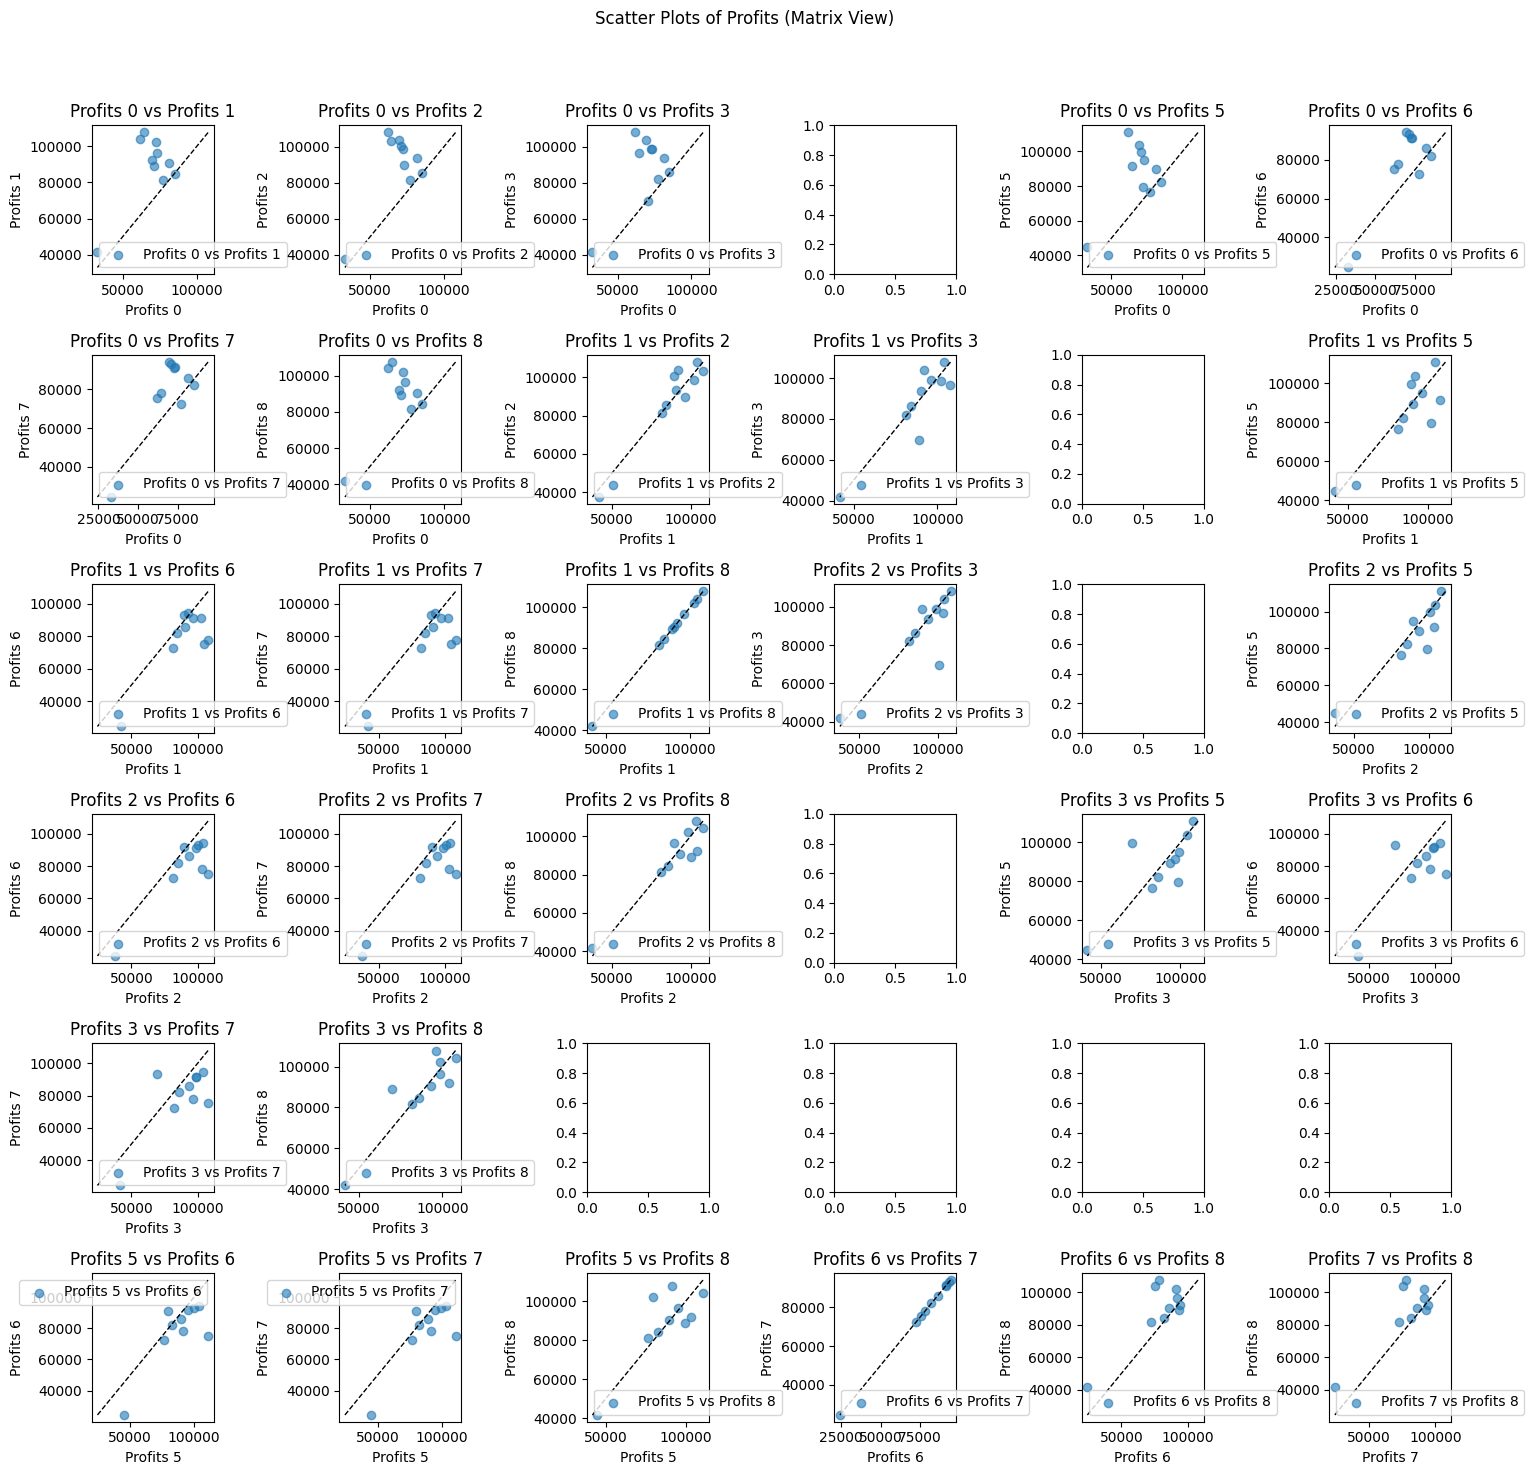

In [174]:
dfs = [
    test_stimulation_df_baseline,
    test_stimulation_results_df_1,
    test_stimulation_results_df_2,
    test_stimulation_results_df_3,
    test_stimulation_results_df_4,
    test_stimulation_results_df_5,
    test_stimulation_results_df_6,
    test_stimulation_results_df_7,
    test_stimulation_results_df_8,
]

plot_strategies_profits_scatter(f"{status}_{model_prefix}", dfs)

##### Profit Deviation

Baseline is: 68894.33422046283
S1's profit: 89012.52287780863
S2's profit: 90152.85825386114
S3's profit: 87892.02082427246
S4's profit: -1
S5's profit: 87456.77781514337
S6's profit: 78845.46018365349
S7's profit: 78845.46018365349
S8's profit: 89012.52287780863
Plot saved as plots/plot_relative_profit_deviation_test_linear_constraint_med_with_holding_cost_0_20_202411282053.png


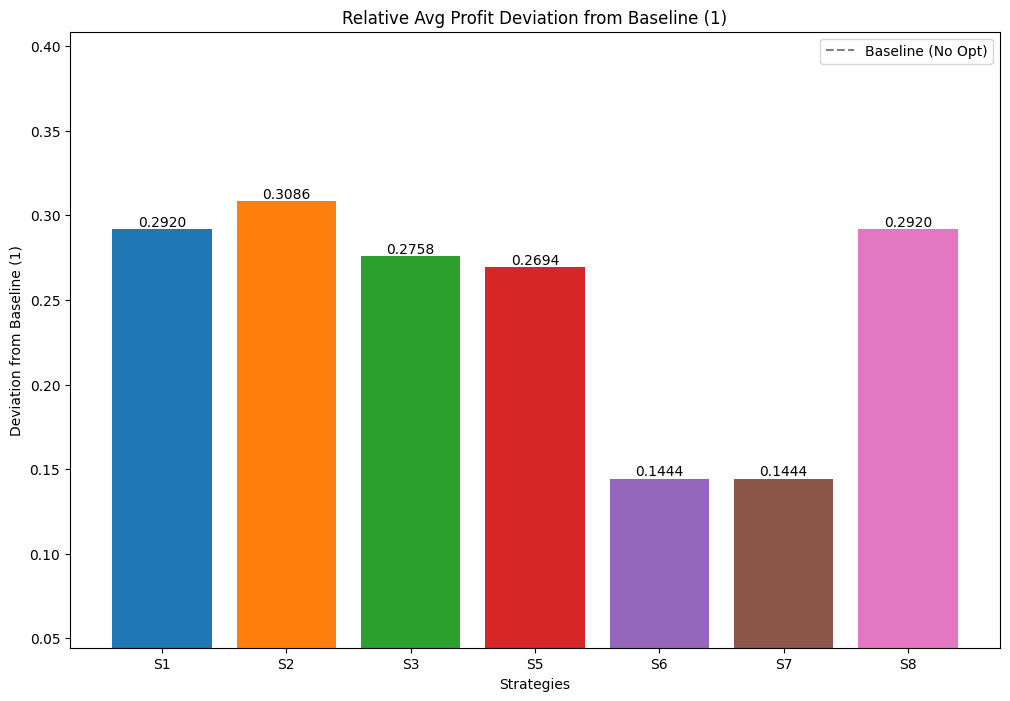

In [175]:
test_max_profits = [
    (
        test_results_df_1.iloc[0]["average_profits"]
        if test_results_df_1 is not None
        else -1
    ),
    (
        test_results_df_2.iloc[0]["average_profits"]
        if test_results_df_2 is not None
        else -1
    ),
    (
        test_results_df_3.iloc[0]["average_profits"]
        if test_results_df_3 is not None
        else -1
    ),
    (
        test_results_df_4.iloc[0]["average_profits"]
        if test_results_df_4 is not None
        else -1
    ),
    (
        test_results_df_5.iloc[0]["average_profits"]
        if test_results_df_5 is not None
        else -1
    ),
    (
        test_results_df_6.iloc[0]["average_profits"]
        if test_results_df_6 is not None
        else -1
    ),
    (
        test_results_df_7.iloc[0]["average_profits"]
        if test_results_df_7 is not None
        else -1
    ),
    (
        test_results_df_8.iloc[0]["average_profits"]
        if test_results_df_8 is not None
        else -1
    ),
]
plot_relative_profit_deviation(
    f"{status}_{model_prefix}", test_baseline_avg_profits, test_max_profits
)

##### 二次補貨量

Plot saved as plots/plot_Q0_Q1_distribution_test_linear_constraint_med_with_holding_cost_0_20_S1_202411282053.png


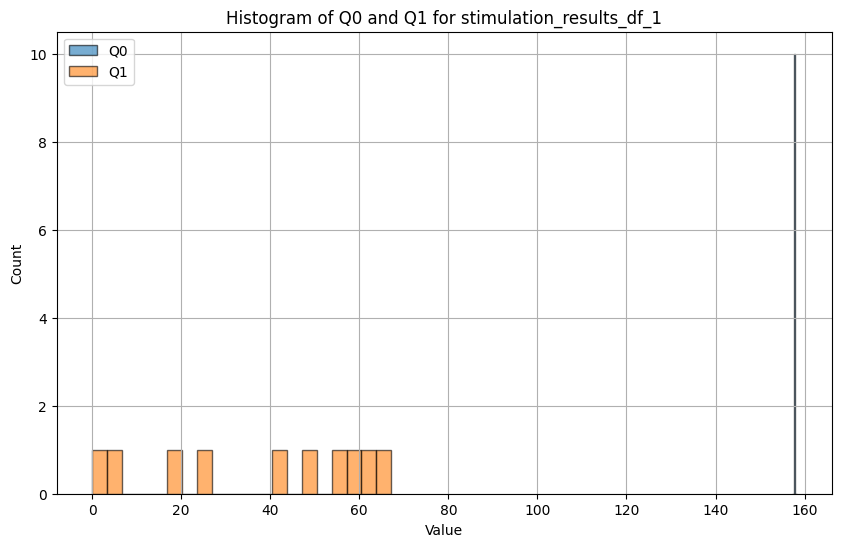

Plot saved as plots/plot_Q0_Q1_distribution_test_linear_constraint_med_with_holding_cost_0_20_S2_202411282053.png


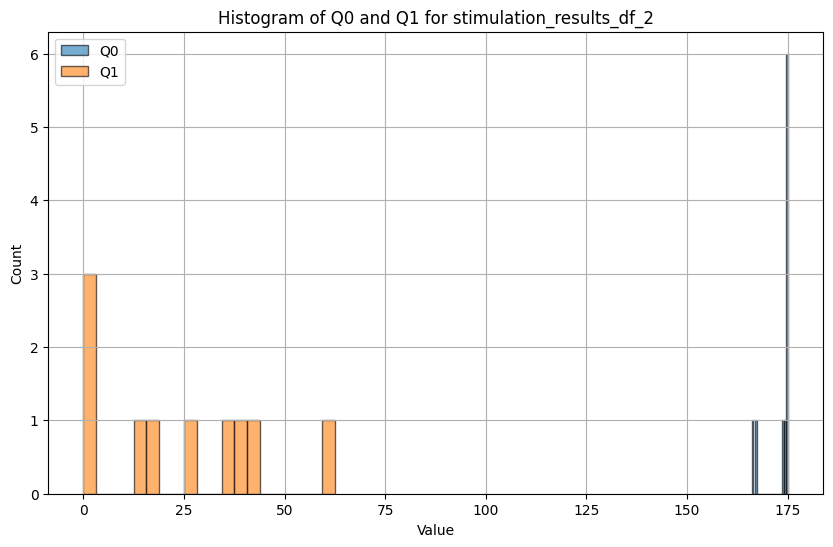

Plot saved as plots/plot_Q0_Q1_distribution_test_linear_constraint_med_with_holding_cost_0_20_S3_202411282053.png


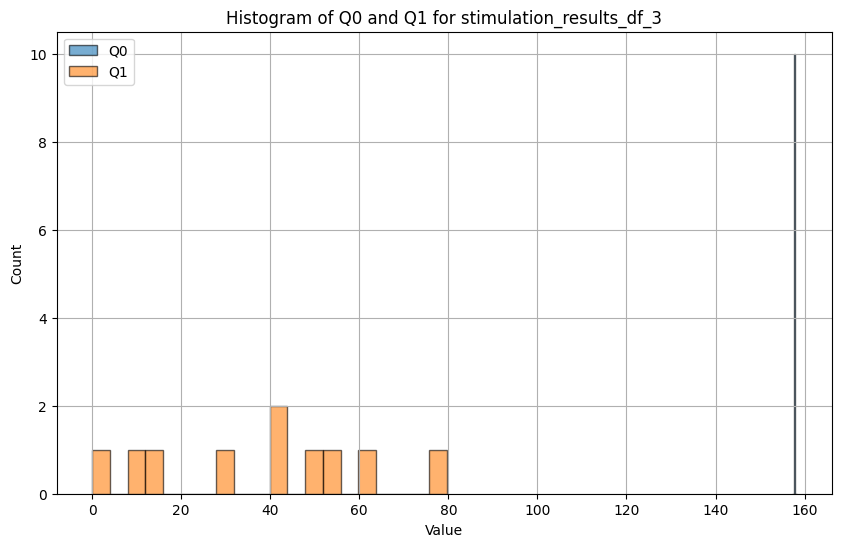

Plot saved as plots/plot_Q0_Q1_distribution_test_linear_constraint_med_with_holding_cost_0_20_S5_202411282053.png


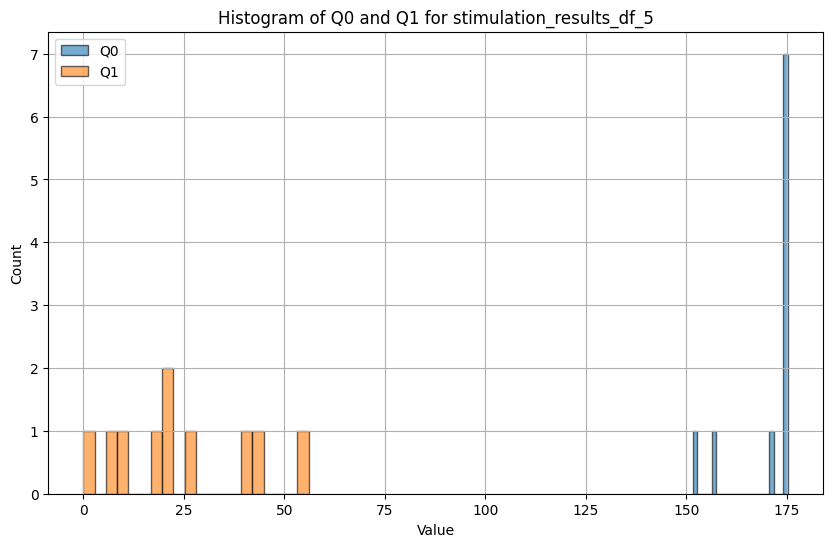

Plot saved as plots/plot_Q0_Q1_distribution_test_linear_constraint_med_with_holding_cost_0_20_S6_202411282053.png


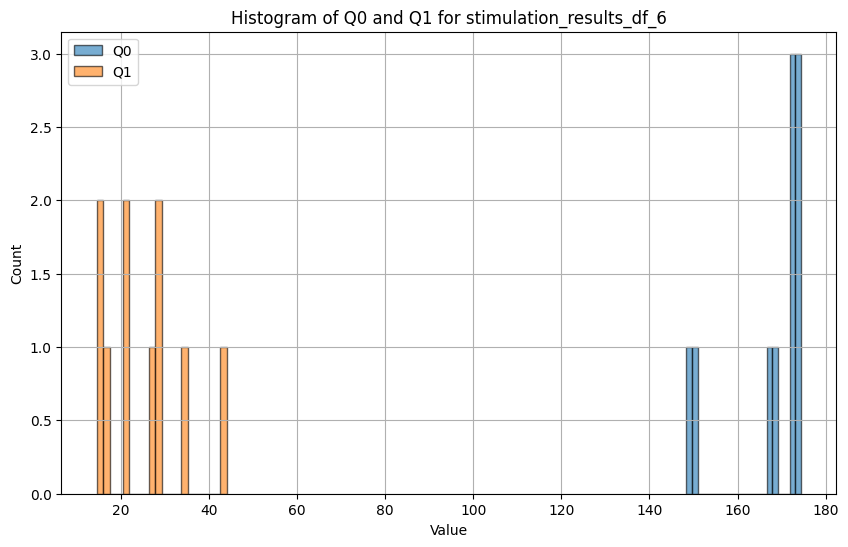

Plot saved as plots/plot_Q0_Q1_distribution_test_linear_constraint_med_with_holding_cost_0_20_S7_202411282053.png


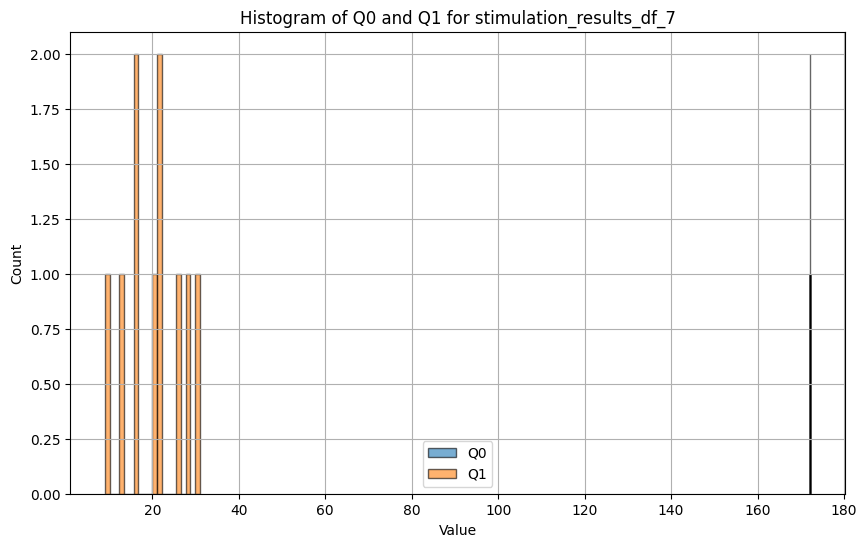

Plot saved as plots/plot_Q0_Q1_distribution_test_linear_constraint_med_with_holding_cost_0_20_S8_202411282053.png


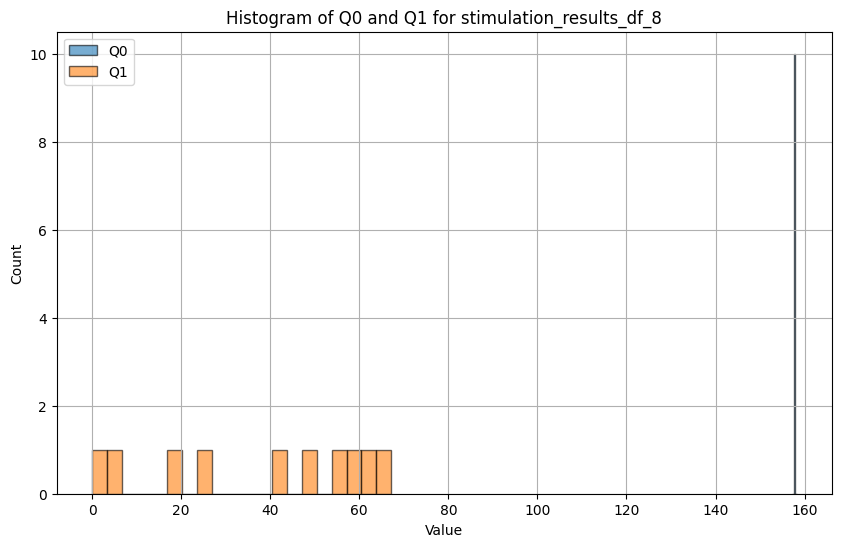

In [176]:
plot_Q0_Q1_distribution(f"{status}_{model_prefix}", dfs[1:])

##### 每一個 profits 對 Baseline 的 Deviation

Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_20_S1_202411282053.png


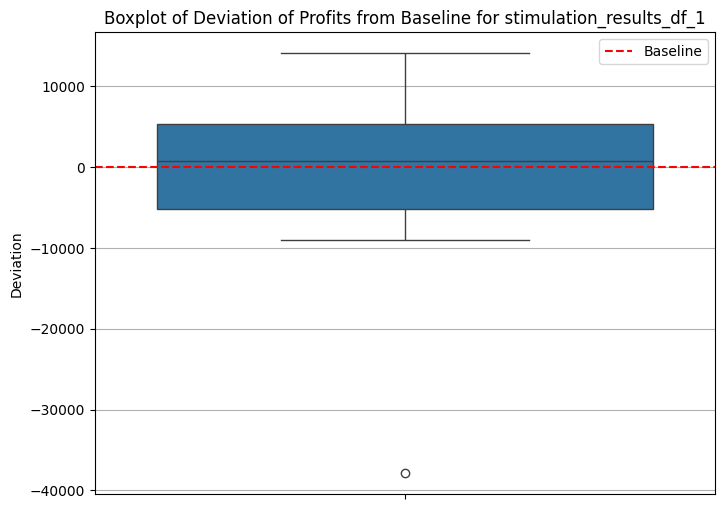

Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_20_S2_202411282053.png


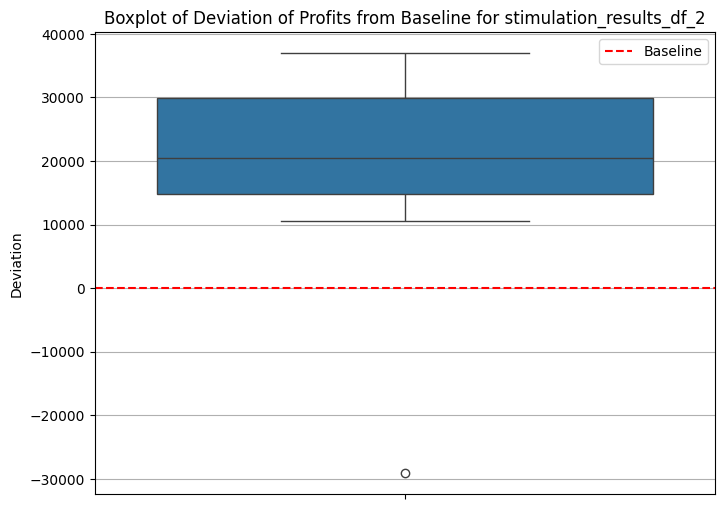

Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_20_S3_202411282053.png


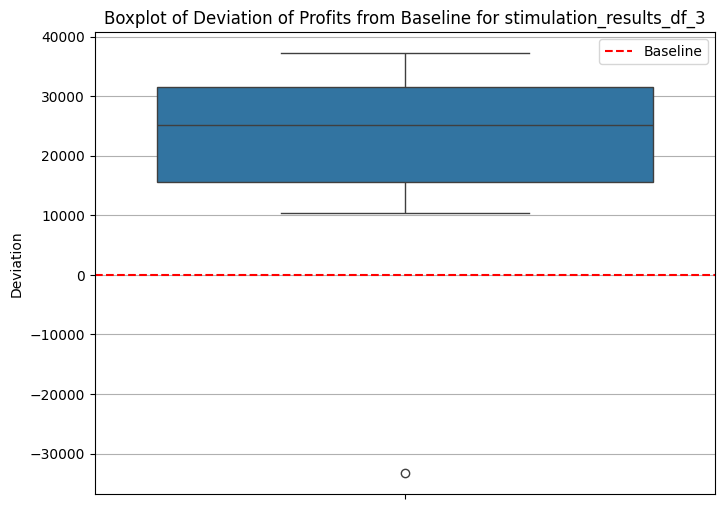

Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_20_S4_202411282053.png


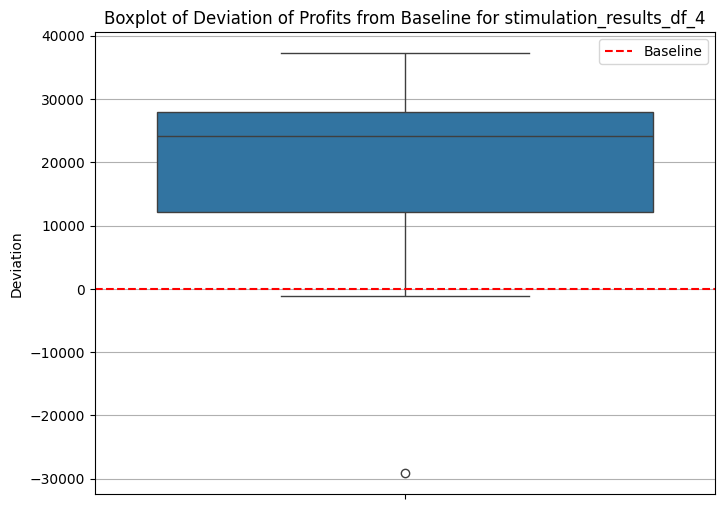

Skipping stimulation_results_df_5: Missing 'profits' column.
Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_20_S6_202411282053.png


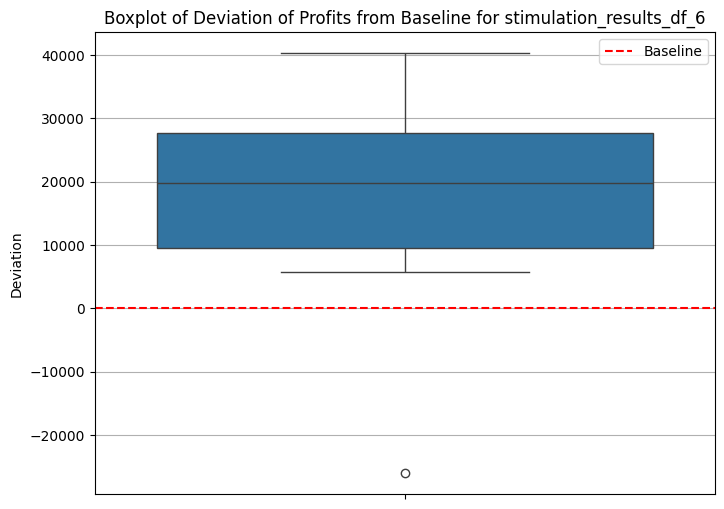

Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_20_S7_202411282053.png


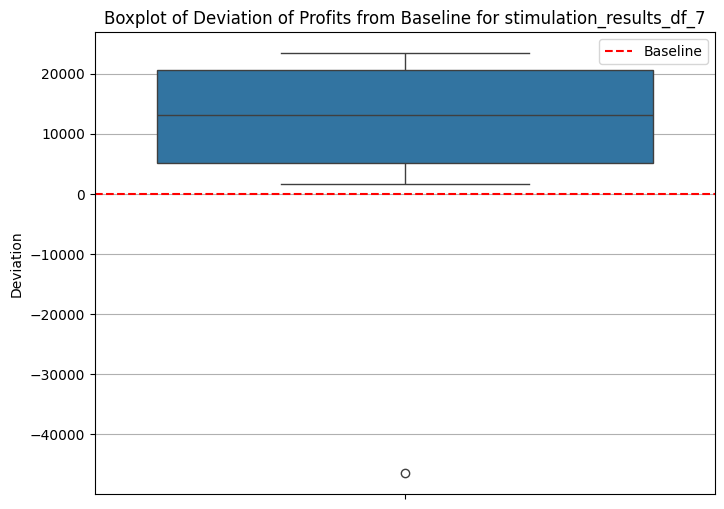

Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_20_S8_202411282053.png


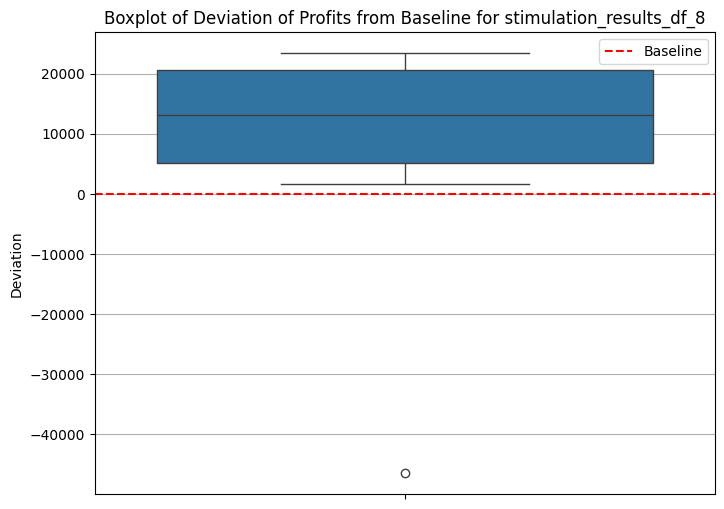

Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_20_S9_202411282053.png


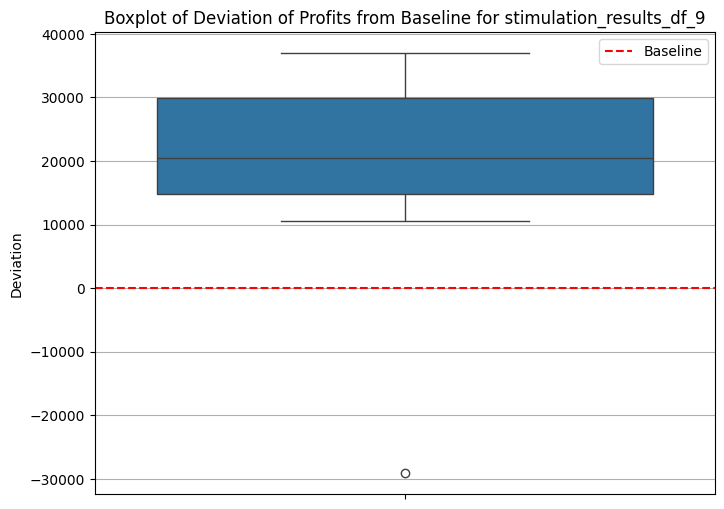

In [177]:
plot_profits_deviation_box_plot(f"{status}_{model_prefix}", dfs, baseline_avg_profits)

#### 訓練 vs. 測試

與各自的 Baseline 相比

Plot saved as plots/plot_relative_profit_comparison_test_linear_constraint_med_with_holding_cost_0_20_202411282053.png


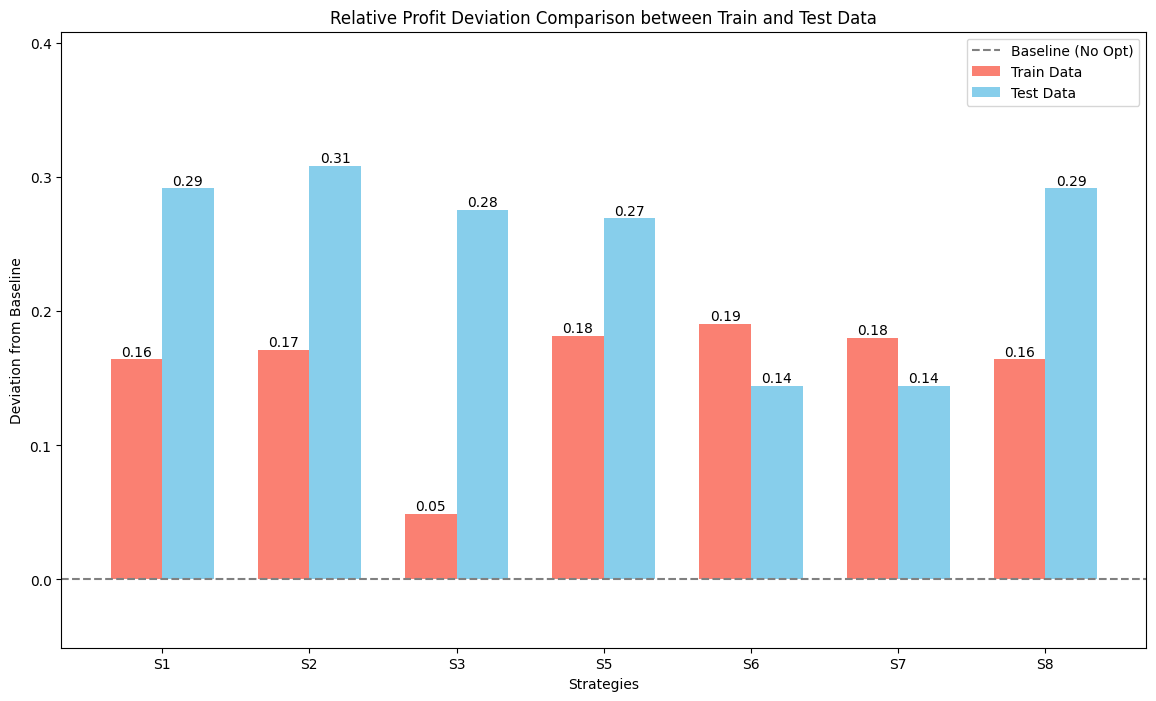

In [178]:
# Plot the comparison
plot_relative_profit_comparison(
    save_type=f"{status}_{model_prefix}",
    train_baseline_profit=baseline_avg_profits,
    test_baseline_profit=test_baseline_avg_profits,
    test_max_profits=test_max_profits,
    train_max_profits=train_max_profits,
)

因為 baseline 的 hc 計算是低估的，所以通常其他的策略會比較低是正常的。

因此可以看 S8 的表現來進行相對性的評估會比較正確。

#### Root Analysis

將參數 show 出來比較與分析

### Preparation

In [179]:
# 將變數名稱存取為此 Margin 特別的變數
# overview
low_test_results_df_1 = test_results_df_1
low_test_results_df_2 = test_results_df_2
low_test_results_df_3 = test_results_df_3
low_test_results_df_4 = test_results_df_4
low_test_results_df_5 = test_results_df_5
low_test_results_df_6 = test_results_df_6
low_test_results_df_7 = test_results_df_7
low_test_results_df_8 = test_results_df_8

# max stimulation result
low_test_stimulation_results_df_1 = test_stimulation_results_df_1
low_test_stimulation_results_df_2 = test_stimulation_results_df_2
low_test_stimulation_results_df_3 = test_stimulation_results_df_3
low_test_stimulation_results_df_4 = test_stimulation_results_df_4
low_test_stimulation_results_df_5 = test_stimulation_results_df_5
low_test_stimulation_results_df_6 = test_stimulation_results_df_6
low_test_stimulation_results_df_7 = test_stimulation_results_df_7
low_test_stimulation_results_df_8 = test_stimulation_results_df_8

# max value
low_test_baseline_profit = test_baseline_avg_profits
low_test_max_profit_for_s1 = test_max_profits[0]
low_test_max_profit_for_s2 = test_max_profits[1]
low_test_max_profit_for_s3 = test_max_profits[2]
low_test_max_profit_for_s4 = test_max_profits[3]
low_test_max_profit_for_s5 = test_max_profits[4]
low_test_max_profit_for_s6 = test_max_profits[5]
low_test_max_profit_for_s7 = test_max_profits[6]
low_test_max_profit_for_s8 = test_max_profits[7]

In [184]:
demand_df

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0   18.931140   5.655496  17.448441  19.474777  36.115151  31.347239   
1   19.035358  24.938871  24.988579  21.016072  21.913622  29.943983   
2   26.183389  41.405609  27.108087  31.633282   3.037348  20.578618   
3    9.322770  23.793592  20.131964  16.040927  16.910710  18.810361   
4   21.993667   8.729794   9.197501  23.579945   8.661085   1.078679   
5   18.983674  30.433868  22.754177  19.626266  15.445056  14.812940   
6   15.863114  25.747472  13.698376  15.399413   7.411775  11.652727   
7   26.678838  14.281307  19.702800  22.965390  26.224115  28.989238   
8   19.089756  33.186363  16.855376  28.555372   9.163415  21.527857   
9   21.401028  19.942260  22.019712  14.568653  20.305671  14.752316   
10  13.065868   0.323021  10.710451  11.877447  33.968625  13.025650   
11  14.019274   3.287331  17.673212   6.981536  27.955337  24.966401   
12  21.623604   7.968927  15.216684  19.586492  19.929498  15.191836   
13  22.881244  21.479686  23.822757  25.394595  13.556896  15.407605   
14  16.322423  22.452494  19.626252  23.178855  10.412501  13.037681   
15  12.638800  23.636685  22.612225   9.378640  17.200273  19.531196   
16  25.538998  19.581920  20.202805  14.902208   8.698713  18.426185   
17  23.325171  12.895092  18.737905  15.167913  23.272209  25.591009   
18  30.445680  16.691060  20.980915  23.954658  28.161460  10.828601   
19  28.048780  26.724267  26.415836  30.689042  18.046537  15.705210   

    demand_t7  demand_t8  demand_t9  demand_t10  
0   25.494239  18.068743   7.942163   11.095672  
1   22.684565  26.280003  15.311041   20.699825  
2   16.125933  15.086051  17.950771    9.731303  
3   14.524609  26.519531  26.636471   23.458608  
4   11.170736   0.000000  22.638680   13.578989  
5   14.774223  20.215903  23.568330   20.972546  
6   12.016384  18.596598  25.421089   19.100295  
7   28.705340  20.867050  15.440646   19.501281  
8   23.665532  15.565365  31.889307   22.068575  
9   14.939508  14.518569   6.879041    9.120182  
10  22.503626  14.007169  26.400452   26.715486  
11  17.808979  24.418724   6.029931   10.874532  
12  25.806300  10.739853  14.493788   20.474703  
13  18.927497  16.610302  23.689961   22.323439  
14   4.010334   3.472112   9.372295    0.588769  
15  11.771604  23.059234   9.151156   15.171530  
16  20.560533  20.546294   3.481343   17.767353  
17  25.674339  25.165317  13.698727   22.292403  
18  16.565671  11.084727  16.980317   11.793584  
19  20.005922  13.382938  15.720060   16.762953

In [ ]:
import numpy as np
import pandas as pd

# Simulate a demand dataset (T=1~10)
np.random.seed(42)
simulated_demand = np.random.randint(50, 100, 10)

# Simulate a sales dataset (T=1~10)
simulated_sales = np.random.randint(30, 80, 10)

hc = 1

def calculate_inventory_with_demand_and_replenishment(
    demand, replenishment_amount, replenishment_time, method="end"
):
    inventory = []
    sales = []
    current_inventory = 700  # Starting inventory

    for t in range(10):
        # Handle replenishment
        if t + 1 == replenishment_time:
            current_inventory += replenishment_amount

        if method == "end":
            # Calculate sales and update inventory at the end of the period
            actual_sales = min(current_inventory, demand[t])
            current_inventory -= actual_sales
            inventory.append(current_inventory)
            sales.append(actual_sales)

        elif method == "start":
            # Record inventory before sales are deducted
            inventory.append(current_inventory)
            actual_sales = min(current_inventory, demand[t])
            current_inventory -= actual_sales
            sales.append(actual_sales)

    return inventory, sales


def calculate_inventory_with_holding_cost(
    demand, replenishment_amount, replenishment_time, holding_cost
):
    inventory = []
    sales = []
    current_inventory = 700  # Starting inventory
    first_holding_cost = 0
    second_holding_cost = 0

    # Initial values
    Q0 = current_inventory
    left_0 = 0
    left_1 = 0
    Q1 = replenishment_amount

    for t in range(10):
        # Handle replenishment
        if t + 1 == replenishment_time:
            current_inventory += replenishment_amount

        # Calculate sales and update inventory
        actual_sales = min(current_inventory, demand[t])
        current_inventory -= actual_sales
        inventory.append(current_inventory)
        sales.append(actual_sales)

        # Update left_0 (inventory at replenishment_time - 1)
        if t + 1 == replenishment_time - 1:
            left_0 = current_inventory

        # Update left_1 (inventory at the final period)
        if t == 9:  # Last period (T=10)
            left_1 = current_inventory

    # Calculate holding costs
    assigned_R = replenishment_time - 1  # R+1 corresponds to T=R+1
    first_holding_cost = (Q0 + left_0 + Q1) * ((assigned_R + 2) - 1) / 2
    second_holding_cost = (Q1 + left_0 + left_1) * (10 - (assigned_R + 2)) / 2

    return (
        inventory,
        sales,
        holding_cost * (first_holding_cost),
        holding_cost * (second_holding_cost),
    )


# Example parameters
replenishment_amount = 200  # Replenishment amount
replenishment_time = 5  # Replenishment happens at T=5 (1-indexed)

inventory_with_replenishment_start, _ = (
    calculate_inventory_with_demand_and_replenishment(
        simulated_demand, replenishment_amount, replenishment_time, method="start"
    )
)
# Recalculate inventory with replenishment
inventory_with_replenishment_end, _ = calculate_inventory_with_demand_and_replenishment(
    simulated_demand, replenishment_amount, replenishment_time, method="end"
)

cal_inventory, _, first_holding_cost, second_holding_cost = (
    calculate_inventory_with_holding_cost(
        simulated_demand, replenishment_amount, replenishment_time, hc
    )
)

assigned_T = 5
# Compile results into a DataFrame
replenishment_results = pd.DataFrame(
    {
        "T": [assigned_T],
        "Q0_holding_cost_start": hc
        * sum(inventory_with_replenishment_start[: assigned_T - 1]),
        "Q1_holding_cost_start": hc
        * sum(inventory_with_replenishment_start[assigned_T - 1 :]),
        "Q0_holding_cost_end": hc
        * sum(inventory_with_replenishment_end[: assigned_T - 1]),
        "Q1_holding_cost_end": hc
        * sum(inventory_with_replenishment_end[assigned_T - 1 :]),
        "Q0_cal_holding_cost": first_holding_cost,
        "Q1_cal_holding_cost": second_holding_cost,
    }
)
replenishment_results

T  Q0_holding_cost_start  Q1_holding_cost_start  Q0_holding_cost_end  \
0  5                   2316                   2431                 1994   

   Q1_holding_cost_end  Q0_cal_holding_cost  Q1_cal_holding_cost  
0                 2016               3195.0               1482.0